# Atividade 8 - Classificador Redes Neurais

# Branch and Bound - Sem Normalização

# Algoritmo Redes Neurais

SVM:

● Realizar validação cruzada k=10 para testar Redes Neurais utilizando:
    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)

Em cada um, calibrar os parâmetros (kernel, parâmetros do kernel e C) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing


# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.neural_network import MLPClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo Branch and Bound na atividade 4

In [3]:
selecionadas_BB = ['Age','Number of sexual partners',
                   'First sexual intercourse', 'Num of pregnancies',
                   'Smokes (years)','Smokes']


## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [6]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')

    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))

    
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    hidden_layers = grid_params.get('hidden_layer_sizes')
    alpha_step = grid_params.get('alpha_step')
    activation = grid_params.get('activation')
    
    
    # Testa varios KERNELS
    for act in activation:
        print("-> Teste Funcao de Ativacao da camada oculta {}".format(act))
        
        for hidden in hidden_layers:
            print("-> Quantidade de neuronios {}".format(hidden))
 
            alpha = 0.01
            while alpha <= 0.1:
                print("-> Valor alpha{}".format(alpha))
                clf = algoritmo(hidden_layer_sizes=(hidden, ), activation=act, verbose = 1, solver='adam', alpha=alpha)
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))  
                    
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)
                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                            % (y_test.shape[0], (y_test != y_pred).sum()))
                    # print("Number of points predicted as Pos: %d"
                    #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                        
                alpha = alpha + 0.01
                
        
    return np.array(scores)

In [ ]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')

    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))

        # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)
    
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    hidden_layers = grid_params.get('hidden_layer_sizes')
    alpha_step = grid_params.get('alpha_step')
    activation = grid_params.get('activation')
    
    
    # Testa varios KERNELS
    for act in activation:
        print("-> Teste Funcao de Ativacao da camada oculta {}".format(act))
        
        for hidden in hidden_layers:
            print("-> Quantidade de neuronios {}".format(hidden))
 
            alpha = 0.01
            while alpha <= 0.1:
                print("-> Valor alpha{}".format(alpha))
                clf = algoritmo(hidden_layer_sizes=(hidden, ), activation=act, verbose = 1, solver='adam', alpha=alpha)
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))  
                    
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)
                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                            % (y_test.shape[0], (y_test != y_pred).sum()))
                    # print("Number of points predicted as Pos: %d"
                    #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([act, hidden, alpha, fold_number, precision, recall, accuracy])
                        
                alpha = alpha + 0.01
                
        
    return np.array(scores)

In [12]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(work(df_selecionado, k, MLPClassifier, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))
#scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
#                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
#scores_unbalanced['Algorimto'] = 'SVC'
#float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
#scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Funcao de Ativacao da camada oculta tanh
-> Quantidade de neuronios 10
-> Valor alpha0.01
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.55022906
Iteration 2, loss = 1.51436061
Iteration 3, loss = 1.47736279
Iteration 4, loss = 1.43972393
Iteration 5, loss = 1.40029228
Iteration 6, loss = 1.35883296
Iteration 7, loss = 1.31444817
Iteration 8, loss = 1.26566280
Iteration 9, loss = 1.21243069
Iteration 10, loss = 1.15511268
Iteration 11, loss = 1.09219016
Iteration 12, loss = 1.02524541
Iteration 13, loss = 0.95369843
Iteration 14, loss = 0.88067022
Iteration 15, loss = 0.80929551
Iteration 16, loss = 0.74207397
Iteration 17, loss = 0.68402762
Iteration 18, loss = 0.63399057
Iteration 19, loss = 0.59365875
Iteration 20, loss = 0.56206595
Iteration 21, loss = 0.

Iteration 62, loss = 0.23866551
Iteration 63, loss = 0.23859007
Iteration 64, loss = 0.23849648
Iteration 65, loss = 0.23842324
Iteration 66, loss = 0.23839090
Iteration 67, loss = 0.23832030
Iteration 68, loss = 0.23822713
Iteration 69, loss = 0.23815885
Iteration 70, loss = 0.23809905
Iteration 71, loss = 0.23804713
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.54931495
Iteration 2, loss = 0.52111960
Iteration 3, loss = 0.49517937
Iteration 4, loss = 0.46959783
Iteration 5, loss = 0.44584314
Iteration 6, loss = 0.42140894
Iteration 7, loss = 0.39839404
Iteration 8, loss = 0.37638850
Iteration 9, loss = 0.35557634
Iteration 10, loss = 0.33644278
Iteration 11, loss = 0.31962398
Iteration 12, loss = 0.30625388
Iteration 13, loss = 0.29402643
Iteration 14, loss = 0.28485075
Iteration 15, l

Iteration 3, loss = 1.86848083
Iteration 4, loss = 1.76948287
Iteration 5, loss = 1.67399157
Iteration 6, loss = 1.58239284
Iteration 7, loss = 1.49462535
Iteration 8, loss = 1.40897310
Iteration 9, loss = 1.32461415
Iteration 10, loss = 1.23902845
Iteration 11, loss = 1.15330190
Iteration 12, loss = 1.06524937
Iteration 13, loss = 0.97302627
Iteration 14, loss = 0.88286607
Iteration 15, loss = 0.79089605
Iteration 16, loss = 0.70552270
Iteration 17, loss = 0.62547290
Iteration 18, loss = 0.55710754
Iteration 19, loss = 0.50221926
Iteration 20, loss = 0.45546685
Iteration 21, loss = 0.42127123
Iteration 22, loss = 0.39156248
Iteration 23, loss = 0.36912081
Iteration 24, loss = 0.34985048
Iteration 25, loss = 0.33371699
Iteration 26, loss = 0.32048446
Iteration 27, loss = 0.30888599
Iteration 28, loss = 0.29977014
Iteration 29, loss = 0.29204111
Iteration 30, loss = 0.28566507
Iteration 31, loss = 0.27944549
Iteration 32, loss = 0.27403542
Iteration 33, loss = 0.26805767
Iteration 34, l

Iteration 13, loss = 0.24894735
Iteration 14, loss = 0.24748274
Iteration 15, loss = 0.24589831
Iteration 16, loss = 0.24452218
Iteration 17, loss = 0.24354946
Iteration 18, loss = 0.24250575
Iteration 19, loss = 0.24196242
Iteration 20, loss = 0.24123784
Iteration 21, loss = 0.24059877
Iteration 22, loss = 0.24024670
Iteration 23, loss = 0.23988410
Iteration 24, loss = 0.23962057
Iteration 25, loss = 0.23939402
Iteration 26, loss = 0.23911958
Iteration 27, loss = 0.23895971
Iteration 28, loss = 0.23874347
Iteration 29, loss = 0.23855925
Iteration 30, loss = 0.23849085
Iteration 31, loss = 0.23837782
Iteration 32, loss = 0.23823176
Iteration 33, loss = 0.23816029
Iteration 34, loss = 0.23804047
Iteration 35, loss = 0.23797462
Iteration 36, loss = 0.23785134
Iteration 37, loss = 0.23777887
Iteration 38, loss = 0.23773408
Iteration 39, loss = 0.23768420
Iteration 40, loss = 0.23763260
Iteration 41, loss = 0.23755137
Iteration 42, loss = 0.23750186
Iteration 43, loss = 0.23747615
Iteratio

Iteration 41, loss = 0.23828665
Iteration 42, loss = 0.23769406
Iteration 43, loss = 0.23714939
Iteration 44, loss = 0.23667275
Iteration 45, loss = 0.23617459
Iteration 46, loss = 0.23581531
Iteration 47, loss = 0.23546980
Iteration 48, loss = 0.23523487
Iteration 49, loss = 0.23506088
Iteration 50, loss = 0.23478002
Iteration 51, loss = 0.23463875
Iteration 52, loss = 0.23441939
Iteration 53, loss = 0.23429601
Iteration 54, loss = 0.23413576
Iteration 55, loss = 0.23399852
Iteration 56, loss = 0.23390013
Iteration 57, loss = 0.23378317
Iteration 58, loss = 0.23368290
Iteration 59, loss = 0.23359255
Iteration 60, loss = 0.23345868
Iteration 61, loss = 0.23334262
Iteration 62, loss = 0.23328318
Iteration 63, loss = 0.23319787
Iteration 64, loss = 0.23310818
Iteration 65, loss = 0.23306812
Iteration 66, loss = 0.23293080
Iteration 67, loss = 0.23291062
Iteration 68, loss = 0.23285054
Iteration 69, loss = 0.23274641
Iteration 70, loss = 0.23270194
Iteration 71, loss = 0.23268446
Iteratio

Iteration 10, loss = 0.64117275
Iteration 11, loss = 0.57657821
Iteration 12, loss = 0.51745800
Iteration 13, loss = 0.46431761
Iteration 14, loss = 0.41965169
Iteration 15, loss = 0.38468856
Iteration 16, loss = 0.35775763
Iteration 17, loss = 0.33737474
Iteration 18, loss = 0.32157437
Iteration 19, loss = 0.31035698
Iteration 20, loss = 0.30114045
Iteration 21, loss = 0.29340291
Iteration 22, loss = 0.28771181
Iteration 23, loss = 0.28215040
Iteration 24, loss = 0.27783090
Iteration 25, loss = 0.27423982
Iteration 26, loss = 0.27113708
Iteration 27, loss = 0.26832932
Iteration 28, loss = 0.26590023
Iteration 29, loss = 0.26365100
Iteration 30, loss = 0.26175513
Iteration 31, loss = 0.26009997
Iteration 32, loss = 0.25856751
Iteration 33, loss = 0.25713749
Iteration 34, loss = 0.25602977
Iteration 35, loss = 0.25487825
Iteration 36, loss = 0.25387176
Iteration 37, loss = 0.25287569
Iteration 38, loss = 0.25192960
Iteration 39, loss = 0.25117553
Iteration 40, loss = 0.25032381
Iteratio

Iteration 62, loss = 0.24016165
Iteration 63, loss = 0.23967045
Iteration 64, loss = 0.23921833
Iteration 65, loss = 0.23927861
Iteration 66, loss = 0.23900570
Iteration 67, loss = 0.23887088
Iteration 68, loss = 0.23883023
Iteration 69, loss = 0.23875050
Iteration 70, loss = 0.23865657
Iteration 71, loss = 0.23865459
Iteration 72, loss = 0.23858882
Iteration 73, loss = 0.23852929
Iteration 74, loss = 0.23850064
Iteration 75, loss = 0.23848149
Iteration 76, loss = 0.23841601
Iteration 77, loss = 0.23837469
Iteration 78, loss = 0.23835028
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 2.69952030
Iteration 2, loss = 2.58404961
Iteration 3, loss = 2.46585896
Iteration 4, loss = 2.34442366
Iteration 5, loss = 2.22319334
Iteration 6, loss = 2.10134978
Iteration 7, loss = 1.98101390
Iteration 8,

Iteration 73, loss = 0.24102619
Iteration 74, loss = 0.24099381
Iteration 75, loss = 0.24095408
Iteration 76, loss = 0.24092549
Iteration 77, loss = 0.24088736
Iteration 78, loss = 0.24086987
Iteration 79, loss = 0.24083448
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.34397716
Iteration 2, loss = 0.33554665
Iteration 3, loss = 0.32744429
Iteration 4, loss = 0.32017083
Iteration 5, loss = 0.31329850
Iteration 6, loss = 0.30698466
Iteration 7, loss = 0.30110045
Iteration 8, loss = 0.29560568
Iteration 9, loss = 0.29074091
Iteration 10, loss = 0.28610371
Iteration 11, loss = 0.28226412
Iteration 12, loss = 0.27852528
Iteration 13, loss = 0.27549479
Iteration 14, loss = 0.27212593
Iteration 15, loss = 0.26956252
Iteration 16, loss = 0.26694513
Iteration 17, loss = 0.26486371
Iteration 18, l

Iteration 30, loss = 0.23956707
Iteration 31, loss = 0.23936217
Iteration 32, loss = 0.23923451
Iteration 33, loss = 0.23915692
Iteration 34, loss = 0.23896000
Iteration 35, loss = 0.23885103
Iteration 36, loss = 0.23875764
Iteration 37, loss = 0.23864056
Iteration 38, loss = 0.23857551
Iteration 39, loss = 0.23844585
Iteration 40, loss = 0.23834507
Iteration 41, loss = 0.23828080
Iteration 42, loss = 0.23819469
Iteration 43, loss = 0.23810041
Iteration 44, loss = 0.23798114
Iteration 45, loss = 0.23791747
Iteration 46, loss = 0.23782151
Iteration 47, loss = 0.23772633
Iteration 48, loss = 0.23768786
Iteration 49, loss = 0.23758211
Iteration 50, loss = 0.23747679
Iteration 51, loss = 0.23738401
Iteration 52, loss = 0.23731395
Iteration 53, loss = 0.23718123
Iteration 54, loss = 0.23710157
Iteration 55, loss = 0.23698449
Iteration 56, loss = 0.23690186
Iteration 57, loss = 0.23677547
Iteration 58, loss = 0.23666368
Iteration 59, loss = 0.23654648
Iteration 60, loss = 0.23643216
Iteratio

Iteration 93, loss = 0.23627972
Iteration 94, loss = 0.23611339
Iteration 95, loss = 0.23600377
Iteration 96, loss = 0.23587931
Iteration 97, loss = 0.23580738
Iteration 98, loss = 0.23575833
Iteration 99, loss = 0.23569626
Iteration 100, loss = 0.23566316
Iteration 101, loss = 0.23557287
Iteration 102, loss = 0.23550699
Iteration 103, loss = 0.23546639
Iteration 104, loss = 0.23542178
Iteration 105, loss = 0.23536601
Iteration 106, loss = 0.23532612
Iteration 107, loss = 0.23528040
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.44364138
Iteration 2, loss = 0.42300209
Iteration 3, loss = 0.40312129
Iteration 4, loss = 0.38570094
Iteration 5, loss = 0.37010145
Iteration 6, loss = 0.35651530
Iteration 7, loss = 0.34334942
Iteration 8, loss = 0.33243716
Iteration 9, loss = 0.32205195
Iterati

Iteration 28, loss = 0.24147487
Iteration 29, loss = 0.24118998
Iteration 30, loss = 0.24085610
Iteration 31, loss = 0.24061114
Iteration 32, loss = 0.24024860
Iteration 33, loss = 0.23996993
Iteration 34, loss = 0.23981958
Iteration 35, loss = 0.23962959
Iteration 36, loss = 0.23948626
Iteration 37, loss = 0.23936718
Iteration 38, loss = 0.23924835
Iteration 39, loss = 0.23913638
Iteration 40, loss = 0.23903849
Iteration 41, loss = 0.23888139
Iteration 42, loss = 0.23880898
Iteration 43, loss = 0.23874794
Iteration 44, loss = 0.23863470
Iteration 45, loss = 0.23855547
Iteration 46, loss = 0.23851861
Iteration 47, loss = 0.23844392
Iteration 48, loss = 0.23842058
Iteration 49, loss = 0.23831949
Iteration 50, loss = 0.23825311
Iteration 51, loss = 0.23821944
Iteration 52, loss = 0.23817597
Iteration 53, loss = 0.23812462
Iteration 54, loss = 0.23809893
Iteration 55, loss = 0.23803649
Iteration 56, loss = 0.23800855
Iteration 57, loss = 0.23796816
Iteration 58, loss = 0.23792662
Iteratio

Iteration 8, loss = 1.36626437
Iteration 9, loss = 1.33345631
Iteration 10, loss = 1.30135425
Iteration 11, loss = 1.27037562
Iteration 12, loss = 1.23997568
Iteration 13, loss = 1.21015049
Iteration 14, loss = 1.18067465
Iteration 15, loss = 1.15095562
Iteration 16, loss = 1.12050167
Iteration 17, loss = 1.08952598
Iteration 18, loss = 1.05553340
Iteration 19, loss = 1.01672740
Iteration 20, loss = 0.97211634
Iteration 21, loss = 0.92050751
Iteration 22, loss = 0.85796116
Iteration 23, loss = 0.78562591
Iteration 24, loss = 0.70276241
Iteration 25, loss = 0.61764392
Iteration 26, loss = 0.53497037
Iteration 27, loss = 0.46842509
Iteration 28, loss = 0.41603867
Iteration 29, loss = 0.38054236
Iteration 30, loss = 0.35421897
Iteration 31, loss = 0.33405186
Iteration 32, loss = 0.31759813
Iteration 33, loss = 0.30422476
Iteration 34, loss = 0.29345269
Iteration 35, loss = 0.28488639
Iteration 36, loss = 0.27819741
Iteration 37, loss = 0.27279061
Iteration 38, loss = 0.26861152
Iteration 

Iteration 56, loss = 0.24501913
Iteration 57, loss = 0.24475586
Iteration 58, loss = 0.24446690
Iteration 59, loss = 0.24417290
Iteration 60, loss = 0.24392962
Iteration 61, loss = 0.24365528
Iteration 62, loss = 0.24342218
Iteration 63, loss = 0.24325661
Iteration 64, loss = 0.24298607
Iteration 65, loss = 0.24276443
Iteration 66, loss = 0.24255093
Iteration 67, loss = 0.24233736
Iteration 68, loss = 0.24215976
Iteration 69, loss = 0.24196632
Iteration 70, loss = 0.24179429
Iteration 71, loss = 0.24160293
Iteration 72, loss = 0.24141794
Iteration 73, loss = 0.24125039
Iteration 74, loss = 0.24110646
Iteration 75, loss = 0.24096560
Iteration 76, loss = 0.24079680
Iteration 77, loss = 0.24069659
Iteration 78, loss = 0.24054361
Iteration 79, loss = 0.24040945
Iteration 80, loss = 0.24029792
Iteration 81, loss = 0.24014268
Iteration 82, loss = 0.23992956
Iteration 83, loss = 0.23958477
Iteration 84, loss = 0.23896458
Iteration 85, loss = 0.23845795
Iteration 86, loss = 0.23791368
Iteratio

Iteration 51, loss = 0.24067163
Iteration 52, loss = 0.24049017
Iteration 53, loss = 0.24027604
Iteration 54, loss = 0.24008669
Iteration 55, loss = 0.23992845
Iteration 56, loss = 0.23980992
Iteration 57, loss = 0.23973073
Iteration 58, loss = 0.23964168
Iteration 59, loss = 0.23955411
Iteration 60, loss = 0.23947865
Iteration 61, loss = 0.23938001
Iteration 62, loss = 0.23930390
Iteration 63, loss = 0.23925028
Iteration 64, loss = 0.23916600
Iteration 65, loss = 0.23910441
Iteration 66, loss = 0.23899732
Iteration 67, loss = 0.23893238
Iteration 68, loss = 0.23887391
Iteration 69, loss = 0.23882269
Iteration 70, loss = 0.23874757
Iteration 71, loss = 0.23868791
Iteration 72, loss = 0.23862806
Iteration 73, loss = 0.23859717
Iteration 74, loss = 0.23851243
Iteration 75, loss = 0.23846626
Iteration 76, loss = 0.23845340
Iteration 77, loss = 0.23838220
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do

Iteration 94, loss = 0.23433247
Iteration 95, loss = 0.23431985
Iteration 96, loss = 0.23421155
Iteration 97, loss = 0.23419033
Iteration 98, loss = 0.23414647
Iteration 99, loss = 0.23412589
Iteration 100, loss = 0.23403497
Iteration 101, loss = 0.23397941
Iteration 102, loss = 0.23395556
Iteration 103, loss = 0.23389657
Iteration 104, loss = 0.23389037
Iteration 105, loss = 0.23383598
Iteration 106, loss = 0.23378624
Iteration 107, loss = 0.23376306
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.41435898
Iteration 2, loss = 0.38715633
Iteration 3, loss = 0.36464534
Iteration 4, loss = 0.34520619
Iteration 5, loss = 0.32917220
Iteration 6, loss = 0.31609740
Iteration 7, loss = 0.30512366
Iteration 8, loss = 0.29587242
Iteration 9, loss = 0.28821539
Iteration 10, loss = 0.28191023
Iterati

Iteration 89, loss = 0.24280747
Iteration 90, loss = 0.24267015
Iteration 91, loss = 0.24252660
Iteration 92, loss = 0.24238227
Iteration 93, loss = 0.24227227
Iteration 94, loss = 0.24211844
Iteration 95, loss = 0.24198733
Iteration 96, loss = 0.24189160
Iteration 97, loss = 0.24175646
Iteration 98, loss = 0.24163149
Iteration 99, loss = 0.24154046
Iteration 100, loss = 0.24145617
Iteration 101, loss = 0.24133190
Iteration 102, loss = 0.24123388
Iteration 103, loss = 0.24111588
Iteration 104, loss = 0.24100899
Iteration 105, loss = 0.24093476
Iteration 106, loss = 0.24083569
Iteration 107, loss = 0.24074740
Iteration 108, loss = 0.24068743
Iteration 109, loss = 0.24059332
Iteration 110, loss = 0.24054012
Iteration 111, loss = 0.24045363
Iteration 112, loss = 0.24040390
Iteration 113, loss = 0.24034495
Iteration 114, loss = 0.24027097
Iteration 115, loss = 0.24021572
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classifi

Iteration 61, loss = 0.23954039
Iteration 62, loss = 0.23927715
Iteration 63, loss = 0.23917770
Iteration 64, loss = 0.23859617
Iteration 65, loss = 0.23830606
Iteration 66, loss = 0.23817658
Iteration 67, loss = 0.23811814
Iteration 68, loss = 0.23800125
Iteration 69, loss = 0.23786024
Iteration 70, loss = 0.23780399
Iteration 71, loss = 0.23784718
Iteration 72, loss = 0.23777939
Iteration 73, loss = 0.23766825
Iteration 74, loss = 0.23760813
Iteration 75, loss = 0.23759349
Iteration 76, loss = 0.23753887
Iteration 77, loss = 0.23754849
Iteration 78, loss = 0.23749922
Iteration 79, loss = 0.23742151
Iteration 80, loss = 0.23736921
Iteration 81, loss = 0.23734516
Iteration 82, loss = 0.23730273
Iteration 83, loss = 0.23724470
Iteration 84, loss = 0.23718266
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iterat

Iteration 143, loss = 0.23655836
Iteration 144, loss = 0.23623755
Iteration 145, loss = 0.23608379
Iteration 146, loss = 0.23601733
Iteration 147, loss = 0.23597640
Iteration 148, loss = 0.23591587
Iteration 149, loss = 0.23586790
Iteration 150, loss = 0.23582769
Iteration 151, loss = 0.23579142
Iteration 152, loss = 0.23575298
Iteration 153, loss = 0.23570813
Iteration 154, loss = 0.23568257
Iteration 155, loss = 0.23562711
Iteration 156, loss = 0.23559658
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.94655365
Iteration 2, loss = 0.90748059
Iteration 3, loss = 0.86941987
Iteration 4, loss = 0.83239318
Iteration 5, loss = 0.79604123
Iteration 6, loss = 0.76173055
Iteration 7, loss = 0.72905650
Iteration 8, loss = 0.69728436
Iteration 9, loss = 0.66756152
Iteration 10, loss = 0.63920750
I

Iteration 78, loss = 0.24590881
Iteration 79, loss = 0.24512511
Iteration 80, loss = 0.24395422
Iteration 81, loss = 0.24262553
Iteration 82, loss = 0.24149080
Iteration 83, loss = 0.24079925
Iteration 84, loss = 0.24025294
Iteration 85, loss = 0.23991918
Iteration 86, loss = 0.23976693
Iteration 87, loss = 0.23957987
Iteration 88, loss = 0.23945926
Iteration 89, loss = 0.23928506
Iteration 90, loss = 0.23919153
Iteration 91, loss = 0.23905280
Iteration 92, loss = 0.23894251
Iteration 93, loss = 0.23884194
Iteration 94, loss = 0.23872181
Iteration 95, loss = 0.23862229
Iteration 96, loss = 0.23853483
Iteration 97, loss = 0.23842467
Iteration 98, loss = 0.23832588
Iteration 99, loss = 0.23822563
Iteration 100, loss = 0.23814840
Iteration 101, loss = 0.23805443
Iteration 102, loss = 0.23798318
Iteration 103, loss = 0.23789480
Iteration 104, loss = 0.23780463
Iteration 105, loss = 0.23774387
Iteration 106, loss = 0.23766609
Iteration 107, loss = 0.23757784
Iteration 108, loss = 0.23752199

Iteration 24, loss = 0.57299331
Iteration 25, loss = 0.54178831
Iteration 26, loss = 0.50260291
Iteration 27, loss = 0.45374389
Iteration 28, loss = 0.40361139
Iteration 29, loss = 0.35767242
Iteration 30, loss = 0.32633588
Iteration 31, loss = 0.30583350
Iteration 32, loss = 0.29377136
Iteration 33, loss = 0.28551235
Iteration 34, loss = 0.27941228
Iteration 35, loss = 0.27492347
Iteration 36, loss = 0.27056299
Iteration 37, loss = 0.26645562
Iteration 38, loss = 0.26340658
Iteration 39, loss = 0.26010687
Iteration 40, loss = 0.25737359
Iteration 41, loss = 0.25512941
Iteration 42, loss = 0.25330215
Iteration 43, loss = 0.25184497
Iteration 44, loss = 0.25023734
Iteration 45, loss = 0.24851474
Iteration 46, loss = 0.24719498
Iteration 47, loss = 0.24618404
Iteration 48, loss = 0.24546228
Iteration 49, loss = 0.24483953
Iteration 50, loss = 0.24436680
Iteration 51, loss = 0.24399530
Iteration 52, loss = 0.24370527
Iteration 53, loss = 0.24343632
Iteration 54, loss = 0.24316438
Iteratio

Iteration 56, loss = 0.23929547
Iteration 57, loss = 0.23922786
Iteration 58, loss = 0.23912408
Iteration 59, loss = 0.23907546
Iteration 60, loss = 0.23900068
Iteration 61, loss = 0.23887302
Iteration 62, loss = 0.23881246
Iteration 63, loss = 0.23869774
Iteration 64, loss = 0.23853906
Iteration 65, loss = 0.23817732
Iteration 66, loss = 0.23795510
Iteration 67, loss = 0.23772405
Iteration 68, loss = 0.23745323
Iteration 69, loss = 0.23712347
Iteration 70, loss = 0.23704208
Iteration 71, loss = 0.23669424
Iteration 72, loss = 0.23651520
Iteration 73, loss = 0.23675094
Iteration 74, loss = 0.23644124
Iteration 75, loss = 0.23642953
Iteration 76, loss = 0.23634132
Iteration 77, loss = 0.23631888
Iteration 78, loss = 0.23633226
Iteration 79, loss = 0.23624348
Iteration 80, loss = 0.23621152
Iteration 81, loss = 0.23622857
Iteration 82, loss = 0.23618521
Iteration 83, loss = 0.23618043
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de ins

Iteration 66, loss = 0.25012940
Iteration 67, loss = 0.24665327
Iteration 68, loss = 0.24418400
Iteration 69, loss = 0.24273787
Iteration 70, loss = 0.24206599
Iteration 71, loss = 0.24167867
Iteration 72, loss = 0.24163196
Iteration 73, loss = 0.24141885
Iteration 74, loss = 0.24129112
Iteration 75, loss = 0.24123332
Iteration 76, loss = 0.24116114
Iteration 77, loss = 0.24113119
Iteration 78, loss = 0.24106343
Iteration 79, loss = 0.24102109
Iteration 80, loss = 0.24099235
Iteration 81, loss = 0.24095417
Iteration 82, loss = 0.24092525
Iteration 83, loss = 0.24088885
Iteration 84, loss = 0.24085724
Iteration 85, loss = 0.24083101
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.56258021
Iteration 2, loss = 0.53020839
Iteration 3, loss = 0.50113390
Iteration 4, loss = 0.47624753
Iteration

Iteration 7, loss = 0.62109543
Iteration 8, loss = 0.59755803
Iteration 9, loss = 0.57538414
Iteration 10, loss = 0.55395570
Iteration 11, loss = 0.53326419
Iteration 12, loss = 0.51353107
Iteration 13, loss = 0.49308291
Iteration 14, loss = 0.47359870
Iteration 15, loss = 0.45355179
Iteration 16, loss = 0.43384523
Iteration 17, loss = 0.41566956
Iteration 18, loss = 0.39885011
Iteration 19, loss = 0.38421841
Iteration 20, loss = 0.37090929
Iteration 21, loss = 0.35867603
Iteration 22, loss = 0.34837897
Iteration 23, loss = 0.33859905
Iteration 24, loss = 0.33004019
Iteration 25, loss = 0.32277463
Iteration 26, loss = 0.31637608
Iteration 27, loss = 0.31071421
Iteration 28, loss = 0.30576295
Iteration 29, loss = 0.30167255
Iteration 30, loss = 0.29786006
Iteration 31, loss = 0.29467759
Iteration 32, loss = 0.29161405
Iteration 33, loss = 0.28891064
Iteration 34, loss = 0.28654555
Iteration 35, loss = 0.28440369
Iteration 36, loss = 0.28226103
Iteration 37, loss = 0.28037552
Iteration 3

Iteration 7, loss = 1.03783706
Iteration 8, loss = 0.99010782
Iteration 9, loss = 0.94339822
Iteration 10, loss = 0.89741948
Iteration 11, loss = 0.85293175
Iteration 12, loss = 0.80795179
Iteration 13, loss = 0.76333364
Iteration 14, loss = 0.71979706
Iteration 15, loss = 0.67370532
Iteration 16, loss = 0.62949119
Iteration 17, loss = 0.58484906
Iteration 18, loss = 0.53945759
Iteration 19, loss = 0.49798633
Iteration 20, loss = 0.45896020
Iteration 21, loss = 0.42354390
Iteration 22, loss = 0.39400710
Iteration 23, loss = 0.37015983
Iteration 24, loss = 0.35100616
Iteration 25, loss = 0.33653539
Iteration 26, loss = 0.32498586
Iteration 27, loss = 0.31649178
Iteration 28, loss = 0.30923643
Iteration 29, loss = 0.30368627
Iteration 30, loss = 0.29872000
Iteration 31, loss = 0.29496673
Iteration 32, loss = 0.29152732
Iteration 33, loss = 0.28846197
Iteration 34, loss = 0.28550607
Iteration 35, loss = 0.28299565
Iteration 36, loss = 0.28065991
Iteration 37, loss = 0.27837493
Iteration 3

Iteration 14, loss = 1.66257190
Iteration 15, loss = 1.60232721
Iteration 16, loss = 1.53940660
Iteration 17, loss = 1.47215611
Iteration 18, loss = 1.40095617
Iteration 19, loss = 1.32434533
Iteration 20, loss = 1.24439757
Iteration 21, loss = 1.15976596
Iteration 22, loss = 1.07403533
Iteration 23, loss = 0.99156402
Iteration 24, loss = 0.90803633
Iteration 25, loss = 0.82704464
Iteration 26, loss = 0.74770988
Iteration 27, loss = 0.67056422
Iteration 28, loss = 0.60005383
Iteration 29, loss = 0.53417642
Iteration 30, loss = 0.47452551
Iteration 31, loss = 0.42002507
Iteration 32, loss = 0.36957207
Iteration 33, loss = 0.32685992
Iteration 34, loss = 0.29379625
Iteration 35, loss = 0.27578777
Iteration 36, loss = 0.26614058
Iteration 37, loss = 0.26098884
Iteration 38, loss = 0.25762936
Iteration 39, loss = 0.25607798
Iteration 40, loss = 0.25442975
Iteration 41, loss = 0.25325953
Iteration 42, loss = 0.25222659
Iteration 43, loss = 0.25122724
Iteration 44, loss = 0.25052076
Iteratio

Iteration 37, loss = 0.28159722
Iteration 38, loss = 0.27860830
Iteration 39, loss = 0.27595745
Iteration 40, loss = 0.27329728
Iteration 41, loss = 0.27049919
Iteration 42, loss = 0.26754473
Iteration 43, loss = 0.26432163
Iteration 44, loss = 0.26018250
Iteration 45, loss = 0.25658649
Iteration 46, loss = 0.25412705
Iteration 47, loss = 0.25272534
Iteration 48, loss = 0.25222041
Iteration 49, loss = 0.25175621
Iteration 50, loss = 0.25151554
Iteration 51, loss = 0.25126765
Iteration 52, loss = 0.25107351
Iteration 53, loss = 0.25087576
Iteration 54, loss = 0.25075961
Iteration 55, loss = 0.25058780
Iteration 56, loss = 0.25044124
Iteration 57, loss = 0.25030628
Iteration 58, loss = 0.25019385
Iteration 59, loss = 0.25006963
Iteration 60, loss = 0.24993094
Iteration 61, loss = 0.24987943
Iteration 62, loss = 0.24973795
Iteration 63, loss = 0.24960240
Iteration 64, loss = 0.24950666
Iteration 65, loss = 0.24944802
Iteration 66, loss = 0.24932436
Iteration 67, loss = 0.24928137
Iteratio

Iteration 17, loss = 0.33334690
Iteration 18, loss = 0.32638316
Iteration 19, loss = 0.31982714
Iteration 20, loss = 0.31336286
Iteration 21, loss = 0.30740578
Iteration 22, loss = 0.30117476
Iteration 23, loss = 0.29535605
Iteration 24, loss = 0.29007105
Iteration 25, loss = 0.28546863
Iteration 26, loss = 0.28127768
Iteration 27, loss = 0.27740882
Iteration 28, loss = 0.27371585
Iteration 29, loss = 0.26999075
Iteration 30, loss = 0.26647449
Iteration 31, loss = 0.26331077
Iteration 32, loss = 0.26024456
Iteration 33, loss = 0.25790466
Iteration 34, loss = 0.25518702
Iteration 35, loss = 0.25326412
Iteration 36, loss = 0.25102844
Iteration 37, loss = 0.24881049
Iteration 38, loss = 0.24606729
Iteration 39, loss = 0.24256088
Iteration 40, loss = 0.24081329
Iteration 41, loss = 0.23924735
Iteration 42, loss = 0.23942146
Iteration 43, loss = 0.23921755
Iteration 44, loss = 0.23900750
Iteration 45, loss = 0.23866680
Iteration 46, loss = 0.23847291
Iteration 47, loss = 0.23813429
Iteratio

Iteration 29, loss = 0.37893133
Iteration 30, loss = 0.37037226
Iteration 31, loss = 0.36256101
Iteration 32, loss = 0.35478920
Iteration 33, loss = 0.34796985
Iteration 34, loss = 0.34109384
Iteration 35, loss = 0.33484052
Iteration 36, loss = 0.32873277
Iteration 37, loss = 0.32308900
Iteration 38, loss = 0.31759565
Iteration 39, loss = 0.31246636
Iteration 40, loss = 0.30788957
Iteration 41, loss = 0.30322362
Iteration 42, loss = 0.29936050
Iteration 43, loss = 0.29539445
Iteration 44, loss = 0.29205709
Iteration 45, loss = 0.28874824
Iteration 46, loss = 0.28551442
Iteration 47, loss = 0.28243062
Iteration 48, loss = 0.27887378
Iteration 49, loss = 0.27491830
Iteration 50, loss = 0.26946931
Iteration 51, loss = 0.26236124
Iteration 52, loss = 0.25735974
Iteration 53, loss = 0.25447561
Iteration 54, loss = 0.25274427
Iteration 55, loss = 0.25188430
Iteration 56, loss = 0.25104623
Iteration 57, loss = 0.25031372
Iteration 58, loss = 0.24978040
Iteration 59, loss = 0.24915070
Iteratio

Iteration 43, loss = 0.24012814
Iteration 44, loss = 0.24007266
Iteration 45, loss = 0.24001041
Iteration 46, loss = 0.23995686
Iteration 47, loss = 0.23992030
Iteration 48, loss = 0.23985333
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.09999999999999999
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.38100130
Iteration 2, loss = 0.36822169
Iteration 3, loss = 0.35585903
Iteration 4, loss = 0.34410141
Iteration 5, loss = 0.33309992
Iteration 6, loss = 0.32287795
Iteration 7, loss = 0.31271003
Iteration 8, loss = 0.30366070
Iteration 9, loss = 0.29528006
Iteration 10, loss = 0.28695618
Iteration 11, loss = 0.27902204
Iteration 12, loss = 0.27079953
Iteration 13, loss = 0.26362444
Iteration 14, loss = 0.25700132
Iteration 15, loss = 0.25308560
Iteration 16, loss = 0.24865487
Iteration 17, loss = 0.24703310
Iteration 18,

Iteration 10, loss = 0.71747963
Iteration 11, loss = 0.68972157
Iteration 12, loss = 0.66430549
Iteration 13, loss = 0.64063931
Iteration 14, loss = 0.61853085
Iteration 15, loss = 0.59749039
Iteration 16, loss = 0.57822376
Iteration 17, loss = 0.55955454
Iteration 18, loss = 0.54195064
Iteration 19, loss = 0.52495145
Iteration 20, loss = 0.50903026
Iteration 21, loss = 0.49372536
Iteration 22, loss = 0.47879462
Iteration 23, loss = 0.46372379
Iteration 24, loss = 0.44770204
Iteration 25, loss = 0.42870325
Iteration 26, loss = 0.40479518
Iteration 27, loss = 0.37638867
Iteration 28, loss = 0.35051865
Iteration 29, loss = 0.33192582
Iteration 30, loss = 0.32011541
Iteration 31, loss = 0.31251244
Iteration 32, loss = 0.30690042
Iteration 33, loss = 0.30203665
Iteration 34, loss = 0.29807664
Iteration 35, loss = 0.29453323
Iteration 36, loss = 0.29105497
Iteration 37, loss = 0.28827389
Iteration 38, loss = 0.28538932
Iteration 39, loss = 0.28282146
Iteration 40, loss = 0.28048028
Iteratio

Iteration 39, loss = 0.24893983
Iteration 40, loss = 0.24851523
Iteration 41, loss = 0.24798089
Iteration 42, loss = 0.24766931
Iteration 43, loss = 0.24742536
Iteration 44, loss = 0.24721317
Iteration 45, loss = 0.24715706
Iteration 46, loss = 0.24664111
Iteration 47, loss = 0.24646939
Iteration 48, loss = 0.24632631
Iteration 49, loss = 0.24612474
Iteration 50, loss = 0.24599717
Iteration 51, loss = 0.24591073
Iteration 52, loss = 0.24576981
Iteration 53, loss = 0.24561474
Iteration 54, loss = 0.24556107
Iteration 55, loss = 0.24534923
Iteration 56, loss = 0.24525815
Iteration 57, loss = 0.24520046
Iteration 58, loss = 0.24506785
Iteration 59, loss = 0.24503911
Iteration 60, loss = 0.24490872
Iteration 61, loss = 0.24478458
Iteration 62, loss = 0.24469863
Iteration 63, loss = 0.24464786
Iteration 64, loss = 0.24454542
Iteration 65, loss = 0.24444158
Iteration 66, loss = 0.24435912
Iteration 67, loss = 0.24432382
Iteration 68, loss = 0.24419473
Iteration 69, loss = 0.24410144
Iteratio

Iteration 34, loss = 0.27746921
Iteration 35, loss = 0.27127109
Iteration 36, loss = 0.26479774
Iteration 37, loss = 0.25935526
Iteration 38, loss = 0.25459162
Iteration 39, loss = 0.25111341
Iteration 40, loss = 0.24872348
Iteration 41, loss = 0.24667897
Iteration 42, loss = 0.24538405
Iteration 43, loss = 0.24436276
Iteration 44, loss = 0.24370165
Iteration 45, loss = 0.24302247
Iteration 46, loss = 0.24260420
Iteration 47, loss = 0.24227784
Iteration 48, loss = 0.24184055
Iteration 49, loss = 0.24161803
Iteration 50, loss = 0.24137620
Iteration 51, loss = 0.24111243
Iteration 52, loss = 0.24092994
Iteration 53, loss = 0.24070785
Iteration 54, loss = 0.24051557
Iteration 55, loss = 0.24029652
Iteration 56, loss = 0.24013441
Iteration 57, loss = 0.23994628
Iteration 58, loss = 0.23974200
Iteration 59, loss = 0.23959353
Iteration 60, loss = 0.23940231
Iteration 61, loss = 0.23920258
Iteration 62, loss = 0.23901648
Iteration 63, loss = 0.23882135
Iteration 64, loss = 0.23868092
Iteratio

Iteration 32, loss = 0.28071976
Iteration 33, loss = 0.27884055
Iteration 34, loss = 0.27715189
Iteration 35, loss = 0.27544643
Iteration 36, loss = 0.27362253
Iteration 37, loss = 0.27168466
Iteration 38, loss = 0.26952909
Iteration 39, loss = 0.26697660
Iteration 40, loss = 0.26382157
Iteration 41, loss = 0.26042820
Iteration 42, loss = 0.25684877
Iteration 43, loss = 0.25365729
Iteration 44, loss = 0.25127007
Iteration 45, loss = 0.24923418
Iteration 46, loss = 0.24746581
Iteration 47, loss = 0.24620856
Iteration 48, loss = 0.24469713
Iteration 49, loss = 0.24374433
Iteration 50, loss = 0.24289263
Iteration 51, loss = 0.24147167
Iteration 52, loss = 0.24101278
Iteration 53, loss = 0.24021346
Iteration 54, loss = 0.23964281
Iteration 55, loss = 0.23940833
Iteration 56, loss = 0.23905222
Iteration 57, loss = 0.23876950
Iteration 58, loss = 0.23847390
Iteration 59, loss = 0.23840047
Iteration 60, loss = 0.23820084
Iteration 61, loss = 0.23799494
Iteration 62, loss = 0.23795359
Iteratio

Iteration 37, loss = 0.31832481
Iteration 38, loss = 0.30488526
Iteration 39, loss = 0.29104266
Iteration 40, loss = 0.27524296
Iteration 41, loss = 0.26114064
Iteration 42, loss = 0.24914929
Iteration 43, loss = 0.24137614
Iteration 44, loss = 0.23786736
Iteration 45, loss = 0.23760307
Iteration 46, loss = 0.23717504
Iteration 47, loss = 0.23722228
Iteration 48, loss = 0.23692153
Iteration 49, loss = 0.23685389
Iteration 50, loss = 0.23673817
Iteration 51, loss = 0.23661794
Iteration 52, loss = 0.23644922
Iteration 53, loss = 0.23630658
Iteration 54, loss = 0.23618037
Iteration 55, loss = 0.23588760
Iteration 56, loss = 0.23578298
Iteration 57, loss = 0.23553570
Iteration 58, loss = 0.23538552
Iteration 59, loss = 0.23521162
Iteration 60, loss = 0.23504053
Iteration 61, loss = 0.23488261
Iteration 62, loss = 0.23467907
Iteration 63, loss = 0.23457472
Iteration 64, loss = 0.23446343
Iteration 65, loss = 0.23434958
Iteration 66, loss = 0.23425210
Iteration 67, loss = 0.23415123
Iteratio

Iteration 20, loss = 0.26653056
Iteration 21, loss = 0.26477913
Iteration 22, loss = 0.26310938
Iteration 23, loss = 0.26160896
Iteration 24, loss = 0.26003856
Iteration 25, loss = 0.25854201
Iteration 26, loss = 0.25723814
Iteration 27, loss = 0.25592503
Iteration 28, loss = 0.25486084
Iteration 29, loss = 0.25361249
Iteration 30, loss = 0.25258450
Iteration 31, loss = 0.25149775
Iteration 32, loss = 0.25057070
Iteration 33, loss = 0.24972129
Iteration 34, loss = 0.24879467
Iteration 35, loss = 0.24791186
Iteration 36, loss = 0.24723853
Iteration 37, loss = 0.24634196
Iteration 38, loss = 0.24558485
Iteration 39, loss = 0.24474689
Iteration 40, loss = 0.24415264
Iteration 41, loss = 0.24345698
Iteration 42, loss = 0.24293508
Iteration 43, loss = 0.24239597
Iteration 44, loss = 0.24192290
Iteration 45, loss = 0.24146435
Iteration 46, loss = 0.24094078
Iteration 47, loss = 0.24065864
Iteration 48, loss = 0.24018673
Iteration 49, loss = 0.23978795
Iteration 50, loss = 0.23943141
Iteratio

Iteration 104, loss = 0.23618276
Iteration 105, loss = 0.23620958
Iteration 106, loss = 0.23610511
Iteration 107, loss = 0.23609981
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.46531864
Iteration 2, loss = 0.45071709
Iteration 3, loss = 0.43612254
Iteration 4, loss = 0.42167476
Iteration 5, loss = 0.40818657
Iteration 6, loss = 0.39493105
Iteration 7, loss = 0.38196794
Iteration 8, loss = 0.37026527
Iteration 9, loss = 0.35940381
Iteration 10, loss = 0.34887753
Iteration 11, loss = 0.33899945
Iteration 12, loss = 0.32994994
Iteration 13, loss = 0.32112048
Iteration 14, loss = 0.31323786
Iteration 15, loss = 0.30530677
Iteration 16, loss = 0.29809453
Iteration 17, loss = 0.29113171
Iteration 18, loss = 0.28511592
Iteration 19, loss = 0.27945551
Iteration 20, loss = 0.27476424
Iteration 

Iteration 143, loss = 0.24305957
Iteration 144, loss = 0.24300473
Iteration 145, loss = 0.24293298
Iteration 146, loss = 0.24284144
Iteration 147, loss = 0.24278039
Iteration 148, loss = 0.24270810
Iteration 149, loss = 0.24263008
Iteration 150, loss = 0.24254957
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.44575619
Iteration 2, loss = 0.43171045
Iteration 3, loss = 0.41841867
Iteration 4, loss = 0.40536966
Iteration 5, loss = 0.39396116
Iteration 6, loss = 0.38249043
Iteration 7, loss = 0.37228863
Iteration 8, loss = 0.36281264
Iteration 9, loss = 0.35398933
Iteration 10, loss = 0.34625894
Iteration 11, loss = 0.33928385
Iteration 12, loss = 0.33201306
Iteration 13, loss = 0.32613879
Iteration 14, loss = 0.32012067
Iteration 15, loss = 0.31454348
Iteration 16, loss = 0.30959951
Iterati

Iteration 80, loss = 0.24380724
Iteration 81, loss = 0.24358002
Iteration 82, loss = 0.24333630
Iteration 83, loss = 0.24310274
Iteration 84, loss = 0.24291490
Iteration 85, loss = 0.24269799
Iteration 86, loss = 0.24248122
Iteration 87, loss = 0.24227455
Iteration 88, loss = 0.24209080
Iteration 89, loss = 0.24192107
Iteration 90, loss = 0.24175518
Iteration 91, loss = 0.24155325
Iteration 92, loss = 0.24137095
Iteration 93, loss = 0.24123784
Iteration 94, loss = 0.24105215
Iteration 95, loss = 0.24091689
Iteration 96, loss = 0.24076437
Iteration 97, loss = 0.24063833
Iteration 98, loss = 0.24046388
Iteration 99, loss = 0.24031896
Iteration 100, loss = 0.24016690
Iteration 101, loss = 0.24003600
Iteration 102, loss = 0.23992333
Iteration 103, loss = 0.23978683
Iteration 104, loss = 0.23966174
Iteration 105, loss = 0.23953976
Iteration 106, loss = 0.23939549
Iteration 107, loss = 0.23927027
Iteration 108, loss = 0.23915761
Iteration 109, loss = 0.23903701
Iteration 110, loss = 0.238925

Iteration 18, loss = 0.66943078
Iteration 19, loss = 0.64870229
Iteration 20, loss = 0.62954525
Iteration 21, loss = 0.61162768
Iteration 22, loss = 0.59467417
Iteration 23, loss = 0.57904455
Iteration 24, loss = 0.56429000
Iteration 25, loss = 0.55051899
Iteration 26, loss = 0.53779829
Iteration 27, loss = 0.52618593
Iteration 28, loss = 0.51481707
Iteration 29, loss = 0.50460626
Iteration 30, loss = 0.49492269
Iteration 31, loss = 0.48609818
Iteration 32, loss = 0.47746450
Iteration 33, loss = 0.46943333
Iteration 34, loss = 0.46185626
Iteration 35, loss = 0.45481715
Iteration 36, loss = 0.44763966
Iteration 37, loss = 0.44105271
Iteration 38, loss = 0.43496086
Iteration 39, loss = 0.42881649
Iteration 40, loss = 0.42285837
Iteration 41, loss = 0.41732607
Iteration 42, loss = 0.41200823
Iteration 43, loss = 0.40669486
Iteration 44, loss = 0.40167517
Iteration 45, loss = 0.39668006
Iteration 46, loss = 0.39197704
Iteration 47, loss = 0.38736497
Iteration 48, loss = 0.38298932
Iteratio

Iteration 1, loss = 0.45903053
Iteration 2, loss = 0.44333043
Iteration 3, loss = 0.42871687
Iteration 4, loss = 0.41336816
Iteration 5, loss = 0.39956282
Iteration 6, loss = 0.38616544
Iteration 7, loss = 0.37321192
Iteration 8, loss = 0.36019997
Iteration 9, loss = 0.34668645
Iteration 10, loss = 0.33334333
Iteration 11, loss = 0.31964556
Iteration 12, loss = 0.30704839
Iteration 13, loss = 0.29436750
Iteration 14, loss = 0.28349871
Iteration 15, loss = 0.27426226
Iteration 16, loss = 0.26659796
Iteration 17, loss = 0.26038058
Iteration 18, loss = 0.25583684
Iteration 19, loss = 0.25241486
Iteration 20, loss = 0.25019804
Iteration 21, loss = 0.24837048
Iteration 22, loss = 0.24700625
Iteration 23, loss = 0.24606523
Iteration 24, loss = 0.24531439
Iteration 25, loss = 0.24473886
Iteration 26, loss = 0.24425428
Iteration 27, loss = 0.24403341
Iteration 28, loss = 0.24353042
Iteration 29, loss = 0.24331688
Iteration 30, loss = 0.24298960
Iteration 31, loss = 0.24272514
Iteration 32, los

Iteration 36, loss = 0.27769575
Iteration 37, loss = 0.27205601
Iteration 38, loss = 0.26770253
Iteration 39, loss = 0.26353200
Iteration 40, loss = 0.26023508
Iteration 41, loss = 0.25745451
Iteration 42, loss = 0.25541895
Iteration 43, loss = 0.25369939
Iteration 44, loss = 0.25231440
Iteration 45, loss = 0.25140871
Iteration 46, loss = 0.25059618
Iteration 47, loss = 0.24995525
Iteration 48, loss = 0.24936781
Iteration 49, loss = 0.24893483
Iteration 50, loss = 0.24856780
Iteration 51, loss = 0.24813970
Iteration 52, loss = 0.24785948
Iteration 53, loss = 0.24755848
Iteration 54, loss = 0.24728887
Iteration 55, loss = 0.24707453
Iteration 56, loss = 0.24678143
Iteration 57, loss = 0.24655829
Iteration 58, loss = 0.24638909
Iteration 59, loss = 0.24617861
Iteration 60, loss = 0.24596203
Iteration 61, loss = 0.24581288
Iteration 62, loss = 0.24563784
Iteration 63, loss = 0.24543781
Iteration 64, loss = 0.24530967
Iteration 65, loss = 0.24513168
Iteration 66, loss = 0.24501805
Iteratio

Iteration 31, loss = 1.13088070
Iteration 32, loss = 1.06070308
Iteration 33, loss = 1.00015973
Iteration 34, loss = 0.94232834
Iteration 35, loss = 0.88957130
Iteration 36, loss = 0.84190594
Iteration 37, loss = 0.79858004
Iteration 38, loss = 0.75930886
Iteration 39, loss = 0.72563287
Iteration 40, loss = 0.69283651
Iteration 41, loss = 0.66617214
Iteration 42, loss = 0.63947418
Iteration 43, loss = 0.61660616
Iteration 44, loss = 0.59647017
Iteration 45, loss = 0.57687579
Iteration 46, loss = 0.56039533
Iteration 47, loss = 0.54475840
Iteration 48, loss = 0.53041601
Iteration 49, loss = 0.51840015
Iteration 50, loss = 0.50700137
Iteration 51, loss = 0.49675669
Iteration 52, loss = 0.48776974
Iteration 53, loss = 0.47957408
Iteration 54, loss = 0.47255651
Iteration 55, loss = 0.46612480
Iteration 56, loss = 0.46004037
Iteration 57, loss = 0.45475005
Iteration 58, loss = 0.44963187
Iteration 59, loss = 0.44465687
Iteration 60, loss = 0.44002733
Iteration 61, loss = 0.43523098
Iteratio

Iteration 76, loss = 0.24860864
Iteration 77, loss = 0.24819353
Iteration 78, loss = 0.24785864
Iteration 79, loss = 0.24746491
Iteration 80, loss = 0.24714697
Iteration 81, loss = 0.24677833
Iteration 82, loss = 0.24642312
Iteration 83, loss = 0.24610820
Iteration 84, loss = 0.24575713
Iteration 85, loss = 0.24550820
Iteration 86, loss = 0.24515548
Iteration 87, loss = 0.24487103
Iteration 88, loss = 0.24459921
Iteration 89, loss = 0.24431211
Iteration 90, loss = 0.24404960
Iteration 91, loss = 0.24374224
Iteration 92, loss = 0.24349154
Iteration 93, loss = 0.24328842
Iteration 94, loss = 0.24303956
Iteration 95, loss = 0.24278504
Iteration 96, loss = 0.24255758
Iteration 97, loss = 0.24234920
Iteration 98, loss = 0.24211801
Iteration 99, loss = 0.24189765
Iteration 100, loss = 0.24170880
Iteration 101, loss = 0.24150701
Iteration 102, loss = 0.24131583
Iteration 103, loss = 0.24111790
Iteration 104, loss = 0.24094462
Iteration 105, loss = 0.24077017
Iteration 106, loss = 0.24057008
I

Iteration 70, loss = 0.24383773
Iteration 71, loss = 0.24373804
Iteration 72, loss = 0.24359305
Iteration 73, loss = 0.24351549
Iteration 74, loss = 0.24343932
Iteration 75, loss = 0.24332099
Iteration 76, loss = 0.24324374
Iteration 77, loss = 0.24315259
Iteration 78, loss = 0.24308667
Iteration 79, loss = 0.24300226
Iteration 80, loss = 0.24291529
Iteration 81, loss = 0.24282377
Iteration 82, loss = 0.24279320
Iteration 83, loss = 0.24269117
Iteration 84, loss = 0.24263441
Iteration 85, loss = 0.24257940
Iteration 86, loss = 0.24252846
Iteration 87, loss = 0.24244866
Iteration 88, loss = 0.24240171
Iteration 89, loss = 0.24233489
Iteration 90, loss = 0.24229226
Iteration 91, loss = 0.24224269
Iteration 92, loss = 0.24213829
Iteration 93, loss = 0.24202840
Iteration 94, loss = 0.24191140
Iteration 95, loss = 0.24182186
Iteration 96, loss = 0.24167106
Iteration 97, loss = 0.24161740
Iteration 98, loss = 0.24158093
Iteration 99, loss = 0.24154619
Iteration 100, loss = 0.24149948
Iterati

Iteration 10, loss = 1.13715307
Iteration 11, loss = 1.08910328
Iteration 12, loss = 1.04166977
Iteration 13, loss = 0.99739380
Iteration 14, loss = 0.95484475
Iteration 15, loss = 0.91478037
Iteration 16, loss = 0.87653601
Iteration 17, loss = 0.84131865
Iteration 18, loss = 0.80760223
Iteration 19, loss = 0.77626980
Iteration 20, loss = 0.74633977
Iteration 21, loss = 0.71760160
Iteration 22, loss = 0.69030416
Iteration 23, loss = 0.66349749
Iteration 24, loss = 0.63700581
Iteration 25, loss = 0.61182918
Iteration 26, loss = 0.58755622
Iteration 27, loss = 0.56348610
Iteration 28, loss = 0.54143772
Iteration 29, loss = 0.52032613
Iteration 30, loss = 0.50007473
Iteration 31, loss = 0.48188487
Iteration 32, loss = 0.46525795
Iteration 33, loss = 0.44919486
Iteration 34, loss = 0.43577763
Iteration 35, loss = 0.42372479
Iteration 36, loss = 0.41293453
Iteration 37, loss = 0.40360201
Iteration 38, loss = 0.39522793
Iteration 39, loss = 0.38781983
Iteration 40, loss = 0.38145048
Iteratio

Iteration 16, loss = 0.32411580
Iteration 17, loss = 0.31589471
Iteration 18, loss = 0.30785802
Iteration 19, loss = 0.29936484
Iteration 20, loss = 0.29269219
Iteration 21, loss = 0.28718385
Iteration 22, loss = 0.28329089
Iteration 23, loss = 0.28034090
Iteration 24, loss = 0.27802904
Iteration 25, loss = 0.27613660
Iteration 26, loss = 0.27449262
Iteration 27, loss = 0.27309009
Iteration 28, loss = 0.27168487
Iteration 29, loss = 0.27035364
Iteration 30, loss = 0.26908958
Iteration 31, loss = 0.26784064
Iteration 32, loss = 0.26654030
Iteration 33, loss = 0.26552104
Iteration 34, loss = 0.26438394
Iteration 35, loss = 0.26338704
Iteration 36, loss = 0.26242964
Iteration 37, loss = 0.26151664
Iteration 38, loss = 0.26075179
Iteration 39, loss = 0.25987406
Iteration 40, loss = 0.25919102
Iteration 41, loss = 0.25837919
Iteration 42, loss = 0.25774659
Iteration 43, loss = 0.25704222
Iteration 44, loss = 0.25642986
Iteration 45, loss = 0.25579300
Iteration 46, loss = 0.25514217
Iteratio

Iteration 29, loss = 0.24669580
Iteration 30, loss = 0.24566932
Iteration 31, loss = 0.24457981
Iteration 32, loss = 0.24379441
Iteration 33, loss = 0.24289923
Iteration 34, loss = 0.24206099
Iteration 35, loss = 0.24141123
Iteration 36, loss = 0.24078958
Iteration 37, loss = 0.24014932
Iteration 38, loss = 0.23957841
Iteration 39, loss = 0.23899263
Iteration 40, loss = 0.23816314
Iteration 41, loss = 0.23744001
Iteration 42, loss = 0.23695290
Iteration 43, loss = 0.23651583
Iteration 44, loss = 0.23631108
Iteration 45, loss = 0.23611830
Iteration 46, loss = 0.23595766
Iteration 47, loss = 0.23584424
Iteration 48, loss = 0.23561060
Iteration 49, loss = 0.23549302
Iteration 50, loss = 0.23544786
Iteration 51, loss = 0.23523891
Iteration 52, loss = 0.23513111
Iteration 53, loss = 0.23503537
Iteration 54, loss = 0.23494849
Iteration 55, loss = 0.23485496
Iteration 56, loss = 0.23474297
Iteration 57, loss = 0.23465396
Iteration 58, loss = 0.23455265
Iteration 59, loss = 0.23449451
Iteratio

Iteration 12, loss = 0.52932515
Iteration 13, loss = 0.51936355
Iteration 14, loss = 0.50938850
Iteration 15, loss = 0.49955753
Iteration 16, loss = 0.48999936
Iteration 17, loss = 0.48050075
Iteration 18, loss = 0.47095861
Iteration 19, loss = 0.46164719
Iteration 20, loss = 0.45251361
Iteration 21, loss = 0.44414105
Iteration 22, loss = 0.43568415
Iteration 23, loss = 0.42807226
Iteration 24, loss = 0.42072458
Iteration 25, loss = 0.41392050
Iteration 26, loss = 0.40752850
Iteration 27, loss = 0.40135920
Iteration 28, loss = 0.39572530
Iteration 29, loss = 0.39012770
Iteration 30, loss = 0.38495984
Iteration 31, loss = 0.37973020
Iteration 32, loss = 0.37466126
Iteration 33, loss = 0.36918098
Iteration 34, loss = 0.36310553
Iteration 35, loss = 0.35611021
Iteration 36, loss = 0.34811194
Iteration 37, loss = 0.33845449
Iteration 38, loss = 0.32740856
Iteration 39, loss = 0.31546790
Iteration 40, loss = 0.30591840
Iteration 41, loss = 0.29960848
Iteration 42, loss = 0.29591626
Iteratio

Iteration 57, loss = 0.26074042
Iteration 58, loss = 0.26010398
Iteration 59, loss = 0.25946444
Iteration 60, loss = 0.25889610
Iteration 61, loss = 0.25841132
Iteration 62, loss = 0.25781090
Iteration 63, loss = 0.25732420
Iteration 64, loss = 0.25684523
Iteration 65, loss = 0.25635805
Iteration 66, loss = 0.25590879
Iteration 67, loss = 0.25547987
Iteration 68, loss = 0.25507930
Iteration 69, loss = 0.25469483
Iteration 70, loss = 0.25427729
Iteration 71, loss = 0.25395355
Iteration 72, loss = 0.25357030
Iteration 73, loss = 0.25325207
Iteration 74, loss = 0.25291036
Iteration 75, loss = 0.25261880
Iteration 76, loss = 0.25231682
Iteration 77, loss = 0.25203841
Iteration 78, loss = 0.25171556
Iteration 79, loss = 0.25149858
Iteration 80, loss = 0.25128680
Iteration 81, loss = 0.25099488
Iteration 82, loss = 0.25074361
Iteration 83, loss = 0.25050260
Iteration 84, loss = 0.25028696
Iteration 85, loss = 0.25009316
Iteration 86, loss = 0.24988554
Iteration 87, loss = 0.24972924
Iteratio

Iteration 76, loss = 0.23898298
Iteration 77, loss = 0.23882539
Iteration 78, loss = 0.23862398
Iteration 79, loss = 0.23847775
Iteration 80, loss = 0.23828961
Iteration 81, loss = 0.23815582
Iteration 82, loss = 0.23797354
Iteration 83, loss = 0.23785445
Iteration 84, loss = 0.23770345
Iteration 85, loss = 0.23756926
Iteration 86, loss = 0.23746423
Iteration 87, loss = 0.23734105
Iteration 88, loss = 0.23720675
Iteration 89, loss = 0.23710641
Iteration 90, loss = 0.23700933
Iteration 91, loss = 0.23691663
Iteration 92, loss = 0.23680290
Iteration 93, loss = 0.23673852
Iteration 94, loss = 0.23662926
Iteration 95, loss = 0.23656997
Iteration 96, loss = 0.23647199
Iteration 97, loss = 0.23640534
Iteration 98, loss = 0.23631459
Iteration 99, loss = 0.23625518
Iteration 100, loss = 0.23618318
Iteration 101, loss = 0.23612194
Iteration 102, loss = 0.23606682
Iteration 103, loss = 0.23603623
Iteration 104, loss = 0.23595335
Iteration 105, loss = 0.23588494
Training loss did not improve more

Iteration 87, loss = 0.23904902
Iteration 88, loss = 0.23891599
Iteration 89, loss = 0.23884287
Iteration 90, loss = 0.23875775
Iteration 91, loss = 0.23871470
Iteration 92, loss = 0.23866278
Iteration 93, loss = 0.23860837
Iteration 94, loss = 0.23857498
Iteration 95, loss = 0.23853152
Iteration 96, loss = 0.23848878
Iteration 97, loss = 0.23836391
Iteration 98, loss = 0.23814395
Iteration 99, loss = 0.23805245
Iteration 100, loss = 0.23799549
Iteration 101, loss = 0.23793703
Iteration 102, loss = 0.23793880
Iteration 103, loss = 0.23794571
Iteration 104, loss = 0.23783686
Iteration 105, loss = 0.23784281
Iteration 106, loss = 0.23782996
Iteration 107, loss = 0.23776398
Iteration 108, loss = 0.23772462
Iteration 109, loss = 0.23770133
Iteration 110, loss = 0.23766771
Iteration 111, loss = 0.23764410
Iteration 112, loss = 0.23761739
Iteration 113, loss = 0.23758747
Iteration 114, loss = 0.23756388
Iteration 115, loss = 0.23754109
Training loss did not improve more than tol=0.000100 for

Iteration 103, loss = 0.36320696
Iteration 104, loss = 0.36043707
Iteration 105, loss = 0.35771026
Iteration 106, loss = 0.35506234
Iteration 107, loss = 0.35250469
Iteration 108, loss = 0.34998595
Iteration 109, loss = 0.34754366
Iteration 110, loss = 0.34521720
Iteration 111, loss = 0.34284824
Iteration 112, loss = 0.34060660
Iteration 113, loss = 0.33837396
Iteration 114, loss = 0.33626421
Iteration 115, loss = 0.33408811
Iteration 116, loss = 0.33196649
Iteration 117, loss = 0.32964762
Iteration 118, loss = 0.32639335
Iteration 119, loss = 0.32052682
Iteration 120, loss = 0.30639950
Iteration 121, loss = 0.28442078
Iteration 122, loss = 0.26535876
Iteration 123, loss = 0.25864056
Iteration 124, loss = 0.25621608
Iteration 125, loss = 0.25528881
Iteration 126, loss = 0.25472973
Iteration 127, loss = 0.25434011
Iteration 128, loss = 0.25397975
Iteration 129, loss = 0.25370157
Iteration 130, loss = 0.25341588
Iteration 131, loss = 0.25316138
Iteration 132, loss = 0.25289383
Iteration 

Iteration 12, loss = 1.28571781
Iteration 13, loss = 1.25650608
Iteration 14, loss = 1.22778229
Iteration 15, loss = 1.20011715
Iteration 16, loss = 1.17287117
Iteration 17, loss = 1.14679686
Iteration 18, loss = 1.12101346
Iteration 19, loss = 1.09613435
Iteration 20, loss = 1.07164813
Iteration 21, loss = 1.04810521
Iteration 22, loss = 1.02498951
Iteration 23, loss = 1.00216956
Iteration 24, loss = 0.98029746
Iteration 25, loss = 0.95894235
Iteration 26, loss = 0.93830819
Iteration 27, loss = 0.91846339
Iteration 28, loss = 0.89917001
Iteration 29, loss = 0.87952053
Iteration 30, loss = 0.86044866
Iteration 31, loss = 0.84091721
Iteration 32, loss = 0.82111625
Iteration 33, loss = 0.80040307
Iteration 34, loss = 0.77780246
Iteration 35, loss = 0.75365589
Iteration 36, loss = 0.72588254
Iteration 37, loss = 0.69384127
Iteration 38, loss = 0.65677033
Iteration 39, loss = 0.61720739
Iteration 40, loss = 0.57764658
Iteration 41, loss = 0.54224602
Iteration 42, loss = 0.51432313
Iteratio

Iteration 53, loss = 0.27068365
Iteration 54, loss = 0.26955432
Iteration 55, loss = 0.26858458
Iteration 56, loss = 0.26765908
Iteration 57, loss = 0.26670631
Iteration 58, loss = 0.26579230
Iteration 59, loss = 0.26489261
Iteration 60, loss = 0.26401944
Iteration 61, loss = 0.26316338
Iteration 62, loss = 0.26208661
Iteration 63, loss = 0.26067998
Iteration 64, loss = 0.25871851
Iteration 65, loss = 0.25492338
Iteration 66, loss = 0.25044503
Iteration 67, loss = 0.24614304
Iteration 68, loss = 0.24423348
Iteration 69, loss = 0.24368162
Iteration 70, loss = 0.24355123
Iteration 71, loss = 0.24342951
Iteration 72, loss = 0.24336838
Iteration 73, loss = 0.24324562
Iteration 74, loss = 0.24313192
Iteration 75, loss = 0.24304416
Iteration 76, loss = 0.24286400
Iteration 77, loss = 0.24280298
Iteration 78, loss = 0.24268366
Iteration 79, loss = 0.24259584
Iteration 80, loss = 0.24249856
Iteration 81, loss = 0.24244177
Iteration 82, loss = 0.24236196
Iteration 83, loss = 0.24226346
Iteratio

Iteration 42, loss = 0.25130807
Iteration 43, loss = 0.25040082
Iteration 44, loss = 0.24963947
Iteration 45, loss = 0.24893683
Iteration 46, loss = 0.24827949
Iteration 47, loss = 0.24756719
Iteration 48, loss = 0.24698869
Iteration 49, loss = 0.24644925
Iteration 50, loss = 0.24587837
Iteration 51, loss = 0.24531003
Iteration 52, loss = 0.24489707
Iteration 53, loss = 0.24443917
Iteration 54, loss = 0.24402805
Iteration 55, loss = 0.24361763
Iteration 56, loss = 0.24323937
Iteration 57, loss = 0.24289599
Iteration 58, loss = 0.24255953
Iteration 59, loss = 0.24220596
Iteration 60, loss = 0.24192423
Iteration 61, loss = 0.24163783
Iteration 62, loss = 0.24136989
Iteration 63, loss = 0.24110078
Iteration 64, loss = 0.24083225
Iteration 65, loss = 0.24056472
Iteration 66, loss = 0.24035120
Iteration 67, loss = 0.24011999
Iteration 68, loss = 0.23994235
Iteration 69, loss = 0.23969701
Iteration 70, loss = 0.23951448
Iteration 71, loss = 0.23933732
Iteration 72, loss = 0.23916340
Iteratio

Iteration 83, loss = 0.23495943
Iteration 84, loss = 0.23495733
Iteration 85, loss = 0.23481081
Iteration 86, loss = 0.23468070
Iteration 87, loss = 0.23475136
Iteration 88, loss = 0.23458210
Iteration 89, loss = 0.23451332
Iteration 90, loss = 0.23446962
Iteration 91, loss = 0.23447565
Iteration 92, loss = 0.23442403
Iteration 93, loss = 0.23439878
Iteration 94, loss = 0.23435376
Iteration 95, loss = 0.23432157
Iteration 96, loss = 0.23428463
Iteration 97, loss = 0.23426455
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.48476444
Iteration 2, loss = 0.47499899
Iteration 3, loss = 0.46548610
Iteration 4, loss = 0.45626866
Iteration 5, loss = 0.44727878
Iteration 6, loss = 0.43816923
Iteration 7, loss = 0.42923430
Iteration 8, loss = 0.42061461
Iteration 9, loss = 0.41178848
Iteration 10, l

-> Valor alpha0.07
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.90945154
Iteration 2, loss = 0.89161521
Iteration 3, loss = 0.87399544
Iteration 4, loss = 0.85653044
Iteration 5, loss = 0.83911302
Iteration 6, loss = 0.82168485
Iteration 7, loss = 0.80382598
Iteration 8, loss = 0.78597548
Iteration 9, loss = 0.76786228
Iteration 10, loss = 0.74847515
Iteration 11, loss = 0.72765422
Iteration 12, loss = 0.70416002
Iteration 13, loss = 0.67809722
Iteration 14, loss = 0.64689095
Iteration 15, loss = 0.61054429
Iteration 16, loss = 0.56779822
Iteration 17, loss = 0.51948265
Iteration 18, loss = 0.47053215
Iteration 19, loss = 0.42545536
Iteration 20, loss = 0.38817197
Iteration 21, loss = 0.35888223
Iteration 22, loss = 0.33821030
Iteration 23, loss = 0.32273006
Iteration 24, loss = 0.31178230
Iteration 25, loss = 0.30412197
Iteration 26, loss = 0.29809364
Iteration 27, loss = 0.29343601
Iteration 28, loss = 0.29012763
Iteration 29, loss = 0.28728612


Iteration 132, loss = 0.24980268
Iteration 133, loss = 0.24120076
Iteration 134, loss = 0.24095275
Iteration 135, loss = 0.24042796
Iteration 136, loss = 0.24050011
Iteration 137, loss = 0.24041148
Iteration 138, loss = 0.24038691
Iteration 139, loss = 0.24035541
Iteration 140, loss = 0.24031828
Iteration 141, loss = 0.24027774
Iteration 142, loss = 0.24025397
Iteration 143, loss = 0.24022053
Iteration 144, loss = 0.24019190
Iteration 145, loss = 0.24016970
Iteration 146, loss = 0.24014705
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.05970046
Iteration 2, loss = 0.98682335
Iteration 3, loss = 0.91581963
Iteration 4, loss = 0.84601430
Iteration 5, loss = 0.78247184
Iteration 6, loss = 0.72448739
Iteration 7, loss = 0.67292934
Iteration 8, loss = 0.62606438
Iteration 9, loss = 0.58367129


	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.29748742
Iteration 2, loss = 0.29364755
Iteration 3, loss = 0.28965102
Iteration 4, loss = 0.28610649
Iteration 5, loss = 0.28286948
Iteration 6, loss = 0.27974164
Iteration 7, loss = 0.27690536
Iteration 8, loss = 0.27413734
Iteration 9, loss = 0.27188917
Iteration 10, loss = 0.26944446
Iteration 11, loss = 0.26717976
Iteration 12, loss = 0.26511577
Iteration 13, loss = 0.26323486
Iteration 14, loss = 0.26141743
Iteration 15, loss = 0.25976341
Iteration 16, loss = 0.25818013
Iteration 17, loss = 0.25676495
Iteration 18, loss = 0.25527395
Iteration 19, loss = 0.25416663
Iteration 20, loss = 0.25282692
Iteration 21, loss = 0.25176993
Iteration 22, loss = 0.25065025
Iteration 23, loss = 0.24966672
Iteration 24, loss = 0.24884401
Iteration 25, loss = 0.24792831
Iteration 26, loss = 0.24711203
Iteration 27, loss = 0.24631152
Iteration

Iteration 91, loss = 0.23971335
Iteration 92, loss = 0.23965152
Iteration 93, loss = 0.23955294
Iteration 94, loss = 0.23945528
Iteration 95, loss = 0.23941585
Iteration 96, loss = 0.23929224
Iteration 97, loss = 0.23925205
Iteration 98, loss = 0.23920043
Iteration 99, loss = 0.23908469
Iteration 100, loss = 0.23904999
Iteration 101, loss = 0.23896273
Iteration 102, loss = 0.23889524
Iteration 103, loss = 0.23884355
Iteration 104, loss = 0.23878222
Iteration 105, loss = 0.23874821
Iteration 106, loss = 0.23869302
Iteration 107, loss = 0.23868251
Iteration 108, loss = 0.23855721
Iteration 109, loss = 0.23851576
Iteration 110, loss = 0.23849138
Iteration 111, loss = 0.23840968
Iteration 112, loss = 0.23839401
Iteration 113, loss = 0.23835268
Iteration 114, loss = 0.23828940
Iteration 115, loss = 0.23825209
Iteration 116, loss = 0.23818385
Iteration 117, loss = 0.23812705
Iteration 118, loss = 0.23808906
Iteration 119, loss = 0.23805921
Training loss did not improve more than tol=0.000100

Iteration 15, loss = 0.24477842
Iteration 16, loss = 0.24430572
Iteration 17, loss = 0.24390950
Iteration 18, loss = 0.24366054
Iteration 19, loss = 0.24331522
Iteration 20, loss = 0.24304002
Iteration 21, loss = 0.24274550
Iteration 22, loss = 0.24258890
Iteration 23, loss = 0.24238312
Iteration 24, loss = 0.24223061
Iteration 25, loss = 0.24205375
Iteration 26, loss = 0.24187322
Iteration 27, loss = 0.24171918
Iteration 28, loss = 0.24160645
Iteration 29, loss = 0.24148030
Iteration 30, loss = 0.24137279
Iteration 31, loss = 0.24128543
Iteration 32, loss = 0.24117873
Iteration 33, loss = 0.24108587
Iteration 34, loss = 0.24103896
Iteration 35, loss = 0.24093276
Iteration 36, loss = 0.24088888
Iteration 37, loss = 0.24080040
Iteration 38, loss = 0.24076056
Iteration 39, loss = 0.24072227
Iteration 40, loss = 0.24066288
Iteration 41, loss = 0.24060841
Iteration 42, loss = 0.24057256
Iteration 43, loss = 0.24052570
Iteration 44, loss = 0.24048869
Iteration 45, loss = 0.24050084
Iteratio

Iteration 41, loss = 0.24377491
Iteration 42, loss = 0.24307222
Iteration 43, loss = 0.24240989
Iteration 44, loss = 0.24196239
Iteration 45, loss = 0.24160271
Iteration 46, loss = 0.24113384
Iteration 47, loss = 0.24079054
Iteration 48, loss = 0.24046988
Iteration 49, loss = 0.24017671
Iteration 50, loss = 0.23990818
Iteration 51, loss = 0.23969776
Iteration 52, loss = 0.23942550
Iteration 53, loss = 0.23927049
Iteration 54, loss = 0.23898627
Iteration 55, loss = 0.23885416
Iteration 56, loss = 0.23868206
Iteration 57, loss = 0.23851547
Iteration 58, loss = 0.23832811
Iteration 59, loss = 0.23818104
Iteration 60, loss = 0.23804730
Iteration 61, loss = 0.23793017
Iteration 62, loss = 0.23782960
Iteration 63, loss = 0.23771894
Iteration 64, loss = 0.23762807
Iteration 65, loss = 0.23752038
Iteration 66, loss = 0.23744450
Iteration 67, loss = 0.23733715
Iteration 68, loss = 0.23729590
Iteration 69, loss = 0.23721126
Iteration 70, loss = 0.23710529
Iteration 71, loss = 0.23704090
Iteratio

Iteration 9, loss = 0.83915620
Iteration 10, loss = 0.82323846
Iteration 11, loss = 0.80782789
Iteration 12, loss = 0.79282547
Iteration 13, loss = 0.77802731
Iteration 14, loss = 0.76384683
Iteration 15, loss = 0.74959983
Iteration 16, loss = 0.73591798
Iteration 17, loss = 0.72249045
Iteration 18, loss = 0.70953800
Iteration 19, loss = 0.69663262
Iteration 20, loss = 0.68422706
Iteration 21, loss = 0.67223356
Iteration 22, loss = 0.66035207
Iteration 23, loss = 0.64879144
Iteration 24, loss = 0.63759267
Iteration 25, loss = 0.62674823
Iteration 26, loss = 0.61612325
Iteration 27, loss = 0.60575167
Iteration 28, loss = 0.59567769
Iteration 29, loss = 0.58579165
Iteration 30, loss = 0.57635706
Iteration 31, loss = 0.56707580
Iteration 32, loss = 0.55801921
Iteration 33, loss = 0.54926922
Iteration 34, loss = 0.54068610
Iteration 35, loss = 0.53237548
Iteration 36, loss = 0.52436834
Iteration 37, loss = 0.51645000
Iteration 38, loss = 0.50875955
Iteration 39, loss = 0.50125823
Iteration

Iteration 1, loss = 0.28597384
Iteration 2, loss = 0.28256538
Iteration 3, loss = 0.27928277
Iteration 4, loss = 0.27635264
Iteration 5, loss = 0.27372027
Iteration 6, loss = 0.27104087
Iteration 7, loss = 0.26875399
Iteration 8, loss = 0.26657270
Iteration 9, loss = 0.26442938
Iteration 10, loss = 0.26275388
Iteration 11, loss = 0.26103420
Iteration 12, loss = 0.25932173
Iteration 13, loss = 0.25794059
Iteration 14, loss = 0.25641737
Iteration 15, loss = 0.25527978
Iteration 16, loss = 0.25409524
Iteration 17, loss = 0.25296849
Iteration 18, loss = 0.25206458
Iteration 19, loss = 0.25111680
Iteration 20, loss = 0.25015841
Iteration 21, loss = 0.24951845
Iteration 22, loss = 0.24877402
Iteration 23, loss = 0.24808525
Iteration 24, loss = 0.24748232
Iteration 25, loss = 0.24693704
Iteration 26, loss = 0.24639521
Iteration 27, loss = 0.24590797
Iteration 28, loss = 0.24544401
Iteration 29, loss = 0.24504414
Iteration 30, loss = 0.24473426
Iteration 31, loss = 0.24429468
Iteration 32, los

Iteration 5, loss = 1.23455468
Iteration 6, loss = 1.21098481
Iteration 7, loss = 1.18778228
Iteration 8, loss = 1.16560132
Iteration 9, loss = 1.14367061
Iteration 10, loss = 1.12244862
Iteration 11, loss = 1.10173354
Iteration 12, loss = 1.08144521
Iteration 13, loss = 1.06161810
Iteration 14, loss = 1.04230062
Iteration 15, loss = 1.02320774
Iteration 16, loss = 1.00472478
Iteration 17, loss = 0.98650713
Iteration 18, loss = 0.96881377
Iteration 19, loss = 0.95141528
Iteration 20, loss = 0.93428088
Iteration 21, loss = 0.91778483
Iteration 22, loss = 0.90123607
Iteration 23, loss = 0.88524635
Iteration 24, loss = 0.86919699
Iteration 25, loss = 0.85347130
Iteration 26, loss = 0.83783611
Iteration 27, loss = 0.82236571
Iteration 28, loss = 0.80688154
Iteration 29, loss = 0.79183038
Iteration 30, loss = 0.77736280
Iteration 31, loss = 0.76294111
Iteration 32, loss = 0.74908841
Iteration 33, loss = 0.73567815
Iteration 34, loss = 0.72271417
Iteration 35, loss = 0.71009845
Iteration 36,

Iteration 24, loss = 0.23742788
Iteration 25, loss = 0.23729921
Iteration 26, loss = 0.23722997
Iteration 27, loss = 0.23712396
Iteration 28, loss = 0.23701479
Iteration 29, loss = 0.23689765
Iteration 30, loss = 0.23678444
Iteration 31, loss = 0.23674447
Iteration 32, loss = 0.23660970
Iteration 33, loss = 0.23653808
Iteration 34, loss = 0.23645657
Iteration 35, loss = 0.23637877
Iteration 36, loss = 0.23629218
Iteration 37, loss = 0.23622266
Iteration 38, loss = 0.23613921
Iteration 39, loss = 0.23604130
Iteration 40, loss = 0.23598029
Iteration 41, loss = 0.23591014
Iteration 42, loss = 0.23582454
Iteration 43, loss = 0.23576819
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.16401680
Iteration 2, loss = 1.10694161
Iteration 3, loss = 1.05135639
Iteration 4, loss = 0.99774449
Iteration 

Iteration 2, loss = 0.46664106
Iteration 3, loss = 0.43463019
Iteration 4, loss = 0.40452057
Iteration 5, loss = 0.37641394
Iteration 6, loss = 0.35136983
Iteration 7, loss = 0.33075643
Iteration 8, loss = 0.31234961
Iteration 9, loss = 0.29627324
Iteration 10, loss = 0.28501212
Iteration 11, loss = 0.27512843
Iteration 12, loss = 0.26819815
Iteration 13, loss = 0.26321857
Iteration 14, loss = 0.25949870
Iteration 15, loss = 0.25684670
Iteration 16, loss = 0.25518137
Iteration 17, loss = 0.25436042
Iteration 18, loss = 0.25318963
Iteration 19, loss = 0.25295754
Iteration 20, loss = 0.25253760
Iteration 21, loss = 0.25227596
Iteration 22, loss = 0.25198491
Iteration 23, loss = 0.25175881
Iteration 24, loss = 0.25140775
Iteration 25, loss = 0.25112918
Iteration 26, loss = 0.25078048
Iteration 27, loss = 0.25047018
Iteration 28, loss = 0.25018229
Iteration 29, loss = 0.25001712
Iteration 30, loss = 0.24979508
Iteration 31, loss = 0.24958767
Iteration 32, loss = 0.24938952
Iteration 33, lo

Iteration 67, loss = 0.24027740
Iteration 68, loss = 0.24028390
Iteration 69, loss = 0.24029436
Iteration 70, loss = 0.24027081
Iteration 71, loss = 0.24031081
Iteration 72, loss = 0.24018820
Iteration 73, loss = 0.24023080
Iteration 74, loss = 0.24016459
Iteration 75, loss = 0.24014495
Iteration 76, loss = 0.24018390
Iteration 77, loss = 0.24008620
Iteration 78, loss = 0.24020752
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 2.22575600
Iteration 2, loss = 2.19848757
Iteration 3, loss = 2.17111747
Iteration 4, loss = 2.14396747
Iteration 5, loss = 2.11646110
Iteration 6, loss = 2.08935027
Iteration 7, loss = 2.06207483
Iteration 8, loss = 2.03454017
Iteration 9, loss = 2.00668963
Iteration 10, loss = 1.97869054
Iteration 11, loss = 1.94944969
Iteration 12, loss = 1.91912208
Iteration 13, l

Iteration 24, loss = 0.24361341
Iteration 25, loss = 0.24323054
Iteration 26, loss = 0.24287757
Iteration 27, loss = 0.24260347
Iteration 28, loss = 0.24207478
Iteration 29, loss = 0.24166325
Iteration 30, loss = 0.24124348
Iteration 31, loss = 0.24091246
Iteration 32, loss = 0.24057528
Iteration 33, loss = 0.23999582
Iteration 34, loss = 0.23971011
Iteration 35, loss = 0.23934933
Iteration 36, loss = 0.23912583
Iteration 37, loss = 0.23883820
Iteration 38, loss = 0.23859181
Iteration 39, loss = 0.23850614
Iteration 40, loss = 0.23830443
Iteration 41, loss = 0.23822750
Iteration 42, loss = 0.23821687
Iteration 43, loss = 0.23803698
Iteration 44, loss = 0.23797526
Iteration 45, loss = 0.23802317
Iteration 46, loss = 0.23818002
Iteration 47, loss = 0.23785222
Iteration 48, loss = 0.23780769
Iteration 49, loss = 0.23790083
Iteration 50, loss = 0.23776808
Iteration 51, loss = 0.23775303
Iteration 52, loss = 0.23769515
Iteration 53, loss = 0.23767268
Iteration 54, loss = 0.23765451
Iteratio

Iteration 102, loss = 0.24325717
Iteration 103, loss = 0.24308888
Iteration 104, loss = 0.24290914
Iteration 105, loss = 0.24274511
Iteration 106, loss = 0.24256601
Iteration 107, loss = 0.24240593
Iteration 108, loss = 0.24223843
Iteration 109, loss = 0.24208449
Iteration 110, loss = 0.24192008
Iteration 111, loss = 0.24179302
Iteration 112, loss = 0.24163795
Iteration 113, loss = 0.24149222
Iteration 114, loss = 0.24132483
Iteration 115, loss = 0.24119822
Iteration 116, loss = 0.24104952
Iteration 117, loss = 0.24092653
Iteration 118, loss = 0.24079303
Iteration 119, loss = 0.24064586
Iteration 120, loss = 0.24053287
Iteration 121, loss = 0.24041845
Iteration 122, loss = 0.24027057
Iteration 123, loss = 0.24017291
Iteration 124, loss = 0.24004468
Iteration 125, loss = 0.23992759
Iteration 126, loss = 0.23982142
Iteration 127, loss = 0.23969228
Iteration 128, loss = 0.23959001
Iteration 129, loss = 0.23946541
Iteration 130, loss = 0.23940173
Iteration 131, loss = 0.23924191
Iteration 

Iteration 2, loss = 1.25028521
Iteration 3, loss = 1.21064800
Iteration 4, loss = 1.17200482
Iteration 5, loss = 1.13510254
Iteration 6, loss = 1.09913607
Iteration 7, loss = 1.06415161
Iteration 8, loss = 1.03055616
Iteration 9, loss = 0.99885709
Iteration 10, loss = 0.96659321
Iteration 11, loss = 0.93630554
Iteration 12, loss = 0.90557326
Iteration 13, loss = 0.87580931
Iteration 14, loss = 0.84651875
Iteration 15, loss = 0.81764410
Iteration 16, loss = 0.79035019
Iteration 17, loss = 0.76290009
Iteration 18, loss = 0.73744467
Iteration 19, loss = 0.71227293
Iteration 20, loss = 0.68798166
Iteration 21, loss = 0.66444034
Iteration 22, loss = 0.64031655
Iteration 23, loss = 0.61671865
Iteration 24, loss = 0.59308620
Iteration 25, loss = 0.56985674
Iteration 26, loss = 0.54691774
Iteration 27, loss = 0.52583200
Iteration 28, loss = 0.50484753
Iteration 29, loss = 0.48586075
Iteration 30, loss = 0.46831514
Iteration 31, loss = 0.45141104
Iteration 32, loss = 0.43600456
Iteration 33, lo

Iteration 49, loss = 0.23724457
Iteration 50, loss = 0.23714367
Iteration 51, loss = 0.23710559
Iteration 52, loss = 0.23703850
Iteration 53, loss = 0.23699121
Iteration 54, loss = 0.23696886
Iteration 55, loss = 0.23690296
Iteration 56, loss = 0.23686830
Iteration 57, loss = 0.23682015
Iteration 58, loss = 0.23677603
Iteration 59, loss = 0.23680498
Iteration 60, loss = 0.23672214
Iteration 61, loss = 0.23668600
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Quantidade de neuronios 70
-> Valor alpha0.01
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.00888670
Iteration 2, loss = 0.75447666
Iteration 3, loss = 0.56190057
Iteration 4, loss = 0.42675851
Iteration 5, loss = 0.34208225
Iteration 6, loss = 0.28987224
Iteration 7, loss = 0.26049006
Iteration 8, loss = 0.24782101
Iteration 9, loss = 0.24295885
Iteration 10, loss = 0.2406028

Iteration 38, loss = 0.23481439
Iteration 39, loss = 0.23470729
Iteration 40, loss = 0.23452185
Iteration 41, loss = 0.23440627
Iteration 42, loss = 0.23430228
Iteration 43, loss = 0.23446589
Iteration 44, loss = 0.23408253
Iteration 45, loss = 0.23399061
Iteration 46, loss = 0.23391010
Iteration 47, loss = 0.23384291
Iteration 48, loss = 0.23375404
Iteration 49, loss = 0.23364026
Iteration 50, loss = 0.23353937
Iteration 51, loss = 0.23354621
Iteration 52, loss = 0.23348252
Iteration 53, loss = 0.23349508
Iteration 54, loss = 0.23331195
Iteration 55, loss = 0.23318162
Iteration 56, loss = 0.23313913
Iteration 57, loss = 0.23307227
Iteration 58, loss = 0.23299956
Iteration 59, loss = 0.23298045
Iteration 60, loss = 0.23285335
Iteration 61, loss = 0.23289545
Iteration 62, loss = 0.23278427
Iteration 63, loss = 0.23287504
Iteration 64, loss = 0.23266930
Iteration 65, loss = 0.23274175
Iteration 66, loss = 0.23255171
Iteration 67, loss = 0.23250205
Iteration 68, loss = 0.23237482
Iteratio

Iteration 50, loss = 0.23215714
Iteration 51, loss = 0.23210795
Iteration 52, loss = 0.23194269
Iteration 53, loss = 0.23186939
Iteration 54, loss = 0.23171588
Iteration 55, loss = 0.23159650
Iteration 56, loss = 0.23159030
Iteration 57, loss = 0.23154046
Iteration 58, loss = 0.23144916
Iteration 59, loss = 0.23136881
Iteration 60, loss = 0.23131133
Iteration 61, loss = 0.23109657
Iteration 62, loss = 0.23102236
Iteration 63, loss = 0.23091437
Iteration 64, loss = 0.23095281
Iteration 65, loss = 0.23091134
Iteration 66, loss = 0.23088274
Iteration 67, loss = 0.23056815
Iteration 68, loss = 0.23053692
Iteration 69, loss = 0.23069246
Iteration 70, loss = 0.23032627
Iteration 71, loss = 0.23029732
Iteration 72, loss = 0.23026886
Iteration 73, loss = 0.23024638
Iteration 74, loss = 0.23011334
Iteration 75, loss = 0.23009237
Iteration 76, loss = 0.22994446
Iteration 77, loss = 0.22983104
Iteration 78, loss = 0.22974849
Iteration 79, loss = 0.22970995
Iteration 80, loss = 0.22979516
Iteratio

Iteration 52, loss = 0.22648123
Iteration 53, loss = 0.22653706
Iteration 54, loss = 0.22660459
Iteration 55, loss = 0.22656866
Iteration 56, loss = 0.22675745
Iteration 57, loss = 0.22627417
Iteration 58, loss = 0.22622552
Iteration 59, loss = 0.22612173
Iteration 60, loss = 0.22620693
Iteration 61, loss = 0.22599165
Iteration 62, loss = 0.22613889
Iteration 63, loss = 0.22606765
Iteration 64, loss = 0.22608959
Iteration 65, loss = 0.22585887
Iteration 66, loss = 0.22577054
Iteration 67, loss = 0.22583630
Iteration 68, loss = 0.22571680
Iteration 69, loss = 0.22568703
Iteration 70, loss = 0.22565147
Iteration 71, loss = 0.22581541
Iteration 72, loss = 0.22559384
Iteration 73, loss = 0.22548315
Iteration 74, loss = 0.22575386
Iteration 75, loss = 0.22564894
Iteration 76, loss = 0.22567278
Iteration 77, loss = 0.22569403
Iteration 78, loss = 0.22538104
Iteration 79, loss = 0.22519928
Iteration 80, loss = 0.22544925
Iteration 81, loss = 0.22518748
Iteration 82, loss = 0.22562221
Iteratio

Iteration 76, loss = 0.23238422
Iteration 77, loss = 0.23250754
Iteration 78, loss = 0.23219692
Iteration 79, loss = 0.23212686
Iteration 80, loss = 0.23208156
Iteration 81, loss = 0.23198438
Iteration 82, loss = 0.23193971
Iteration 83, loss = 0.23195845
Iteration 84, loss = 0.23191712
Iteration 85, loss = 0.23194748
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 1.76562307
Iteration 2, loss = 1.37554202
Iteration 3, loss = 1.03591034
Iteration 4, loss = 0.75821442
Iteration 5, loss = 0.55615231
Iteration 6, loss = 0.41750791
Iteration 7, loss = 0.33551635
Iteration 8, loss = 0.28935386
Iteration 9, loss = 0.26332783
Iteration 10, loss = 0.24900719
Iteration 11, loss = 0.24363091
Iteration 12, loss = 0.24072134
Iteration 13, loss = 0.23937384
Iteration 14, loss = 0.23891263
Iteration 15, 

Iteration 39, loss = 0.23814015
Iteration 40, loss = 0.23812174
Iteration 41, loss = 0.23797047
Iteration 42, loss = 0.23796639
Iteration 43, loss = 0.23790661
Iteration 44, loss = 0.23785036
Iteration 45, loss = 0.23779102
Iteration 46, loss = 0.23778093
Iteration 47, loss = 0.23775989
Iteration 48, loss = 0.23768120
Iteration 49, loss = 0.23762116
Iteration 50, loss = 0.23762996
Iteration 51, loss = 0.23760379
Iteration 52, loss = 0.23749932
Iteration 53, loss = 0.23746999
Iteration 54, loss = 0.23748812
Iteration 55, loss = 0.23734821
Iteration 56, loss = 0.23730791
Iteration 57, loss = 0.23728842
Iteration 58, loss = 0.23719345
Iteration 59, loss = 0.23716761
Iteration 60, loss = 0.23712158
Iteration 61, loss = 0.23713995
Iteration 62, loss = 0.23700751
Iteration 63, loss = 0.23695993
Iteration 64, loss = 0.23692642
Iteration 65, loss = 0.23689736
Iteration 66, loss = 0.23683174
Iteration 67, loss = 0.23678795
Iteration 68, loss = 0.23681253
Iteration 69, loss = 0.23670106
Iteratio

Iteration 5, loss = 0.24133041
Iteration 6, loss = 0.23719010
Iteration 7, loss = 0.23688795
Iteration 8, loss = 0.23705625
Iteration 9, loss = 0.23766670
Iteration 10, loss = 0.23744155
Iteration 11, loss = 0.23698490
Iteration 12, loss = 0.23628066
Iteration 13, loss = 0.23566140
Iteration 14, loss = 0.23513058
Iteration 15, loss = 0.23478995
Iteration 16, loss = 0.23458734
Iteration 17, loss = 0.23420578
Iteration 18, loss = 0.23410905
Iteration 19, loss = 0.23387466
Iteration 20, loss = 0.23382142
Iteration 21, loss = 0.23360553
Iteration 22, loss = 0.23344554
Iteration 23, loss = 0.23330422
Iteration 24, loss = 0.23313390
Iteration 25, loss = 0.23297366
Iteration 26, loss = 0.23288363
Iteration 27, loss = 0.23286502
Iteration 28, loss = 0.23265628
Iteration 29, loss = 0.23253232
Iteration 30, loss = 0.23245586
Iteration 31, loss = 0.23235464
Iteration 32, loss = 0.23234478
Iteration 33, loss = 0.23223669
Iteration 34, loss = 0.23219674
Iteration 35, loss = 0.23205696
Iteration 36,

	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.27053877
Iteration 2, loss = 0.24375569
Iteration 3, loss = 0.23508432
Iteration 4, loss = 0.23327753
Iteration 5, loss = 0.23467932
Iteration 6, loss = 0.23556028
Iteration 7, loss = 0.23502033
Iteration 8, loss = 0.23359520
Iteration 9, loss = 0.23249088
Iteration 10, loss = 0.23280061
Iteration 11, loss = 0.23223792
Iteration 12, loss = 0.23219696
Iteration 13, loss = 0.23195579
Iteration 14, loss = 0.23183939
Iteration 15, loss = 0.23171437
Iteration 16, loss = 0.23146395
Iteration 17, loss = 0.23134783
Iteration 18, loss = 0.23121741
Iteration 19, loss = 0.23129063
Iteration 20, loss = 0.23114355
Iteration 21, loss = 0.23102812
Iteration 22, loss = 0.23102003
Iteration 23, loss = 0.23084371
Iteration 24, loss = 0.23078927
Iteration 25, loss = 0.23078194
Iteration 26, loss = 0.23082876
Iteration 27, loss = 0.23060597
Iteration

Iteration 149, loss = 0.22426079
Iteration 150, loss = 0.22439458
Iteration 151, loss = 0.22425265
Iteration 152, loss = 0.22421170
Iteration 153, loss = 0.22450917
Iteration 154, loss = 0.22419665
Iteration 155, loss = 0.22401509
Iteration 156, loss = 0.22412847
Iteration 157, loss = 0.22409838
Iteration 158, loss = 0.22389007
Iteration 159, loss = 0.22395966
Iteration 160, loss = 0.22398972
Iteration 161, loss = 0.22391372
Iteration 162, loss = 0.22413991
Iteration 163, loss = 0.22367899
Iteration 164, loss = 0.22392538
Iteration 165, loss = 0.22371749
Iteration 166, loss = 0.22381275
Iteration 167, loss = 0.22366322
Iteration 168, loss = 0.22368232
Iteration 169, loss = 0.22357510
Iteration 170, loss = 0.22356336
Iteration 171, loss = 0.22341025
Iteration 172, loss = 0.22341524
Iteration 173, loss = 0.22339843
Iteration 174, loss = 0.22333475
Iteration 175, loss = 0.22316765
Iteration 176, loss = 0.22324097
Iteration 177, loss = 0.22327630
Iteration 178, loss = 0.22312797
Iteration 

Iteration 42, loss = 0.23776830
Iteration 43, loss = 0.23767262
Iteration 44, loss = 0.23773522
Iteration 45, loss = 0.23754679
Iteration 46, loss = 0.23746700
Iteration 47, loss = 0.23743720
Iteration 48, loss = 0.23735523
Iteration 49, loss = 0.23728447
Iteration 50, loss = 0.23723138
Iteration 51, loss = 0.23721002
Iteration 52, loss = 0.23713789
Iteration 53, loss = 0.23710606
Iteration 54, loss = 0.23726322
Iteration 55, loss = 0.23701872
Iteration 56, loss = 0.23699005
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.18739905
Iteration 2, loss = 0.89360073
Iteration 3, loss = 0.66533096
Iteration 4, loss = 0.50034484
Iteration 5, loss = 0.39149820
Iteration 6, loss = 0.32200974
Iteration 7, loss = 0.28432242
Iteration 8, loss = 0.26146648
Iteration 9, loss = 0.24888576
Iteration 10, l

Iteration 19, loss = 0.23251657
Iteration 20, loss = 0.23235121
Iteration 21, loss = 0.23224133
Iteration 22, loss = 0.23216988
Iteration 23, loss = 0.23204842
Iteration 24, loss = 0.23175202
Iteration 25, loss = 0.23162164
Iteration 26, loss = 0.23155199
Iteration 27, loss = 0.23135831
Iteration 28, loss = 0.23114309
Iteration 29, loss = 0.23112302
Iteration 30, loss = 0.23089218
Iteration 31, loss = 0.23075713
Iteration 32, loss = 0.23090452
Iteration 33, loss = 0.23064311
Iteration 34, loss = 0.23086317
Iteration 35, loss = 0.23046404
Iteration 36, loss = 0.23035985
Iteration 37, loss = 0.23024727
Iteration 38, loss = 0.23019194
Iteration 39, loss = 0.22999975
Iteration 40, loss = 0.22995564
Iteration 41, loss = 0.22987827
Iteration 42, loss = 0.22988541
Iteration 43, loss = 0.22970349
Iteration 44, loss = 0.22964076
Iteration 45, loss = 0.22982432
Iteration 46, loss = 0.22960621
Iteration 47, loss = 0.22951949
Iteration 48, loss = 0.22930212
Iteration 49, loss = 0.22925995
Iteratio

Iteration 10, loss = 0.23957388
Iteration 11, loss = 0.23904524
Iteration 12, loss = 0.23831870
Iteration 13, loss = 0.23764727
Iteration 14, loss = 0.23691555
Iteration 15, loss = 0.23655437
Iteration 16, loss = 0.23601418
Iteration 17, loss = 0.23598390
Iteration 18, loss = 0.23584303
Iteration 19, loss = 0.23559046
Iteration 20, loss = 0.23536770
Iteration 21, loss = 0.23520502
Iteration 22, loss = 0.23512964
Iteration 23, loss = 0.23478593
Iteration 24, loss = 0.23463331
Iteration 25, loss = 0.23442374
Iteration 26, loss = 0.23429194
Iteration 27, loss = 0.23409565
Iteration 28, loss = 0.23391127
Iteration 29, loss = 0.23379468
Iteration 30, loss = 0.23367960
Iteration 31, loss = 0.23358444
Iteration 32, loss = 0.23332875
Iteration 33, loss = 0.23328885
Iteration 34, loss = 0.23311519
Iteration 35, loss = 0.23307195
Iteration 36, loss = 0.23298693
Iteration 37, loss = 0.23278107
Iteration 38, loss = 0.23269060
Iteration 39, loss = 0.23262392
Iteration 40, loss = 0.23249510
Iteratio

Iteration 1, loss = 0.98097299
Iteration 2, loss = 0.68434415
Iteration 3, loss = 0.48536823
Iteration 4, loss = 0.36393055
Iteration 5, loss = 0.29802991
Iteration 6, loss = 0.26264023
Iteration 7, loss = 0.24773434
Iteration 8, loss = 0.24238403
Iteration 9, loss = 0.24059834
Iteration 10, loss = 0.24013608
Iteration 11, loss = 0.24081822
Iteration 12, loss = 0.24091510
Iteration 13, loss = 0.24086679
Iteration 14, loss = 0.24074555
Iteration 15, loss = 0.24051345
Iteration 16, loss = 0.24005707
Iteration 17, loss = 0.23978484
Iteration 18, loss = 0.23943007
Iteration 19, loss = 0.23902182
Iteration 20, loss = 0.23879381
Iteration 21, loss = 0.23878145
Iteration 22, loss = 0.23842434
Iteration 23, loss = 0.23834752
Iteration 24, loss = 0.23817499
Iteration 25, loss = 0.23806326
Iteration 26, loss = 0.23786997
Iteration 27, loss = 0.23771915
Iteration 28, loss = 0.23759224
Iteration 29, loss = 0.23735505
Iteration 30, loss = 0.23717132
Iteration 31, loss = 0.23704421
Iteration 32, los

Iteration 118, loss = 0.23134053
Iteration 119, loss = 0.23133166
Iteration 120, loss = 0.23121384
Iteration 121, loss = 0.23118764
Iteration 122, loss = 0.23130349
Iteration 123, loss = 0.23116438
Iteration 124, loss = 0.23125671
Iteration 125, loss = 0.23094533
Iteration 126, loss = 0.23090156
Iteration 127, loss = 0.23086507
Iteration 128, loss = 0.23105720
Iteration 129, loss = 0.23073396
Iteration 130, loss = 0.23073575
Iteration 131, loss = 0.23073105
Iteration 132, loss = 0.23081968
Iteration 133, loss = 0.23068760
Iteration 134, loss = 0.23061318
Iteration 135, loss = 0.23050732
Iteration 136, loss = 0.23039417
Iteration 137, loss = 0.23043494
Iteration 138, loss = 0.23036853
Iteration 139, loss = 0.23028494
Iteration 140, loss = 0.23040588
Iteration 141, loss = 0.23035550
Iteration 142, loss = 0.23030901
Iteration 143, loss = 0.23014813
Iteration 144, loss = 0.23028821
Iteration 145, loss = 0.23019122
Iteration 146, loss = 0.23002552
Iteration 147, loss = 0.23002523
Iteration 

Iteration 199, loss = 0.22794689
Iteration 200, loss = 0.22787461
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.51451918
Iteration 2, loss = 0.37830455
Iteration 3, loss = 0.29976638
Iteration 4, loss = 0.26322688
Iteration 5, loss = 0.24755576
Iteration 6, loss = 0.24213774
Iteration 7, loss = 0.24177185
Iteration 8, loss = 0.24198805
Iteration 9, loss = 0.24252237
Iteration 10, loss = 0.24264281
Iteration 11, loss = 0.24222145
Iteration 12, loss = 0.24161134
Iteration 13, loss = 0.24088731
Iteration 14, loss = 0.23982918
Iteration 15, loss = 0.23925168
Iteration 16, loss = 0.23879208
Iteration 17, loss = 0.23840410
Iteration 18, loss = 0.23833623
Iteration 19, loss = 0.23799530
Iteration 20, loss = 0.23792086
Iteration 21, loss = 0.23769476
Iteration 22, loss = 0.23757733
Iteration 23, loss = 0.23737051
Iteration 24, loss = 0.23719533
Iteration 25, loss = 0.23699179
Iterati

Iteration 117, loss = 0.22730027
Iteration 118, loss = 0.22731144
Iteration 119, loss = 0.22729531
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 3.21966219
Iteration 2, loss = 2.78090016
Iteration 3, loss = 2.35840930
Iteration 4, loss = 1.95690953
Iteration 5, loss = 1.58689894
Iteration 6, loss = 1.25797006
Iteration 7, loss = 0.97441566
Iteration 8, loss = 0.74772927
Iteration 9, loss = 0.57401727
Iteration 10, loss = 0.44886493
Iteration 11, loss = 0.36374961
Iteration 12, loss = 0.31200695
Iteration 13, loss = 0.27942264
Iteration 14, loss = 0.26223813
Iteration 15, loss = 0.25371970
Iteration 16, loss = 0.24865894
Iteration 17, loss = 0.24552424
Iteration 18, loss = 0.24466504
Iteration 19, loss = 0.24323366
Iteration 20, loss = 0.24270191
Iteration 21, loss = 0.24191203
Iteration 22

Iteration 79, loss = 0.23072481
Iteration 80, loss = 0.23073975
Iteration 81, loss = 0.23068182
Iteration 82, loss = 0.23058022
Iteration 83, loss = 0.23063143
Iteration 84, loss = 0.23055557
Iteration 85, loss = 0.23061408
Iteration 86, loss = 0.23061741
Iteration 87, loss = 0.23044531
Iteration 88, loss = 0.23060840
Iteration 89, loss = 0.23045595
Iteration 90, loss = 0.23030204
Iteration 91, loss = 0.23041019
Iteration 92, loss = 0.23022008
Iteration 93, loss = 0.23022135
Iteration 94, loss = 0.23029762
Iteration 95, loss = 0.23011556
Iteration 96, loss = 0.23011145
Iteration 97, loss = 0.23017263
Iteration 98, loss = 0.23001357
Iteration 99, loss = 0.22995132
Iteration 100, loss = 0.23008149
Iteration 101, loss = 0.22998319
Iteration 102, loss = 0.22997853
Iteration 103, loss = 0.22994883
Iteration 104, loss = 0.22983559
Iteration 105, loss = 0.22987106
Iteration 106, loss = 0.22981174
Iteration 107, loss = 0.22990312
Iteration 108, loss = 0.22984417
Iteration 109, loss = 0.2296297

Iteration 2, loss = 0.67272516
Iteration 3, loss = 0.50771299
Iteration 4, loss = 0.39757512
Iteration 5, loss = 0.32861283
Iteration 6, loss = 0.28576319
Iteration 7, loss = 0.26357738
Iteration 8, loss = 0.25099350
Iteration 9, loss = 0.24457880
Iteration 10, loss = 0.24210735
Iteration 11, loss = 0.24068576
Iteration 12, loss = 0.23985427
Iteration 13, loss = 0.23975969
Iteration 14, loss = 0.23996855
Iteration 15, loss = 0.23985707
Iteration 16, loss = 0.23977961
Iteration 17, loss = 0.23960465
Iteration 18, loss = 0.23932160
Iteration 19, loss = 0.23914324
Iteration 20, loss = 0.23889186
Iteration 21, loss = 0.23874660
Iteration 22, loss = 0.23853456
Iteration 23, loss = 0.23833130
Iteration 24, loss = 0.23828378
Iteration 25, loss = 0.23808697
Iteration 26, loss = 0.23792151
Iteration 27, loss = 0.23783622
Iteration 28, loss = 0.23766455
Iteration 29, loss = 0.23762094
Iteration 30, loss = 0.23751458
Iteration 31, loss = 0.23741148
Iteration 32, loss = 0.23724203
Iteration 33, lo

Iteration 25, loss = 0.23582103
Iteration 26, loss = 0.23581374
Iteration 27, loss = 0.23564947
Iteration 28, loss = 0.23542594
Iteration 29, loss = 0.23551382
Iteration 30, loss = 0.23531592
Iteration 31, loss = 0.23510500
Iteration 32, loss = 0.23498140
Iteration 33, loss = 0.23499499
Iteration 34, loss = 0.23527982
Iteration 35, loss = 0.23487437
Iteration 36, loss = 0.23475356
Iteration 37, loss = 0.23459542
Iteration 38, loss = 0.23447559
Iteration 39, loss = 0.23454626
Iteration 40, loss = 0.23449250
Iteration 41, loss = 0.23422375
Iteration 42, loss = 0.23441415
Iteration 43, loss = 0.23442444
Iteration 44, loss = 0.23422508
Iteration 45, loss = 0.23395225
Iteration 46, loss = 0.23390330
Iteration 47, loss = 0.23419025
Iteration 48, loss = 0.23393757
Iteration 49, loss = 0.23378533
Iteration 50, loss = 0.23384877
Iteration 51, loss = 0.23364869
Iteration 52, loss = 0.23357280
Iteration 53, loss = 0.23347516
Iteration 54, loss = 0.23340455
Iteration 55, loss = 0.23348087
Iteratio

Iteration 136, loss = 0.22952267
Iteration 137, loss = 0.22966302
Iteration 138, loss = 0.22938843
Iteration 139, loss = 0.22924236
Iteration 140, loss = 0.22920719
Iteration 141, loss = 0.22921541
Iteration 142, loss = 0.22939772
Iteration 143, loss = 0.22924977
Iteration 144, loss = 0.22900710
Iteration 145, loss = 0.22900374
Iteration 146, loss = 0.23010445
Iteration 147, loss = 0.22893076
Iteration 148, loss = 0.22929948
Iteration 149, loss = 0.22914230
Iteration 150, loss = 0.22893100
Iteration 151, loss = 0.22894149
Iteration 152, loss = 0.22878781
Iteration 153, loss = 0.22881564
Iteration 154, loss = 0.22877160
Iteration 155, loss = 0.22862660
Iteration 156, loss = 0.22865902
Iteration 157, loss = 0.22855321
Iteration 158, loss = 0.22871979
Iteration 159, loss = 0.22864233
Iteration 160, loss = 0.22850866
Iteration 161, loss = 0.22832233
Iteration 162, loss = 0.22835668
Iteration 163, loss = 0.22845257
Iteration 164, loss = 0.22840461
Iteration 165, loss = 0.22823064
Iteration 

Iteration 55, loss = 0.23075962
Iteration 56, loss = 0.23084053
Iteration 57, loss = 0.23063278
Iteration 58, loss = 0.23063384
Iteration 59, loss = 0.23047056
Iteration 60, loss = 0.23056686
Iteration 61, loss = 0.23053140
Iteration 62, loss = 0.23038439
Iteration 63, loss = 0.23039130
Iteration 64, loss = 0.23038092
Iteration 65, loss = 0.23019098
Iteration 66, loss = 0.23018840
Iteration 67, loss = 0.23014902
Iteration 68, loss = 0.23016117
Iteration 69, loss = 0.23007304
Iteration 70, loss = 0.23004083
Iteration 71, loss = 0.23008949
Iteration 72, loss = 0.22991444
Iteration 73, loss = 0.23005325
Iteration 74, loss = 0.22980378
Iteration 75, loss = 0.22977382
Iteration 76, loss = 0.22977739
Iteration 77, loss = 0.22968910
Iteration 78, loss = 0.22989510
Iteration 79, loss = 0.22968762
Iteration 80, loss = 0.22958267
Iteration 81, loss = 0.22968671
Iteration 82, loss = 0.22962883
Iteration 83, loss = 0.22953726
Iteration 84, loss = 0.22954738
Iteration 85, loss = 0.22943570
Iteratio

Iteration 2, loss = 0.44137859
Iteration 3, loss = 0.35670773
Iteration 4, loss = 0.30299784
Iteration 5, loss = 0.27035686
Iteration 6, loss = 0.25194764
Iteration 7, loss = 0.24350549
Iteration 8, loss = 0.23932738
Iteration 9, loss = 0.23808955
Iteration 10, loss = 0.23734233
Iteration 11, loss = 0.23791142
Iteration 12, loss = 0.23757074
Iteration 13, loss = 0.23753144
Iteration 14, loss = 0.23730612
Iteration 15, loss = 0.23710185
Iteration 16, loss = 0.23674080
Iteration 17, loss = 0.23653792
Iteration 18, loss = 0.23631319
Iteration 19, loss = 0.23608467
Iteration 20, loss = 0.23590069
Iteration 21, loss = 0.23579675
Iteration 22, loss = 0.23562742
Iteration 23, loss = 0.23554651
Iteration 24, loss = 0.23542556
Iteration 25, loss = 0.23532571
Iteration 26, loss = 0.23532246
Iteration 27, loss = 0.23515736
Iteration 28, loss = 0.23507696
Iteration 29, loss = 0.23491842
Iteration 30, loss = 0.23483601
Iteration 31, loss = 0.23476283
Iteration 32, loss = 0.23466544
Iteration 33, lo

Iteration 18, loss = 0.24821195
Iteration 19, loss = 0.24772292
Iteration 20, loss = 0.24714673
Iteration 21, loss = 0.24685152
Iteration 22, loss = 0.24638361
Iteration 23, loss = 0.24616381
Iteration 24, loss = 0.24591673
Iteration 25, loss = 0.24551412
Iteration 26, loss = 0.24518353
Iteration 27, loss = 0.24494339
Iteration 28, loss = 0.24464460
Iteration 29, loss = 0.24453088
Iteration 30, loss = 0.24420737
Iteration 31, loss = 0.24396990
Iteration 32, loss = 0.24386423
Iteration 33, loss = 0.24362374
Iteration 34, loss = 0.24333502
Iteration 35, loss = 0.24313995
Iteration 36, loss = 0.24307700
Iteration 37, loss = 0.24269837
Iteration 38, loss = 0.24257836
Iteration 39, loss = 0.24254438
Iteration 40, loss = 0.24202205
Iteration 41, loss = 0.24179839
Iteration 42, loss = 0.24160305
Iteration 43, loss = 0.24131193
Iteration 44, loss = 0.24108311
Iteration 45, loss = 0.24082304
Iteration 46, loss = 0.24088319
Iteration 47, loss = 0.24050414
Iteration 48, loss = 0.24060756
Iteratio

Iteration 24, loss = 0.23535241
Iteration 25, loss = 0.23520929
Iteration 26, loss = 0.23500295
Iteration 27, loss = 0.23481488
Iteration 28, loss = 0.23462148
Iteration 29, loss = 0.23466890
Iteration 30, loss = 0.23426717
Iteration 31, loss = 0.23421269
Iteration 32, loss = 0.23402214
Iteration 33, loss = 0.23446053
Iteration 34, loss = 0.23401861
Iteration 35, loss = 0.23388190
Iteration 36, loss = 0.23379400
Iteration 37, loss = 0.23362473
Iteration 38, loss = 0.23347599
Iteration 39, loss = 0.23333970
Iteration 40, loss = 0.23327340
Iteration 41, loss = 0.23326615
Iteration 42, loss = 0.23316026
Iteration 43, loss = 0.23325677
Iteration 44, loss = 0.23309303
Iteration 45, loss = 0.23303136
Iteration 46, loss = 0.23292137
Iteration 47, loss = 0.23282170
Iteration 48, loss = 0.23266408
Iteration 49, loss = 0.23269431
Iteration 50, loss = 0.23283854
Iteration 51, loss = 0.23273017
Iteration 52, loss = 0.23244518
Iteration 53, loss = 0.23233630
Iteration 54, loss = 0.23238973
Iteratio

Iteration 34, loss = 0.23475196
Iteration 35, loss = 0.23467684
Iteration 36, loss = 0.23455865
Iteration 37, loss = 0.23451568
Iteration 38, loss = 0.23434916
Iteration 39, loss = 0.23430756
Iteration 40, loss = 0.23423273
Iteration 41, loss = 0.23413744
Iteration 42, loss = 0.23407193
Iteration 43, loss = 0.23398236
Iteration 44, loss = 0.23392591
Iteration 45, loss = 0.23380554
Iteration 46, loss = 0.23371532
Iteration 47, loss = 0.23371079
Iteration 48, loss = 0.23357162
Iteration 49, loss = 0.23358750
Iteration 50, loss = 0.23341616
Iteration 51, loss = 0.23335690
Iteration 52, loss = 0.23327090
Iteration 53, loss = 0.23319926
Iteration 54, loss = 0.23309330
Iteration 55, loss = 0.23307362
Iteration 56, loss = 0.23295368
Iteration 57, loss = 0.23288872
Iteration 58, loss = 0.23279129
Iteration 59, loss = 0.23270431
Iteration 60, loss = 0.23272625
Iteration 61, loss = 0.23259146
Iteration 62, loss = 0.23259437
Iteration 63, loss = 0.23237588
Iteration 64, loss = 0.23236685
Iteratio

Iteration 37, loss = 0.23114910
Iteration 38, loss = 0.23100657
Iteration 39, loss = 0.23097979
Iteration 40, loss = 0.23093977
Iteration 41, loss = 0.23076130
Iteration 42, loss = 0.23070529
Iteration 43, loss = 0.23057877
Iteration 44, loss = 0.23057254
Iteration 45, loss = 0.23041282
Iteration 46, loss = 0.23038281
Iteration 47, loss = 0.23025584
Iteration 48, loss = 0.23024783
Iteration 49, loss = 0.23006389
Iteration 50, loss = 0.23004291
Iteration 51, loss = 0.22992739
Iteration 52, loss = 0.22984328
Iteration 53, loss = 0.22977245
Iteration 54, loss = 0.22978558
Iteration 55, loss = 0.22963256
Iteration 56, loss = 0.22969450
Iteration 57, loss = 0.22942270
Iteration 58, loss = 0.22935692
Iteration 59, loss = 0.22937844
Iteration 60, loss = 0.22932265
Iteration 61, loss = 0.22919295
Iteration 62, loss = 0.22906388
Iteration 63, loss = 0.22914416
Iteration 64, loss = 0.22913311
Iteration 65, loss = 0.22899964
Iteration 66, loss = 0.22879981
Iteration 67, loss = 0.22874000
Iteratio

Iteration 171, loss = 0.22561072
Iteration 172, loss = 0.22555088
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 1.52484857
Iteration 2, loss = 1.19042749
Iteration 3, loss = 0.91002507
Iteration 4, loss = 0.68912060
Iteration 5, loss = 0.52680639
Iteration 6, loss = 0.41805579
Iteration 7, loss = 0.34470832
Iteration 8, loss = 0.30184754
Iteration 9, loss = 0.27563748
Iteration 10, loss = 0.26036118
Iteration 11, loss = 0.25152571
Iteration 12, loss = 0.24795565
Iteration 13, loss = 0.24565348
Iteration 14, loss = 0.24543094
Iteration 15, loss = 0.24554825
Iteration 16, loss = 0.24528338
Iteration 17, loss = 0.24509468
Iteration 18, loss = 0.24494150
Iteration 19, loss = 0.24473603
Iteration 20, loss = 0.24450933
Iteration 21, loss = 0.24424323
Iteration 22, loss = 0.24399891
Iteration 23,

Iteration 43, loss = 0.23556380
Iteration 44, loss = 0.23556488
Iteration 45, loss = 0.23552913
Iteration 46, loss = 0.23529863
Iteration 47, loss = 0.23531646
Iteration 48, loss = 0.23513747
Iteration 49, loss = 0.23501622
Iteration 50, loss = 0.23494761
Iteration 51, loss = 0.23510835
Iteration 52, loss = 0.23481222
Iteration 53, loss = 0.23476527
Iteration 54, loss = 0.23464432
Iteration 55, loss = 0.23485151
Iteration 56, loss = 0.23453522
Iteration 57, loss = 0.23437713
Iteration 58, loss = 0.23428526
Iteration 59, loss = 0.23456395
Iteration 60, loss = 0.23418364
Iteration 61, loss = 0.23421361
Iteration 62, loss = 0.23405507
Iteration 63, loss = 0.23404514
Iteration 64, loss = 0.23405797
Iteration 65, loss = 0.23428829
Iteration 66, loss = 0.23392317
Iteration 67, loss = 0.23395045
Iteration 68, loss = 0.23382672
Iteration 69, loss = 0.23387377
Iteration 70, loss = 0.23380759
Iteration 71, loss = 0.23373125
Iteration 72, loss = 0.23377293
Iteration 73, loss = 0.23360127
Iteratio

Iteration 44, loss = 0.23522225
Iteration 45, loss = 0.23508020
Iteration 46, loss = 0.23495405
Iteration 47, loss = 0.23487996
Iteration 48, loss = 0.23480248
Iteration 49, loss = 0.23477915
Iteration 50, loss = 0.23469312
Iteration 51, loss = 0.23455571
Iteration 52, loss = 0.23449787
Iteration 53, loss = 0.23445630
Iteration 54, loss = 0.23461354
Iteration 55, loss = 0.23440160
Iteration 56, loss = 0.23424307
Iteration 57, loss = 0.23417690
Iteration 58, loss = 0.23410970
Iteration 59, loss = 0.23399057
Iteration 60, loss = 0.23395096
Iteration 61, loss = 0.23393681
Iteration 62, loss = 0.23396524
Iteration 63, loss = 0.23377422
Iteration 64, loss = 0.23385938
Iteration 65, loss = 0.23388887
Iteration 66, loss = 0.23367925
Iteration 67, loss = 0.23363604
Iteration 68, loss = 0.23368730
Iteration 69, loss = 0.23369100
Iteration 70, loss = 0.23357476
Iteration 71, loss = 0.23349807
Iteration 72, loss = 0.23343968
Iteration 73, loss = 0.23351223
Iteration 74, loss = 0.23350803
Training

Iteration 61, loss = 0.23037155
Iteration 62, loss = 0.23060351
Iteration 63, loss = 0.23034842
Iteration 64, loss = 0.23073948
Iteration 65, loss = 0.23015045
Iteration 66, loss = 0.23017072
Iteration 67, loss = 0.23006492
Iteration 68, loss = 0.23005528
Iteration 69, loss = 0.22999235
Iteration 70, loss = 0.23002853
Iteration 71, loss = 0.22992248
Iteration 72, loss = 0.23000863
Iteration 73, loss = 0.22981681
Iteration 74, loss = 0.22989283
Iteration 75, loss = 0.22978064
Iteration 76, loss = 0.22974804
Iteration 77, loss = 0.22976832
Iteration 78, loss = 0.22987576
Iteration 79, loss = 0.22960980
Iteration 80, loss = 0.22963991
Iteration 81, loss = 0.22955475
Iteration 82, loss = 0.22950169
Iteration 83, loss = 0.22954768
Iteration 84, loss = 0.22946820
Iteration 85, loss = 0.22953931
Iteration 86, loss = 0.22942539
Iteration 87, loss = 0.22955645
Iteration 88, loss = 0.22938463
Iteration 89, loss = 0.22931033
Iteration 90, loss = 0.22922346
Training loss did not improve more than 

Iteration 48, loss = 0.23293976
Iteration 49, loss = 0.23278631
Iteration 50, loss = 0.23278427
Iteration 51, loss = 0.23286652
Iteration 52, loss = 0.23259710
Iteration 53, loss = 0.23253285
Iteration 54, loss = 0.23249032
Iteration 55, loss = 0.23243293
Iteration 56, loss = 0.23237593
Iteration 57, loss = 0.23229929
Iteration 58, loss = 0.23223162
Iteration 59, loss = 0.23222851
Iteration 60, loss = 0.23210023
Iteration 61, loss = 0.23261466
Iteration 62, loss = 0.23203804
Iteration 63, loss = 0.23195564
Iteration 64, loss = 0.23196041
Iteration 65, loss = 0.23183270
Iteration 66, loss = 0.23189111
Iteration 67, loss = 0.23187586
Iteration 68, loss = 0.23184735
Iteration 69, loss = 0.23175247
Iteration 70, loss = 0.23171820
Iteration 71, loss = 0.23160777
Iteration 72, loss = 0.23153918
Iteration 73, loss = 0.23150253
Iteration 74, loss = 0.23142581
Iteration 75, loss = 0.23142491
Iteration 76, loss = 0.23144380
Iteration 77, loss = 0.23134190
Iteration 78, loss = 0.23123978
Iteratio

Iteration 92, loss = 0.23229205
Iteration 93, loss = 0.23189667
Iteration 94, loss = 0.23200806
Iteration 95, loss = 0.23181076
Iteration 96, loss = 0.23175396
Iteration 97, loss = 0.23185125
Iteration 98, loss = 0.23217173
Iteration 99, loss = 0.23182191
Iteration 100, loss = 0.23226662
Iteration 101, loss = 0.23189369
Iteration 102, loss = 0.23169875
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.08
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.92237603
Iteration 2, loss = 1.55159121
Iteration 3, loss = 1.22481272
Iteration 4, loss = 0.95024559
Iteration 5, loss = 0.73388397
Iteration 6, loss = 0.57225463
Iteration 7, loss = 0.45792455
Iteration 8, loss = 0.37983842
Iteration 9, loss = 0.32806120
Iteration 10, loss = 0.29611406
Iteration 11, loss = 0.27387012
Iteration 12, loss = 0.26171716
Iteration 13, loss = 0.25

Iteration 126, loss = 0.23381544
Iteration 127, loss = 0.23381687
Iteration 128, loss = 0.23378670
Iteration 129, loss = 0.23388124
Iteration 130, loss = 0.23375211
Iteration 131, loss = 0.23381913
Iteration 132, loss = 0.23356296
Iteration 133, loss = 0.23354676
Iteration 134, loss = 0.23354318
Iteration 135, loss = 0.23349855
Iteration 136, loss = 0.23353899
Iteration 137, loss = 0.23342058
Iteration 138, loss = 0.23333470
Iteration 139, loss = 0.23335750
Iteration 140, loss = 0.23324664
Iteration 141, loss = 0.23335426
Iteration 142, loss = 0.23317014
Iteration 143, loss = 0.23302852
Iteration 144, loss = 0.23311189
Iteration 145, loss = 0.23304026
Iteration 146, loss = 0.23300817
Iteration 147, loss = 0.23302733
Iteration 148, loss = 0.23310100
Iteration 149, loss = 0.23333387
Iteration 150, loss = 0.23293895
Iteration 151, loss = 0.23282773
Iteration 152, loss = 0.23276109
Iteration 153, loss = 0.23272111
Iteration 154, loss = 0.23288929
Iteration 155, loss = 0.23260222
Iteration 

Iteration 51, loss = 0.23003850
Iteration 52, loss = 0.23032120
Iteration 53, loss = 0.22984472
Iteration 54, loss = 0.22979104
Iteration 55, loss = 0.22991854
Iteration 56, loss = 0.22972151
Iteration 57, loss = 0.22959990
Iteration 58, loss = 0.22950832
Iteration 59, loss = 0.22945242
Iteration 60, loss = 0.22945747
Iteration 61, loss = 0.22930196
Iteration 62, loss = 0.22941346
Iteration 63, loss = 0.22936737
Iteration 64, loss = 0.22923704
Iteration 65, loss = 0.22918883
Iteration 66, loss = 0.22950317
Iteration 67, loss = 0.22899101
Iteration 68, loss = 0.22892827
Iteration 69, loss = 0.22911129
Iteration 70, loss = 0.22889255
Iteration 71, loss = 0.22894229
Iteration 72, loss = 0.22872740
Iteration 73, loss = 0.22867845
Iteration 74, loss = 0.22870374
Iteration 75, loss = 0.22864212
Iteration 76, loss = 0.22874219
Iteration 77, loss = 0.22868385
Iteration 78, loss = 0.22844013
Iteration 79, loss = 0.22850508
Iteration 80, loss = 0.22836279
Iteration 81, loss = 0.22831300
Iteratio

Iteration 25, loss = 0.23538539
Iteration 26, loss = 0.23513492
Iteration 27, loss = 0.23479766
Iteration 28, loss = 0.23463559
Iteration 29, loss = 0.23443119
Iteration 30, loss = 0.23429819
Iteration 31, loss = 0.23418992
Iteration 32, loss = 0.23400788
Iteration 33, loss = 0.23391912
Iteration 34, loss = 0.23368245
Iteration 35, loss = 0.23351769
Iteration 36, loss = 0.23363106
Iteration 37, loss = 0.23362447
Iteration 38, loss = 0.23325191
Iteration 39, loss = 0.23309875
Iteration 40, loss = 0.23301563
Iteration 41, loss = 0.23291182
Iteration 42, loss = 0.23285230
Iteration 43, loss = 0.23259437
Iteration 44, loss = 0.23261762
Iteration 45, loss = 0.23242135
Iteration 46, loss = 0.23249704
Iteration 47, loss = 0.23232375
Iteration 48, loss = 0.23225487
Iteration 49, loss = 0.23208048
Iteration 50, loss = 0.23200307
Iteration 51, loss = 0.23190646
Iteration 52, loss = 0.23184433
Iteration 53, loss = 0.23194738
Iteration 54, loss = 0.23170678
Iteration 55, loss = 0.23171015
Iteratio

Iteration 2, loss = 1.06094167
Iteration 3, loss = 0.77918139
Iteration 4, loss = 0.57270658
Iteration 5, loss = 0.43030325
Iteration 6, loss = 0.34311733
Iteration 7, loss = 0.29104155
Iteration 8, loss = 0.26207081
Iteration 9, loss = 0.24756944
Iteration 10, loss = 0.24177289
Iteration 11, loss = 0.23956806
Iteration 12, loss = 0.23949628
Iteration 13, loss = 0.23929929
Iteration 14, loss = 0.23950962
Iteration 15, loss = 0.23961388
Iteration 16, loss = 0.23952925
Iteration 17, loss = 0.23922053
Iteration 18, loss = 0.23893585
Iteration 19, loss = 0.23862152
Iteration 20, loss = 0.23832090
Iteration 21, loss = 0.23831060
Iteration 22, loss = 0.23810057
Iteration 23, loss = 0.23791144
Iteration 24, loss = 0.23789318
Iteration 25, loss = 0.23780768
Iteration 26, loss = 0.23767939
Iteration 27, loss = 0.23761432
Iteration 28, loss = 0.23754340
Iteration 29, loss = 0.23748745
Iteration 30, loss = 0.23743447
Iteration 31, loss = 0.23735780
Iteration 32, loss = 0.23727983
Iteration 33, lo

Iteration 45, loss = 0.23853810
Iteration 46, loss = 0.23841604
Iteration 47, loss = 0.23830006
Iteration 48, loss = 0.23828849
Iteration 49, loss = 0.23815189
Iteration 50, loss = 0.23809053
Iteration 51, loss = 0.23804817
Iteration 52, loss = 0.23801426
Iteration 53, loss = 0.23792311
Iteration 54, loss = 0.23781542
Iteration 55, loss = 0.23775232
Iteration 56, loss = 0.23767828
Iteration 57, loss = 0.23763658
Iteration 58, loss = 0.23758054
Iteration 59, loss = 0.23752702
Iteration 60, loss = 0.23742279
Iteration 61, loss = 0.23734616
Iteration 62, loss = 0.23743973
Iteration 63, loss = 0.23730789
Iteration 64, loss = 0.23723512
Iteration 65, loss = 0.23711650
Iteration 66, loss = 0.23706493
Iteration 67, loss = 0.23700532
Iteration 68, loss = 0.23728161
Iteration 69, loss = 0.23694969
Iteration 70, loss = 0.23684734
Iteration 71, loss = 0.23680172
Iteration 72, loss = 0.23673715
Iteration 73, loss = 0.23671440
Iteration 74, loss = 0.23668262
Iteration 75, loss = 0.23665631
Iteratio

Iteration 86, loss = 0.23419763
Iteration 87, loss = 0.23408206
Iteration 88, loss = 0.23409356
Iteration 89, loss = 0.23402817
Iteration 90, loss = 0.23394404
Iteration 91, loss = 0.23390276
Iteration 92, loss = 0.23389856
Iteration 93, loss = 0.23388606
Iteration 94, loss = 0.23378147
Iteration 95, loss = 0.23411307
Iteration 96, loss = 0.23393662
Iteration 97, loss = 0.23386207
Iteration 98, loss = 0.23372443
Iteration 99, loss = 0.23369510
Iteration 100, loss = 0.23369717
Iteration 101, loss = 0.23362357
Iteration 102, loss = 0.23361008
Iteration 103, loss = 0.23380455
Iteration 104, loss = 0.23384157
Iteration 105, loss = 0.23347499
Iteration 106, loss = 0.23356469
Iteration 107, loss = 0.23351055
Iteration 108, loss = 0.23354394
Iteration 109, loss = 0.23343220
Iteration 110, loss = 0.23339422
Iteration 111, loss = 0.23344259
Iteration 112, loss = 0.23347594
Iteration 113, loss = 0.23330618
Iteration 114, loss = 0.23325211
Iteration 115, loss = 0.23332289
Iteration 116, loss = 0.

Iteration 2, loss = 0.35572660
Iteration 3, loss = 0.29323739
Iteration 4, loss = 0.26172816
Iteration 5, loss = 0.24737343
Iteration 6, loss = 0.24145112
Iteration 7, loss = 0.23955743
Iteration 8, loss = 0.23934882
Iteration 9, loss = 0.24030084
Iteration 10, loss = 0.24019327
Iteration 11, loss = 0.24010221
Iteration 12, loss = 0.23963183
Iteration 13, loss = 0.23915341
Iteration 14, loss = 0.23864361
Iteration 15, loss = 0.23840732
Iteration 16, loss = 0.23784898
Iteration 17, loss = 0.23753132
Iteration 18, loss = 0.23731058
Iteration 19, loss = 0.23703319
Iteration 20, loss = 0.23686744
Iteration 21, loss = 0.23664466
Iteration 22, loss = 0.23647616
Iteration 23, loss = 0.23624240
Iteration 24, loss = 0.23601817
Iteration 25, loss = 0.23590916
Iteration 26, loss = 0.23569176
Iteration 27, loss = 0.23536011
Iteration 28, loss = 0.23519106
Iteration 29, loss = 0.23495083
Iteration 30, loss = 0.23480157
Iteration 31, loss = 0.23470546
Iteration 32, loss = 0.23443861
Iteration 33, lo

Iteration 109, loss = 0.22778320
Iteration 110, loss = 0.22762730
Iteration 111, loss = 0.22762937
Iteration 112, loss = 0.22758841
Iteration 113, loss = 0.22778681
Iteration 114, loss = 0.22746439
Iteration 115, loss = 0.22758778
Iteration 116, loss = 0.22747847
Iteration 117, loss = 0.22750769
Iteration 118, loss = 0.22762071
Iteration 119, loss = 0.22737389
Iteration 120, loss = 0.22754935
Iteration 121, loss = 0.22718397
Iteration 122, loss = 0.22728376
Iteration 123, loss = 0.22716641
Iteration 124, loss = 0.22702186
Iteration 125, loss = 0.22714855
Iteration 126, loss = 0.22725402
Iteration 127, loss = 0.22711871
Iteration 128, loss = 0.22691598
Iteration 129, loss = 0.22694777
Iteration 130, loss = 0.22689744
Iteration 131, loss = 0.22674142
Iteration 132, loss = 0.22691718
Iteration 133, loss = 0.22700533
Iteration 134, loss = 0.22681597
Iteration 135, loss = 0.22670776
Iteration 136, loss = 0.22703164
Iteration 137, loss = 0.22687704
Iteration 138, loss = 0.22669618
Iteration 

Iteration 58, loss = 0.23664433
Iteration 59, loss = 0.23638425
Iteration 60, loss = 0.23630493
Iteration 61, loss = 0.23620637
Iteration 62, loss = 0.23626849
Iteration 63, loss = 0.23634632
Iteration 64, loss = 0.23623058
Iteration 65, loss = 0.23599631
Iteration 66, loss = 0.23618991
Iteration 67, loss = 0.23591854
Iteration 68, loss = 0.23587674
Iteration 69, loss = 0.23582852
Iteration 70, loss = 0.23576861
Iteration 71, loss = 0.23566552
Iteration 72, loss = 0.23565314
Iteration 73, loss = 0.23559043
Iteration 74, loss = 0.23551670
Iteration 75, loss = 0.23545236
Iteration 76, loss = 0.23542947
Iteration 77, loss = 0.23534795
Iteration 78, loss = 0.23525023
Iteration 79, loss = 0.23522355
Iteration 80, loss = 0.23525871
Iteration 81, loss = 0.23516221
Iteration 82, loss = 0.23511814
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85,

Iteration 5, loss = 0.30763970
Iteration 6, loss = 0.27487524
Iteration 7, loss = 0.25607373
Iteration 8, loss = 0.25102186
Iteration 9, loss = 0.24703409
Iteration 10, loss = 0.24673858
Iteration 11, loss = 0.24662772
Iteration 12, loss = 0.24658743
Iteration 13, loss = 0.24633022
Iteration 14, loss = 0.24589360
Iteration 15, loss = 0.24534399
Iteration 16, loss = 0.24477783
Iteration 17, loss = 0.24398373
Iteration 18, loss = 0.24352723
Iteration 19, loss = 0.24282247
Iteration 20, loss = 0.24246054
Iteration 21, loss = 0.24205103
Iteration 22, loss = 0.24174525
Iteration 23, loss = 0.24152776
Iteration 24, loss = 0.24126893
Iteration 25, loss = 0.24118494
Iteration 26, loss = 0.24084986
Iteration 27, loss = 0.24069117
Iteration 28, loss = 0.24050326
Iteration 29, loss = 0.24030380
Iteration 30, loss = 0.24016649
Iteration 31, loss = 0.24001099
Iteration 32, loss = 0.24012700
Iteration 33, loss = 0.23974746
Iteration 34, loss = 0.23962970
Iteration 35, loss = 0.23949559
Iteration 36,

Iteration 1, loss = 0.43764061
Iteration 2, loss = 0.34150843
Iteration 3, loss = 0.28602824
Iteration 4, loss = 0.25948433
Iteration 5, loss = 0.24503694
Iteration 6, loss = 0.23952569
Iteration 7, loss = 0.23906980
Iteration 8, loss = 0.23857209
Iteration 9, loss = 0.23914507
Iteration 10, loss = 0.23939858
Iteration 11, loss = 0.23917156
Iteration 12, loss = 0.23889035
Iteration 13, loss = 0.23810846
Iteration 14, loss = 0.23758245
Iteration 15, loss = 0.23707250
Iteration 16, loss = 0.23696065
Iteration 17, loss = 0.23630045
Iteration 18, loss = 0.23611961
Iteration 19, loss = 0.23594812
Iteration 20, loss = 0.23574591
Iteration 21, loss = 0.23560558
Iteration 22, loss = 0.23540051
Iteration 23, loss = 0.23530270
Iteration 24, loss = 0.23524860
Iteration 25, loss = 0.23505548
Iteration 26, loss = 0.23491704
Iteration 27, loss = 0.23477950
Iteration 28, loss = 0.23470075
Iteration 29, loss = 0.23480082
Iteration 30, loss = 0.23458064
Iteration 31, loss = 0.23441677
Iteration 32, los

Iteration 48, loss = 0.23467694
Iteration 49, loss = 0.23462412
Iteration 50, loss = 0.23451717
Iteration 51, loss = 0.23443896
Iteration 52, loss = 0.23437605
Iteration 53, loss = 0.23429529
Iteration 54, loss = 0.23425510
Iteration 55, loss = 0.23417521
Iteration 56, loss = 0.23406651
Iteration 57, loss = 0.23400365
Iteration 58, loss = 0.23415779
Iteration 59, loss = 0.23388963
Iteration 60, loss = 0.23376978
Iteration 61, loss = 0.23377107
Iteration 62, loss = 0.23375562
Iteration 63, loss = 0.23369308
Iteration 64, loss = 0.23359584
Iteration 65, loss = 0.23347924
Iteration 66, loss = 0.23343640
Iteration 67, loss = 0.23346045
Iteration 68, loss = 0.23329501
Iteration 69, loss = 0.23330280
Iteration 70, loss = 0.23330499
Iteration 71, loss = 0.23318985
Iteration 72, loss = 0.23308520
Iteration 73, loss = 0.23305082
Iteration 74, loss = 0.23297851
Iteration 75, loss = 0.23297381
Iteration 76, loss = 0.23290203
Iteration 77, loss = 0.23279774
Iteration 78, loss = 0.23277600
Iteratio

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.31340185
Iteration 2, loss = 0.26480772
Iteration 3, loss = 0.24688298
Iteration 4, loss = 0.24456629
Iteration 5, loss = 0.24698509
Iteration 6, loss = 0.24783672
Iteration 7, loss = 0.24725775
Iteration 8, loss = 0.24544981
Iteration 9, loss = 0.24391215
Iteration 10, loss = 0.24229204
Iteration 11, loss = 0.24183703
Iteration 12, loss = 0.24220933
Iteration 13, loss = 0.24160210
Iteration 14, loss = 0.24105435
Iteration 15, loss = 0.24061286
Iteration 16, loss = 0.24047077
Iteration 17, loss = 0.24003340
Iteration 18, loss = 0.23971595
Iteration 19, loss = 0.23942617
Iteration 20, loss = 0.23924695
Iteration 21, loss = 0.23895523
Iteration 22, loss = 0.23876671
Iteration 23, loss = 0.23860100
Iteration 24, loss = 0.23845453
Iteration 25, loss = 0.23822959
Iteration 26, loss = 0.23808060
Iteration 27, loss = 0.23794660
Iteration 28, loss = 0.23786261
Iteration 29, loss = 0.23763897
Iteration 30, loss 

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.47331582
Iteration 2, loss = 0.38874039
Iteration 3, loss = 0.32951437
Iteration 4, loss = 0.29443915
Iteration 5, loss = 0.27558845
Iteration 6, loss = 0.26701324
Iteration 7, loss = 0.26423031
Iteration 8, loss = 0.26411559
Iteration 9, loss = 0.26440175
Iteration 10, loss = 0.26402004
Iteration 11, loss = 0.26339379
Iteration 12, loss = 0.26252291
Iteration 13, loss = 0.26107967
Iteration 14, loss = 0.26003080
Iteration 15, loss = 0.25892273
Iteration 16, loss = 0.25804513
Iteration 17, loss = 0.25721198
Iteration 18, loss = 0.25681176
Iteration 19, loss = 0.25659240
Iteration 20, loss = 0.25625358
Iteration 21, loss = 0.25595257
Iteration 22, loss = 0.25556614
Iteration 23, loss = 0.25536536
Iteration 24, loss = 0.25508855
Iteration 25, loss = 0.25482277
Iteration 26, loss = 0.25463579
Iteration 27, loss = 0.25447833
Iteration

Iteration 108, loss = 0.28212357
Iteration 109, loss = 0.28156427
Iteration 110, loss = 0.28097290
Iteration 111, loss = 0.28029694
Iteration 112, loss = 0.27967144
Iteration 113, loss = 0.27923073
Iteration 114, loss = 0.27860037
Iteration 115, loss = 0.27790906
Iteration 116, loss = 0.27738186
Iteration 117, loss = 0.27677095
Iteration 118, loss = 0.27616930
Iteration 119, loss = 0.27559671
Iteration 120, loss = 0.27499213
Iteration 121, loss = 0.27443761
Iteration 122, loss = 0.27377229
Iteration 123, loss = 0.27332059
Iteration 124, loss = 0.27270641
Iteration 125, loss = 0.27212293
Iteration 126, loss = 0.27155318
Iteration 127, loss = 0.27105858
Iteration 128, loss = 0.27047209
Iteration 129, loss = 0.27006521
Iteration 130, loss = 0.26947015
Iteration 131, loss = 0.26881491
Iteration 132, loss = 0.26837513
Iteration 133, loss = 0.26780206
Iteration 134, loss = 0.26740775
Iteration 135, loss = 0.26686609
Iteration 136, loss = 0.26630366
Iteration 137, loss = 0.26586087
Iteration 

Iteration 174, loss = 0.29238993
Iteration 175, loss = 0.29219611
Iteration 176, loss = 0.29198089
Iteration 177, loss = 0.29178800
Iteration 178, loss = 0.29157005
Iteration 179, loss = 0.29135485
Iteration 180, loss = 0.29113288
Iteration 181, loss = 0.29093484
Iteration 182, loss = 0.29075803
Iteration 183, loss = 0.29054981
Iteration 184, loss = 0.29035834
Iteration 185, loss = 0.29014108
Iteration 186, loss = 0.28991268
Iteration 187, loss = 0.28972697
Iteration 188, loss = 0.28952027
Iteration 189, loss = 0.28931980
Iteration 190, loss = 0.28913341
Iteration 191, loss = 0.28890825
Iteration 192, loss = 0.28876702
Iteration 193, loss = 0.28851907
Iteration 194, loss = 0.28834448
Iteration 195, loss = 0.28813407
Iteration 196, loss = 0.28793726
Iteration 197, loss = 0.28780212
Iteration 198, loss = 0.28756896
Iteration 199, loss = 0.28734221
Iteration 200, loss = 0.28716904
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86,

Iteration 33, loss = 2.90100688
Iteration 34, loss = 2.59114322
Iteration 35, loss = 2.29382185
Iteration 36, loss = 2.02359482
Iteration 37, loss = 1.77736119
Iteration 38, loss = 1.55182134
Iteration 39, loss = 1.35079483
Iteration 40, loss = 1.17462940
Iteration 41, loss = 1.02557219
Iteration 42, loss = 0.89720597
Iteration 43, loss = 0.78952313
Iteration 44, loss = 0.70244202
Iteration 45, loss = 0.63024403
Iteration 46, loss = 0.57314539
Iteration 47, loss = 0.52713536
Iteration 48, loss = 0.49070372
Iteration 49, loss = 0.46111161
Iteration 50, loss = 0.43779149
Iteration 51, loss = 0.41854852
Iteration 52, loss = 0.40400056
Iteration 53, loss = 0.39152114
Iteration 54, loss = 0.38128336
Iteration 55, loss = 0.37327574
Iteration 56, loss = 0.36630418
Iteration 57, loss = 0.36007029
Iteration 58, loss = 0.35539323
Iteration 59, loss = 0.35119908
Iteration 60, loss = 0.34796983
Iteration 61, loss = 0.34460584
Iteration 62, loss = 0.34229467
Iteration 63, loss = 0.33997720
Iteratio

Iteration 100, loss = 0.25816973
Iteration 101, loss = 0.25803732
Iteration 102, loss = 0.25785851
Iteration 103, loss = 0.25770363
Iteration 104, loss = 0.25752550
Iteration 105, loss = 0.25736621
Iteration 106, loss = 0.25722298
Iteration 107, loss = 0.25706802
Iteration 108, loss = 0.25691020
Iteration 109, loss = 0.25674815
Iteration 110, loss = 0.25662984
Iteration 111, loss = 0.25644826
Iteration 112, loss = 0.25630433
Iteration 113, loss = 0.25611264
Iteration 114, loss = 0.25595222
Iteration 115, loss = 0.25582497
Iteration 116, loss = 0.25570510
Iteration 117, loss = 0.25554605
Iteration 118, loss = 0.25537376
Iteration 119, loss = 0.25520161
Iteration 120, loss = 0.25504510
Iteration 121, loss = 0.25490544
Iteration 122, loss = 0.25468046
Iteration 123, loss = 0.25454076
Iteration 124, loss = 0.25337942
Iteration 125, loss = 0.25232194
Iteration 126, loss = 0.25202837
Iteration 127, loss = 0.25116210
Iteration 128, loss = 0.25139291
Iteration 129, loss = 0.25030654
Iteration 

Iteration 68, loss = 0.30246280
Iteration 69, loss = 0.29975251
Iteration 70, loss = 0.29717973
Iteration 71, loss = 0.29509936
Iteration 72, loss = 0.29300590
Iteration 73, loss = 0.29114390
Iteration 74, loss = 0.28938721
Iteration 75, loss = 0.28755878
Iteration 76, loss = 0.28594034
Iteration 77, loss = 0.28442139
Iteration 78, loss = 0.28303368
Iteration 79, loss = 0.28135692
Iteration 80, loss = 0.28009091
Iteration 81, loss = 0.27874071
Iteration 82, loss = 0.27754319
Iteration 83, loss = 0.27634489
Iteration 84, loss = 0.27511479
Iteration 85, loss = 0.27405552
Iteration 86, loss = 0.27304966
Iteration 87, loss = 0.27196495
Iteration 88, loss = 0.27104757
Iteration 89, loss = 0.26993942
Iteration 90, loss = 0.26914146
Iteration 91, loss = 0.26830805
Iteration 92, loss = 0.26753772
Iteration 93, loss = 0.26665987
Iteration 94, loss = 0.26604572
Iteration 95, loss = 0.26524717
Iteration 96, loss = 0.26461462
Iteration 97, loss = 0.26399274
Iteration 98, loss = 0.26353477
Iteratio

Iteration 28, loss = 0.26512966
Iteration 29, loss = 0.26418062
Iteration 30, loss = 0.26380300
Iteration 31, loss = 0.26292519
Iteration 32, loss = 0.26231023
Iteration 33, loss = 0.26185090
Iteration 34, loss = 0.26118149
Iteration 35, loss = 0.26071184
Iteration 36, loss = 0.26030992
Iteration 37, loss = 0.25998913
Iteration 38, loss = 0.25958364
Iteration 39, loss = 0.25916957
Iteration 40, loss = 0.25884006
Iteration 41, loss = 0.25853215
Iteration 42, loss = 0.25826578
Iteration 43, loss = 0.25804598
Iteration 44, loss = 0.25770412
Iteration 45, loss = 0.25742899
Iteration 46, loss = 0.25720904
Iteration 47, loss = 0.25706716
Iteration 48, loss = 0.25685670
Iteration 49, loss = 0.25662114
Iteration 50, loss = 0.25648475
Iteration 51, loss = 0.25626257
Iteration 52, loss = 0.25605754
Iteration 53, loss = 0.25585051
Iteration 54, loss = 0.25572401
Iteration 55, loss = 0.25556070
Iteration 56, loss = 0.25534246
Iteration 57, loss = 0.25522497
Iteration 58, loss = 0.25519002
Iteratio

Iteration 138, loss = 0.26513414
Iteration 139, loss = 0.26489468
Iteration 140, loss = 0.26465081
Iteration 141, loss = 0.26444125
Iteration 142, loss = 0.26423218
Iteration 143, loss = 0.26395664
Iteration 144, loss = 0.26370243
Iteration 145, loss = 0.26351058
Iteration 146, loss = 0.26335320
Iteration 147, loss = 0.26316010
Iteration 148, loss = 0.26293577
Iteration 149, loss = 0.26278824
Iteration 150, loss = 0.26262801
Iteration 151, loss = 0.26244255
Iteration 152, loss = 0.26225242
Iteration 153, loss = 0.26210194
Iteration 154, loss = 0.26192338
Iteration 155, loss = 0.26176184
Iteration 156, loss = 0.26162817
Iteration 157, loss = 0.26149163
Iteration 158, loss = 0.26131482
Iteration 159, loss = 0.26115467
Iteration 160, loss = 0.26104074
Iteration 161, loss = 0.26081834
Iteration 162, loss = 0.26068566
Iteration 163, loss = 0.26050547
Iteration 164, loss = 0.26032270
Iteration 165, loss = 0.26015701
Iteration 166, loss = 0.25995975
Iteration 167, loss = 0.25981636
Iteration 

Iteration 77, loss = 0.24890986
Iteration 78, loss = 0.24851296
Iteration 79, loss = 0.24808531
Iteration 80, loss = 0.24773351
Iteration 81, loss = 0.24745135
Iteration 82, loss = 0.24712515
Iteration 83, loss = 0.24676981
Iteration 84, loss = 0.24648381
Iteration 85, loss = 0.24606652
Iteration 86, loss = 0.24592047
Iteration 87, loss = 0.24550839
Iteration 88, loss = 0.24535893
Iteration 89, loss = 0.24511063
Iteration 90, loss = 0.24490351
Iteration 91, loss = 0.24472760
Iteration 92, loss = 0.24454921
Iteration 93, loss = 0.24442174
Iteration 94, loss = 0.24430405
Iteration 95, loss = 0.24425650
Iteration 96, loss = 0.24404155
Iteration 97, loss = 0.24383767
Iteration 98, loss = 0.24371737
Iteration 99, loss = 0.24362401
Iteration 100, loss = 0.24358938
Iteration 101, loss = 0.24341665
Iteration 102, loss = 0.24333565
Iteration 103, loss = 0.24332048
Iteration 104, loss = 0.24321160
Iteration 105, loss = 0.24310406
Iteration 106, loss = 0.24313926
Iteration 107, loss = 0.24302960


Iteration 1, loss = 0.81520325
Iteration 2, loss = 0.78284692
Iteration 3, loss = 0.74906288
Iteration 4, loss = 0.71671836
Iteration 5, loss = 0.68486720
Iteration 6, loss = 0.65442158
Iteration 7, loss = 0.62226433
Iteration 8, loss = 0.59031124
Iteration 9, loss = 0.56023058
Iteration 10, loss = 0.53146853
Iteration 11, loss = 0.50111560
Iteration 12, loss = 0.47194285
Iteration 13, loss = 0.44578545
Iteration 14, loss = 0.42066198
Iteration 15, loss = 0.39216084
Iteration 16, loss = 0.37049624
Iteration 17, loss = 0.35155948
Iteration 18, loss = 0.33570527
Iteration 19, loss = 0.32389111
Iteration 20, loss = 0.31624792
Iteration 21, loss = 0.31192437
Iteration 22, loss = 0.31117668
Iteration 23, loss = 0.30947345
Iteration 24, loss = 0.30863720
Iteration 25, loss = 0.30742638
Iteration 26, loss = 0.30592613
Iteration 27, loss = 0.30444749
Iteration 28, loss = 0.30282255
Iteration 29, loss = 0.30147476
Iteration 30, loss = 0.30039476
Iteration 31, loss = 0.29909534
Iteration 32, los

Iteration 54, loss = 0.25185337
Iteration 55, loss = 0.25119156
Iteration 56, loss = 0.25084142
Iteration 57, loss = 0.25035948
Iteration 58, loss = 0.25022593
Iteration 59, loss = 0.24953832
Iteration 60, loss = 0.24927291
Iteration 61, loss = 0.24902902
Iteration 62, loss = 0.24856691
Iteration 63, loss = 0.24821544
Iteration 64, loss = 0.24799688
Iteration 65, loss = 0.24769782
Iteration 66, loss = 0.24752048
Iteration 67, loss = 0.24708641
Iteration 68, loss = 0.24737524
Iteration 69, loss = 0.24689832
Iteration 70, loss = 0.24651432
Iteration 71, loss = 0.24628401
Iteration 72, loss = 0.24606815
Iteration 73, loss = 0.24586566
Iteration 74, loss = 0.24608445
Iteration 75, loss = 0.24543969
Iteration 76, loss = 0.24524712
Iteration 77, loss = 0.24512170
Iteration 78, loss = 0.24513227
Iteration 79, loss = 0.24480019
Iteration 80, loss = 0.24478749
Iteration 81, loss = 0.24435262
Iteration 82, loss = 0.24422755
Iteration 83, loss = 0.24409897
Iteration 84, loss = 0.24397190
Iteratio

Iteration 112, loss = 0.33405918
Iteration 113, loss = 0.33338459
Iteration 114, loss = 0.33251828
Iteration 115, loss = 0.33178271
Iteration 116, loss = 0.33096769
Iteration 117, loss = 0.33013694
Iteration 118, loss = 0.32945414
Iteration 119, loss = 0.32858825
Iteration 120, loss = 0.32797845
Iteration 121, loss = 0.32719262
Iteration 122, loss = 0.32650897
Iteration 123, loss = 0.32562512
Iteration 124, loss = 0.32494957
Iteration 125, loss = 0.32421796
Iteration 126, loss = 0.32343363
Iteration 127, loss = 0.32279354
Iteration 128, loss = 0.32200173
Iteration 129, loss = 0.32139820
Iteration 130, loss = 0.32065322
Iteration 131, loss = 0.31995593
Iteration 132, loss = 0.31935288
Iteration 133, loss = 0.31858660
Iteration 134, loss = 0.31784703
Iteration 135, loss = 0.31719774
Iteration 136, loss = 0.31654431
Iteration 137, loss = 0.31584793
Iteration 138, loss = 0.31517076
Iteration 139, loss = 0.31452970
Iteration 140, loss = 0.31384581
Iteration 141, loss = 0.31314975
Iteration 

Iteration 161, loss = 0.23734536
Iteration 162, loss = 0.23718445
Iteration 163, loss = 0.23692479
Iteration 164, loss = 0.23696395
Iteration 165, loss = 0.23690535
Iteration 166, loss = 0.23693545
Iteration 167, loss = 0.23689746
Iteration 168, loss = 0.23667633
Iteration 169, loss = 0.23656391
Iteration 170, loss = 0.23654509
Iteration 171, loss = 0.23657997
Iteration 172, loss = 0.23639378
Iteration 173, loss = 0.23647614
Iteration 174, loss = 0.23652744
Iteration 175, loss = 0.23609634
Iteration 176, loss = 0.23621759
Iteration 177, loss = 0.23645563
Iteration 178, loss = 0.23601816
Iteration 179, loss = 0.23597122
Iteration 180, loss = 0.23593716
Iteration 181, loss = 0.23601388
Iteration 182, loss = 0.23580486
Iteration 183, loss = 0.23588155
Iteration 184, loss = 0.23574894
Iteration 185, loss = 0.23589488
Iteration 186, loss = 0.23585158
Iteration 187, loss = 0.23552484
Iteration 188, loss = 0.23561550
Iteration 189, loss = 0.23526038
Iteration 190, loss = 0.23558271
Iteration 

Iteration 18, loss = 0.25497538
Iteration 19, loss = 0.25435158
Iteration 20, loss = 0.25387538
Iteration 21, loss = 0.25305813
Iteration 22, loss = 0.25241964
Iteration 23, loss = 0.25204111
Iteration 24, loss = 0.25135089
Iteration 25, loss = 0.25093204
Iteration 26, loss = 0.25059771
Iteration 27, loss = 0.25021202
Iteration 28, loss = 0.24978005
Iteration 29, loss = 0.24944580
Iteration 30, loss = 0.24903467
Iteration 31, loss = 0.24873142
Iteration 32, loss = 0.24837833
Iteration 33, loss = 0.24817720
Iteration 34, loss = 0.24798041
Iteration 35, loss = 0.24756800
Iteration 36, loss = 0.24745971
Iteration 37, loss = 0.24719850
Iteration 38, loss = 0.24696134
Iteration 39, loss = 0.24676820
Iteration 40, loss = 0.24662887
Iteration 41, loss = 0.24643651
Iteration 42, loss = 0.24635783
Iteration 43, loss = 0.24617077
Iteration 44, loss = 0.24606652
Iteration 45, loss = 0.24593517
Iteration 46, loss = 0.24580887
Iteration 47, loss = 0.24574656
Iteration 48, loss = 0.24561958
Iteratio

Iteration 19, loss = 0.25417597
Iteration 20, loss = 0.25362970
Iteration 21, loss = 0.25268099
Iteration 22, loss = 0.25185207
Iteration 23, loss = 0.25126511
Iteration 24, loss = 0.25077529
Iteration 25, loss = 0.24986396
Iteration 26, loss = 0.24927479
Iteration 27, loss = 0.24897531
Iteration 28, loss = 0.24844144
Iteration 29, loss = 0.24785852
Iteration 30, loss = 0.24750435
Iteration 31, loss = 0.24728148
Iteration 32, loss = 0.24695556
Iteration 33, loss = 0.24650578
Iteration 34, loss = 0.24631443
Iteration 35, loss = 0.24607208
Iteration 36, loss = 0.24595368
Iteration 37, loss = 0.24561882
Iteration 38, loss = 0.24540860
Iteration 39, loss = 0.24508442
Iteration 40, loss = 0.24490146
Iteration 41, loss = 0.24475906
Iteration 42, loss = 0.24439518
Iteration 43, loss = 0.24422588
Iteration 44, loss = 0.24390609
Iteration 45, loss = 0.24409835
Iteration 46, loss = 0.24391199
Iteration 47, loss = 0.24353315
Iteration 48, loss = 0.24396836
Iteration 49, loss = 0.24332177
Iteratio

Iteration 139, loss = 0.24308557
Iteration 140, loss = 0.24274458
Iteration 141, loss = 0.24252880
Iteration 142, loss = 0.24246825
Iteration 143, loss = 0.24238269
Iteration 144, loss = 0.24274379
Iteration 145, loss = 0.24200969
Iteration 146, loss = 0.24166227
Iteration 147, loss = 0.24251084
Iteration 148, loss = 0.24169353
Iteration 149, loss = 0.24119805
Iteration 150, loss = 0.24120554
Iteration 151, loss = 0.24119641
Iteration 152, loss = 0.24084590
Iteration 153, loss = 0.24109359
Iteration 154, loss = 0.24051496
Iteration 155, loss = 0.24020977
Iteration 156, loss = 0.24032611
Iteration 157, loss = 0.24072048
Iteration 158, loss = 0.23962782
Iteration 159, loss = 0.23966918
Iteration 160, loss = 0.23972868
Iteration 161, loss = 0.23976125
Iteration 162, loss = 0.23874517
Iteration 163, loss = 0.23862108
Iteration 164, loss = 0.23880493
Iteration 165, loss = 0.23806547
Iteration 166, loss = 0.23805861
Iteration 167, loss = 0.23775649
Iteration 168, loss = 0.23775905
Iteration 

Iteration 99, loss = 0.25914338
Iteration 100, loss = 0.25870914
Iteration 101, loss = 0.25849500
Iteration 102, loss = 0.25817763
Iteration 103, loss = 0.25799416
Iteration 104, loss = 0.25768074
Iteration 105, loss = 0.25746736
Iteration 106, loss = 0.25719334
Iteration 107, loss = 0.25690859
Iteration 108, loss = 0.25668648
Iteration 109, loss = 0.25647329
Iteration 110, loss = 0.25620828
Iteration 111, loss = 0.25610523
Iteration 112, loss = 0.25581090
Iteration 113, loss = 0.25550638
Iteration 114, loss = 0.25528110
Iteration 115, loss = 0.25517003
Iteration 116, loss = 0.25490728
Iteration 117, loss = 0.25478075
Iteration 118, loss = 0.25446350
Iteration 119, loss = 0.25434590
Iteration 120, loss = 0.25418858
Iteration 121, loss = 0.25394672
Iteration 122, loss = 0.25370842
Iteration 123, loss = 0.25354101
Iteration 124, loss = 0.25334614
Iteration 125, loss = 0.25328614
Iteration 126, loss = 0.25305440
Iteration 127, loss = 0.25277022
Iteration 128, loss = 0.25265197
Iteration 1

Iteration 174, loss = 0.25158739
Iteration 175, loss = 0.25127678
Iteration 176, loss = 0.25111748
Iteration 177, loss = 0.25069876
Iteration 178, loss = 0.25048416
Iteration 179, loss = 0.25023700
Iteration 180, loss = 0.24998130
Iteration 181, loss = 0.24969992
Iteration 182, loss = 0.24948487
Iteration 183, loss = 0.24929310
Iteration 184, loss = 0.24902429
Iteration 185, loss = 0.24879090
Iteration 186, loss = 0.24856454
Iteration 187, loss = 0.24832808
Iteration 188, loss = 0.24815777
Iteration 189, loss = 0.24799156
Iteration 190, loss = 0.24775263
Iteration 191, loss = 0.24757447
Iteration 192, loss = 0.24732364
Iteration 193, loss = 0.24720482
Iteration 194, loss = 0.24687916
Iteration 195, loss = 0.24669683
Iteration 196, loss = 0.24652395
Iteration 197, loss = 0.24633759
Iteration 198, loss = 0.24611198
Iteration 199, loss = 0.24593694
Iteration 200, loss = 0.24572825
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86,

Iteration 134, loss = 0.24242767
Iteration 135, loss = 0.24233607
Iteration 136, loss = 0.24225858
Iteration 137, loss = 0.24214211
Iteration 138, loss = 0.24212356
Iteration 139, loss = 0.24205945
Iteration 140, loss = 0.24194754
Iteration 141, loss = 0.24188655
Iteration 142, loss = 0.24183537
Iteration 143, loss = 0.24171453
Iteration 144, loss = 0.24160453
Iteration 145, loss = 0.24152877
Iteration 146, loss = 0.24156168
Iteration 147, loss = 0.24143305
Iteration 148, loss = 0.24149864
Iteration 149, loss = 0.24125159
Iteration 150, loss = 0.24123978
Iteration 151, loss = 0.24112826
Iteration 152, loss = 0.24111582
Iteration 153, loss = 0.24113599
Iteration 154, loss = 0.24104170
Iteration 155, loss = 0.24086129
Iteration 156, loss = 0.24080014
Iteration 157, loss = 0.24075398
Iteration 158, loss = 0.24084784
Iteration 159, loss = 0.24101637
Iteration 160, loss = 0.24083316
Iteration 161, loss = 0.24050474
Iteration 162, loss = 0.24062593
Iteration 163, loss = 0.24054959
Iteration 

Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 2.54454218
Iteration 2, loss = 2.12193210
Iteration 3, loss = 1.73445805
Iteration 4, loss = 1.38708094
Iteration 5, loss = 1.09002578
Iteration 6, loss = 0.85296684
Iteration 7, loss = 0.67311955
Iteration 8, loss = 0.54750436
Iteration 9, loss = 0.46491673
Iteration 10, loss = 0.41334394
Iteration 11, loss = 0.38177335
Iteration 12, loss = 0.36238690
Iteration 13, loss = 0.34998731
Iteration 14, loss = 0.34297623
Iteration 15, loss = 0.33786851
Iteration 16, loss = 0.33441495
Iteration 17, loss = 0.33166689
Iteration 18, loss = 0.32869100
Iteration 19, loss = 0.32654301
Iteration 20, loss = 0.32449925
Iteration 21, loss = 0.32250423
Iteration 22, loss = 0.32073269
Iteration 23, loss = 0.31877736
Iteration 24, loss = 0.31718519
Iteration 25, loss = 0.31551279
Iteration 26, loss = 0.31402522
Iteration 27, loss = 0.31244976
Iteration 28, loss = 0.31111068
Iteration 29, loss = 0.30994054
Iteration 30, loss 

Iteration 14, loss = 4.00284762
Iteration 15, loss = 3.48727995
Iteration 16, loss = 2.96922243
Iteration 17, loss = 2.45225568
Iteration 18, loss = 1.95641256
Iteration 19, loss = 1.51827442
Iteration 20, loss = 1.14024435
Iteration 21, loss = 0.84782393
Iteration 22, loss = 0.63107033
Iteration 23, loss = 0.48907317
Iteration 24, loss = 0.39493395
Iteration 25, loss = 0.34507393
Iteration 26, loss = 0.31633933
Iteration 27, loss = 0.29981983
Iteration 28, loss = 0.29225107
Iteration 29, loss = 0.28728448
Iteration 30, loss = 0.28533008
Iteration 31, loss = 0.28411005
Iteration 32, loss = 0.28337315
Iteration 33, loss = 0.28270200
Iteration 34, loss = 0.28230132
Iteration 35, loss = 0.28168059
Iteration 36, loss = 0.28121338
Iteration 37, loss = 0.28069645
Iteration 38, loss = 0.28024638
Iteration 39, loss = 0.27954961
Iteration 40, loss = 0.27906786
Iteration 41, loss = 0.27850443
Iteration 42, loss = 0.27796589
Iteration 43, loss = 0.27740815
Iteration 44, loss = 0.27693283
Iteratio

Iteration 14, loss = 0.24879464
Iteration 15, loss = 0.24841291
Iteration 16, loss = 0.24771491
Iteration 17, loss = 0.24674199
Iteration 18, loss = 0.24617517
Iteration 19, loss = 0.24587372
Iteration 20, loss = 0.24518490
Iteration 21, loss = 0.24492375
Iteration 22, loss = 0.24453537
Iteration 23, loss = 0.24399182
Iteration 24, loss = 0.24367474
Iteration 25, loss = 0.24321380
Iteration 26, loss = 0.24306329
Iteration 27, loss = 0.24268094
Iteration 28, loss = 0.24309724
Iteration 29, loss = 0.24253082
Iteration 30, loss = 0.24216487
Iteration 31, loss = 0.24230464
Iteration 32, loss = 0.24197247
Iteration 33, loss = 0.24209614
Iteration 34, loss = 0.24173520
Iteration 35, loss = 0.24175283
Iteration 36, loss = 0.24171636
Iteration 37, loss = 0.24157887
Iteration 38, loss = 0.24142119
Iteration 39, loss = 0.24125620
Iteration 40, loss = 0.24134567
Iteration 41, loss = 0.24130368
Iteration 42, loss = 0.24148582
Iteration 43, loss = 0.24105800
Iteration 44, loss = 0.24102754
Iteratio

Iteration 31, loss = 0.30072362
Iteration 32, loss = 0.29904316
Iteration 33, loss = 0.29761399
Iteration 34, loss = 0.29602494
Iteration 35, loss = 0.29480243
Iteration 36, loss = 0.29356689
Iteration 37, loss = 0.29235519
Iteration 38, loss = 0.29128510
Iteration 39, loss = 0.29005659
Iteration 40, loss = 0.28917481
Iteration 41, loss = 0.28813264
Iteration 42, loss = 0.28712371
Iteration 43, loss = 0.28625320
Iteration 44, loss = 0.28538044
Iteration 45, loss = 0.28461571
Iteration 46, loss = 0.28381455
Iteration 47, loss = 0.28300848
Iteration 48, loss = 0.28218572
Iteration 49, loss = 0.28148568
Iteration 50, loss = 0.28073354
Iteration 51, loss = 0.28022098
Iteration 52, loss = 0.27938715
Iteration 53, loss = 0.27868515
Iteration 54, loss = 0.27801646
Iteration 55, loss = 0.27733011
Iteration 56, loss = 0.27666744
Iteration 57, loss = 0.27599566
Iteration 58, loss = 0.27533486
Iteration 59, loss = 0.27472492
Iteration 60, loss = 0.27408473
Iteration 61, loss = 0.27350320
Iteratio

Iteration 120, loss = 0.23792015
Iteration 121, loss = 0.23801165
Iteration 122, loss = 0.23796179
Iteration 123, loss = 0.23778030
Iteration 124, loss = 0.23772638
Iteration 125, loss = 0.23768407
Iteration 126, loss = 0.23770355
Iteration 127, loss = 0.23761347
Iteration 128, loss = 0.23767766
Iteration 129, loss = 0.23756796
Iteration 130, loss = 0.23798258
Iteration 131, loss = 0.23749044
Iteration 132, loss = 0.23749481
Iteration 133, loss = 0.23736482
Iteration 134, loss = 0.23733388
Iteration 135, loss = 0.23738232
Iteration 136, loss = 0.23734024
Iteration 137, loss = 0.23724552
Iteration 138, loss = 0.23725307
Iteration 139, loss = 0.23726715
Iteration 140, loss = 0.23716298
Iteration 141, loss = 0.23713734
Iteration 142, loss = 0.23713451
Iteration 143, loss = 0.23714670
Iteration 144, loss = 0.23732467
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos

Iteration 133, loss = 0.24890702
Iteration 134, loss = 0.24871238
Iteration 135, loss = 0.24898141
Iteration 136, loss = 0.24834502
Iteration 137, loss = 0.24833324
Iteration 138, loss = 0.24823082
Iteration 139, loss = 0.24814328
Iteration 140, loss = 0.24785912
Iteration 141, loss = 0.24768983
Iteration 142, loss = 0.24756286
Iteration 143, loss = 0.24760643
Iteration 144, loss = 0.24726700
Iteration 145, loss = 0.24712507
Iteration 146, loss = 0.24700881
Iteration 147, loss = 0.24699809
Iteration 148, loss = 0.24691512
Iteration 149, loss = 0.24670125
Iteration 150, loss = 0.24661429
Iteration 151, loss = 0.24640760
Iteration 152, loss = 0.24631334
Iteration 153, loss = 0.24622657
Iteration 154, loss = 0.24616314
Iteration 155, loss = 0.24588808
Iteration 156, loss = 0.24589750
Iteration 157, loss = 0.24561190
Iteration 158, loss = 0.24544449
Iteration 159, loss = 0.24527271
Iteration 160, loss = 0.24521298
Iteration 161, loss = 0.24516111
Iteration 162, loss = 0.24489936
Iteration 

Iteration 181, loss = 0.25009881
Iteration 182, loss = 0.24958206
Iteration 183, loss = 0.24929772
Iteration 184, loss = 0.24891157
Iteration 185, loss = 0.24877897
Iteration 186, loss = 0.24836707
Iteration 187, loss = 0.24810104
Iteration 188, loss = 0.24769468
Iteration 189, loss = 0.24783321
Iteration 190, loss = 0.24733865
Iteration 191, loss = 0.24760743
Iteration 192, loss = 0.24699413
Iteration 193, loss = 0.24669818
Iteration 194, loss = 0.24655545
Iteration 195, loss = 0.24678181
Iteration 196, loss = 0.24587157
Iteration 197, loss = 0.24567157
Iteration 198, loss = 0.24567616
Iteration 199, loss = 0.24544616
Iteration 200, loss = 0.24526962
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.63606284
Iteration 2, loss = 0.57770007
Iteration 3, loss = 0.52657847
Iteration 4, loss = 0.48211318
Iteration 5, loss = 0.44670009
Iteration 6, loss = 0.41526709
Iteration 7, loss 

Iteration 57, loss = 0.28956213
Iteration 58, loss = 0.28864073
Iteration 59, loss = 0.28779734
Iteration 60, loss = 0.28701828
Iteration 61, loss = 0.28605215
Iteration 62, loss = 0.28517622
Iteration 63, loss = 0.28434343
Iteration 64, loss = 0.28369442
Iteration 65, loss = 0.28281332
Iteration 66, loss = 0.28221447
Iteration 67, loss = 0.28140076
Iteration 68, loss = 0.28071233
Iteration 69, loss = 0.27996039
Iteration 70, loss = 0.27932479
Iteration 71, loss = 0.27853229
Iteration 72, loss = 0.27791630
Iteration 73, loss = 0.27719082
Iteration 74, loss = 0.27663758
Iteration 75, loss = 0.27602713
Iteration 76, loss = 0.27527114
Iteration 77, loss = 0.27480528
Iteration 78, loss = 0.27413629
Iteration 79, loss = 0.27352602
Iteration 80, loss = 0.27309312
Iteration 81, loss = 0.27232464
Iteration 82, loss = 0.27184963
Iteration 83, loss = 0.27123497
Iteration 84, loss = 0.27067064
Iteration 85, loss = 0.27015303
Iteration 86, loss = 0.26965289
Iteration 87, loss = 0.26917734
Iteratio

Iteration 56, loss = 0.34076006
Iteration 57, loss = 0.33653146
Iteration 58, loss = 0.33275666
Iteration 59, loss = 0.32928434
Iteration 60, loss = 0.32568394
Iteration 61, loss = 0.32204984
Iteration 62, loss = 0.31853030
Iteration 63, loss = 0.31488415
Iteration 64, loss = 0.31146668
Iteration 65, loss = 0.30850397
Iteration 66, loss = 0.30445265
Iteration 67, loss = 0.30085468
Iteration 68, loss = 0.29750583
Iteration 69, loss = 0.29279285
Iteration 70, loss = 0.28944960
Iteration 71, loss = 0.28476871
Iteration 72, loss = 0.28112501
Iteration 73, loss = 0.27708611
Iteration 74, loss = 0.27348868
Iteration 75, loss = 0.27109984
Iteration 76, loss = 0.26855234
Iteration 77, loss = 0.26708043
Iteration 78, loss = 0.26540977
Iteration 79, loss = 0.26385552
Iteration 80, loss = 0.26227513
Iteration 81, loss = 0.26118702
Iteration 82, loss = 0.26022682
Iteration 83, loss = 0.25943581
Iteration 84, loss = 0.25843354
Iteration 85, loss = 0.25750786
Iteration 86, loss = 0.25679851
Iteratio

Iteration 131, loss = 0.23755485
Iteration 132, loss = 0.23745773
Iteration 133, loss = 0.23767129
Iteration 134, loss = 0.23833914
Iteration 135, loss = 0.23754333
Iteration 136, loss = 0.23733231
Iteration 137, loss = 0.23737115
Iteration 138, loss = 0.23737081
Iteration 139, loss = 0.23735468
Iteration 140, loss = 0.23769453
Iteration 141, loss = 0.23739507
Iteration 142, loss = 0.23721760
Iteration 143, loss = 0.23715234
Iteration 144, loss = 0.23727764
Iteration 145, loss = 0.23728345
Iteration 146, loss = 0.23721468
Iteration 147, loss = 0.23705714
Iteration 148, loss = 0.23708698
Iteration 149, loss = 0.23703892
Iteration 150, loss = 0.23740171
Iteration 151, loss = 0.23700404
Iteration 152, loss = 0.23694275
Iteration 153, loss = 0.23690773
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, lo

Iteration 94, loss = 0.24071032
Iteration 95, loss = 0.24080804
Iteration 96, loss = 0.24055142
Iteration 97, loss = 0.24062667
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 1.51058570
Iteration 2, loss = 1.24814770
Iteration 3, loss = 1.01563325
Iteration 4, loss = 0.82635781
Iteration 5, loss = 0.67248565
Iteration 6, loss = 0.55585806
Iteration 7, loss = 0.47304817
Iteration 8, loss = 0.41245682
Iteration 9, loss = 0.36943353
Iteration 10, loss = 0.34126949
Iteration 11, loss = 0.32107069
Iteration 12, loss = 0.30732656
Iteration 13, loss = 0.29702948
Iteration 14, loss = 0.29086791
Iteration 15, loss = 0.28581705
Iteration 16, loss = 0.28243532
Iteration 17, loss = 0.27997817
Iteration 18, loss = 0.27733979
Iteration 19, loss = 0.27500212
Iteration 20, loss = 0.27221316
Iteration 21, l

Iteration 104, loss = 0.24086643
Iteration 105, loss = 0.24080205
Iteration 106, loss = 0.24085385
Iteration 107, loss = 0.24092271
Iteration 108, loss = 0.24074732
Iteration 109, loss = 0.24099490
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.060000000000000005
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.22654625
Iteration 2, loss = 1.04419414
Iteration 3, loss = 0.88961325
Iteration 4, loss = 0.77206885
Iteration 5, loss = 0.67294404
Iteration 6, loss = 0.59921287
Iteration 7, loss = 0.54162497
Iteration 8, loss = 0.49740911
Iteration 9, loss = 0.46374002
Iteration 10, loss = 0.43911993
Iteration 11, loss = 0.41831570
Iteration 12, loss = 0.40266918
Iteration 13, loss = 0.38967050
Iteration 14, loss = 0.37948976
Iteration 15, loss = 0.37026781
Iteration 16, loss = 0.36352208
Iteration 17, loss = 0.35826825
Iterat

Iteration 68, loss = 0.24690776
Iteration 69, loss = 0.24684226
Iteration 70, loss = 0.24701402
Iteration 71, loss = 0.24675228
Iteration 72, loss = 0.24669892
Iteration 73, loss = 0.24673736
Iteration 74, loss = 0.24666373
Iteration 75, loss = 0.24671661
Iteration 76, loss = 0.24654711
Iteration 77, loss = 0.24663063
Iteration 78, loss = 0.24650122
Iteration 79, loss = 0.24644788
Iteration 80, loss = 0.24645962
Iteration 81, loss = 0.24657372
Iteration 82, loss = 0.24633959
Iteration 83, loss = 0.24630355
Iteration 84, loss = 0.24639623
Iteration 85, loss = 0.24624769
Iteration 86, loss = 0.24624312
Iteration 87, loss = 0.24639026
Iteration 88, loss = 0.24621993
Iteration 89, loss = 0.24621106
Iteration 90, loss = 0.24609944
Iteration 91, loss = 0.24609052
Iteration 92, loss = 0.24636068
Iteration 93, loss = 0.24624214
Iteration 94, loss = 0.24598070
Iteration 95, loss = 0.24599627
Iteration 96, loss = 0.24592760
Iteration 97, loss = 0.24588606
Iteration 98, loss = 0.24584358
Iteratio

Iteration 45, loss = 1.05360984
Iteration 46, loss = 1.04825994
Iteration 47, loss = 1.04264223
Iteration 48, loss = 1.03740105
Iteration 49, loss = 1.03234680
Iteration 50, loss = 1.02700318
Iteration 51, loss = 1.02184852
Iteration 52, loss = 1.01716463
Iteration 53, loss = 1.01220441
Iteration 54, loss = 1.00757663
Iteration 55, loss = 1.00253828
Iteration 56, loss = 0.99823996
Iteration 57, loss = 0.99353418
Iteration 58, loss = 0.98905428
Iteration 59, loss = 0.98487871
Iteration 60, loss = 0.98058288
Iteration 61, loss = 0.97662833
Iteration 62, loss = 0.97260426
Iteration 63, loss = 0.96878367
Iteration 64, loss = 0.96478609
Iteration 65, loss = 0.96110482
Iteration 66, loss = 0.95742824
Iteration 67, loss = 0.95373593
Iteration 68, loss = 0.95031957
Iteration 69, loss = 0.94683537
Iteration 70, loss = 0.94347045
Iteration 71, loss = 0.94012200
Iteration 72, loss = 0.93672781
Iteration 73, loss = 0.93348502
Iteration 74, loss = 0.93042971
Iteration 75, loss = 0.92729931
Iteratio

Iteration 111, loss = 0.24599474
Iteration 112, loss = 0.24593444
Iteration 113, loss = 0.24576236
Iteration 114, loss = 0.24561940
Iteration 115, loss = 0.24553322
Iteration 116, loss = 0.24539017
Iteration 117, loss = 0.24530660
Iteration 118, loss = 0.24518144
Iteration 119, loss = 0.24503249
Iteration 120, loss = 0.24494383
Iteration 121, loss = 0.24486059
Iteration 122, loss = 0.24473253
Iteration 123, loss = 0.24464681
Iteration 124, loss = 0.24450671
Iteration 125, loss = 0.24443394
Iteration 126, loss = 0.24437124
Iteration 127, loss = 0.24420756
Iteration 128, loss = 0.24407043
Iteration 129, loss = 0.24408993
Iteration 130, loss = 0.24392516
Iteration 131, loss = 0.24378536
Iteration 132, loss = 0.24369641
Iteration 133, loss = 0.24360565
Iteration 134, loss = 0.24350169
Iteration 135, loss = 0.24340153
Iteration 136, loss = 0.24332543
Iteration 137, loss = 0.24330043
Iteration 138, loss = 0.24313252
Iteration 139, loss = 0.24303259
Iteration 140, loss = 0.24297260
Iteration 

Iteration 195, loss = 0.25500725
Iteration 196, loss = 0.25467260
Iteration 197, loss = 0.25452069
Iteration 198, loss = 0.25410237
Iteration 199, loss = 0.25385972
Iteration 200, loss = 0.25361716
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 6.56553668
Iteration 2, loss = 6.11464686
Iteration 3, loss = 5.65844706
Iteration 4, loss = 5.20683452
Iteration 5, loss = 4.76253268
Iteration 6, loss = 4.32324314
Iteration 7, loss = 3.89912362
Iteration 8, loss = 3.48203753
Iteration 9, loss = 3.09365905
Iteration 10, loss = 2.71691512
Iteration 11, loss = 2.37142491
Iteration 12, loss = 2.05804439
Iteration 13, loss = 1.76891452
Iteration 14, loss = 1.52100382
Iteration 15, loss = 1.29741596
Iteration 16, loss = 1.09932930
Iteration 17, loss = 0.92745179
Iteration 18, loss = 0.77048644
Iteration 19, loss = 0.63314925
Iteration 20, loss = 0.52476070
Iteration 21, loss = 0.44480492
Ite

Iteration 58, loss = 0.28613211
Iteration 59, loss = 0.28572265
Iteration 60, loss = 0.28531411
Iteration 61, loss = 0.28499138
Iteration 62, loss = 0.28460253
Iteration 63, loss = 0.28420927
Iteration 64, loss = 0.28384405
Iteration 65, loss = 0.28347883
Iteration 66, loss = 0.28311770
Iteration 67, loss = 0.28275354
Iteration 68, loss = 0.28234643
Iteration 69, loss = 0.28210335
Iteration 70, loss = 0.28160153
Iteration 71, loss = 0.28123341
Iteration 72, loss = 0.28087064
Iteration 73, loss = 0.28050198
Iteration 74, loss = 0.28013544
Iteration 75, loss = 0.27975842
Iteration 76, loss = 0.27938363
Iteration 77, loss = 0.27899070
Iteration 78, loss = 0.27863644
Iteration 79, loss = 0.27826744
Iteration 80, loss = 0.27790547
Iteration 81, loss = 0.27757213
Iteration 82, loss = 0.27717145
Iteration 83, loss = 0.27680813
Iteration 84, loss = 0.27640017
Iteration 85, loss = 0.27600421
Iteration 86, loss = 0.27561735
Iteration 87, loss = 0.27527154
Iteration 88, loss = 0.27486065
Iteratio

Iteration 121, loss = 0.24436434
Iteration 122, loss = 0.24419744
Iteration 123, loss = 0.24410503
Iteration 124, loss = 0.24409001
Iteration 125, loss = 0.24421031
Iteration 126, loss = 0.24428978
Iteration 127, loss = 0.24413922
Iteration 128, loss = 0.24391325
Iteration 129, loss = 0.24393336
Iteration 130, loss = 0.24391711
Iteration 131, loss = 0.24377044
Iteration 132, loss = 0.24381412
Iteration 133, loss = 0.24369275
Iteration 134, loss = 0.24368931
Iteration 135, loss = 0.24348067
Iteration 136, loss = 0.24381957
Iteration 137, loss = 0.24348794
Iteration 138, loss = 0.24341719
Iteration 139, loss = 0.24339735
Iteration 140, loss = 0.24378292
Iteration 141, loss = 0.24341791
Iteration 142, loss = 0.24318286
Iteration 143, loss = 0.24311412
Iteration 144, loss = 0.24328088
Iteration 145, loss = 0.24310832
Iteration 146, loss = 0.24333555
Iteration 147, loss = 0.24293786
Iteration 148, loss = 0.24320401
Iteration 149, loss = 0.24336263
Iteration 150, loss = 0.24276844
Iteration 

Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.59957670
Iteration 2, loss = 0.55278899
Iteration 3, loss = 0.50746860
Iteration 4, loss = 0.45877740
Iteration 5, loss = 0.41907356
Iteration 6, loss = 0.38676626
Iteration 7, loss = 0.35980346
Iteration 8, loss = 0.34902763
Iteration 9, loss = 0.34223873
Iteration 10, loss = 0.34397675
Iteration 11, loss = 0.34290164
Iteration 12, loss = 0.33925956
Iteration 13, loss = 0.33310065
Iteration 14, loss = 0.33024245
Iteration 15, loss = 0.32738367
Iteration 16, loss = 0.32450252
Iteration 17, loss = 0.32171292
Iteration 18, loss = 0.31843814
Iteration 19, loss = 0.31471532
Iteration 20, loss = 0.31156073
Iteration 21, loss = 0.30826044
Iteration 22, loss = 0.30479131
Iteration 23, loss = 0.30143964
Iteration 24, loss = 0.29785448
Iteration 25, loss = 0.29440206
Iteration 26, loss = 0.29119315
Iteration 27, loss = 0.28847136
Iteration 28, loss = 0.28614910
Iteration 29, loss = 0.28418830
Iteration 30, loss 

Iteration 90, loss = 0.25828074
Iteration 91, loss = 0.25781524
Iteration 92, loss = 0.25737980
Iteration 93, loss = 0.25714967
Iteration 94, loss = 0.25709039
Iteration 95, loss = 0.25715567
Iteration 96, loss = 0.25634257
Iteration 97, loss = 0.25796336
Iteration 98, loss = 0.25579771
Iteration 99, loss = 0.25563786
Iteration 100, loss = 0.25570145
Iteration 101, loss = 0.25535815
Iteration 102, loss = 0.25504372
Iteration 103, loss = 0.25471710
Iteration 104, loss = 0.25489794
Iteration 105, loss = 0.25493782
Iteration 106, loss = 0.25422333
Iteration 107, loss = 0.25396603
Iteration 108, loss = 0.25370345
Iteration 109, loss = 0.25356967
Iteration 110, loss = 0.25390708
Iteration 111, loss = 0.25322442
Iteration 112, loss = 0.25275325
Iteration 113, loss = 0.25316306
Iteration 114, loss = 0.25327197
Iteration 115, loss = 0.25259323
Iteration 116, loss = 0.25203843
Iteration 117, loss = 0.25203206
Iteration 118, loss = 0.25161483
Iteration 119, loss = 0.25165360
Iteration 120, loss 

Iteration 145, loss = 0.24682732
Iteration 146, loss = 0.24666941
Iteration 147, loss = 0.24643177
Iteration 148, loss = 0.24634481
Iteration 149, loss = 0.24629529
Iteration 150, loss = 0.24618667
Iteration 151, loss = 0.24613677
Iteration 152, loss = 0.24592888
Iteration 153, loss = 0.24583879
Iteration 154, loss = 0.24569594
Iteration 155, loss = 0.24574577
Iteration 156, loss = 0.24544396
Iteration 157, loss = 0.24554124
Iteration 158, loss = 0.24533591
Iteration 159, loss = 0.24524146
Iteration 160, loss = 0.24511927
Iteration 161, loss = 0.24498427
Iteration 162, loss = 0.24496478
Iteration 163, loss = 0.24485470
Iteration 164, loss = 0.24482895
Iteration 165, loss = 0.24477228
Iteration 166, loss = 0.24471745
Iteration 167, loss = 0.24456697
Iteration 168, loss = 0.24451054
Iteration 169, loss = 0.24436045
Iteration 170, loss = 0.24436292
Iteration 171, loss = 0.24426777
Iteration 172, loss = 0.24499380
Iteration 173, loss = 0.24431166
Iteration 174, loss = 0.24411239
Iteration 

Iteration 14, loss = 0.31067016
Iteration 15, loss = 0.30697824
Iteration 16, loss = 0.30444355
Iteration 17, loss = 0.30181846
Iteration 18, loss = 0.29928388
Iteration 19, loss = 0.29651988
Iteration 20, loss = 0.29505446
Iteration 21, loss = 0.29308762
Iteration 22, loss = 0.29095613
Iteration 23, loss = 0.28954111
Iteration 24, loss = 0.28748174
Iteration 25, loss = 0.28571670
Iteration 26, loss = 0.28406164
Iteration 27, loss = 0.28239167
Iteration 28, loss = 0.28101095
Iteration 29, loss = 0.27967898
Iteration 30, loss = 0.27822942
Iteration 31, loss = 0.27702395
Iteration 32, loss = 0.27626332
Iteration 33, loss = 0.27483376
Iteration 34, loss = 0.27408556
Iteration 35, loss = 0.27278882
Iteration 36, loss = 0.27221154
Iteration 37, loss = 0.27105310
Iteration 38, loss = 0.27026008
Iteration 39, loss = 0.26933548
Iteration 40, loss = 0.26901476
Iteration 41, loss = 0.26802656
Iteration 42, loss = 0.26732311
Iteration 43, loss = 0.26669829
Iteration 44, loss = 0.26600323
Iteratio

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 9.61843988
Iteration 2, loss = 9.22334543
Iteration 3, loss = 8.84666274
Iteration 4, loss = 8.47683578
Iteration 5, loss = 8.12392012
Iteration 6, loss = 7.78193027
Iteration 7, loss = 7.44489468
Iteration 8, loss = 7.11683524
Iteration 9, loss = 6.79768263
Iteration 10, loss = 6.47622366
Iteration 11, loss = 6.16159089
Iteration 12, loss = 5.85063601
Iteration 13, loss = 5.53483512
Iteration 14, loss = 5.22014765
Iteration 15, loss = 4.90557505
Iteration 16, loss = 4.58786666
Iteration 17, loss = 4.26747009
Iteration 18, loss = 3.94237050
Iteration 19, loss = 3.61429810
Iteration 20, loss = 3.28415661
Iteration 21, loss = 2.95485230
Iteration 22, loss = 2.62865754
Iteration 23, loss = 2.30941640
Iteration 24, loss = 2.00593422
Iteration 25, loss = 1.71933331
Iteration 26, loss = 1.45644274
Iteration 27, loss = 1.22417483
Iteration 28, loss = 1.02546574
Iteration 29, loss = 0.85860598
Iteration 30, loss 

Iteration 76, loss = 0.27387630
Iteration 77, loss = 0.27354824
Iteration 78, loss = 0.27322972
Iteration 79, loss = 0.27299205
Iteration 80, loss = 0.27272769
Iteration 81, loss = 0.27235970
Iteration 82, loss = 0.27204747
Iteration 83, loss = 0.27173205
Iteration 84, loss = 0.27154795
Iteration 85, loss = 0.27118545
Iteration 86, loss = 0.27092255
Iteration 87, loss = 0.27048222
Iteration 88, loss = 0.27024904
Iteration 89, loss = 0.26972053
Iteration 90, loss = 0.26936375
Iteration 91, loss = 0.26909536
Iteration 92, loss = 0.26852699
Iteration 93, loss = 0.26814242
Iteration 94, loss = 0.26775817
Iteration 95, loss = 0.26730135
Iteration 96, loss = 0.26690293
Iteration 97, loss = 0.26653375
Iteration 98, loss = 0.26605825
Iteration 99, loss = 0.26547771
Iteration 100, loss = 0.26464804
Iteration 101, loss = 0.26395506
Iteration 102, loss = 0.26292161
Iteration 103, loss = 0.26143126
Iteration 104, loss = 0.26000412
Iteration 105, loss = 0.25837678
Iteration 106, loss = 0.25668221
I

Iteration 137, loss = 0.32343000
Iteration 138, loss = 0.32304666
Iteration 139, loss = 0.32261957
Iteration 140, loss = 0.32227899
Iteration 141, loss = 0.32185993
Iteration 142, loss = 0.32155053
Iteration 143, loss = 0.32108633
Iteration 144, loss = 0.32064728
Iteration 145, loss = 0.32028388
Iteration 146, loss = 0.31996707
Iteration 147, loss = 0.31947178
Iteration 148, loss = 0.31913624
Iteration 149, loss = 0.31868459
Iteration 150, loss = 0.31829472
Iteration 151, loss = 0.31790360
Iteration 152, loss = 0.31747412
Iteration 153, loss = 0.31713185
Iteration 154, loss = 0.31674474
Iteration 155, loss = 0.31632342
Iteration 156, loss = 0.31588637
Iteration 157, loss = 0.31555749
Iteration 158, loss = 0.31518157
Iteration 159, loss = 0.31476050
Iteration 160, loss = 0.31435109
Iteration 161, loss = 0.31395066
Iteration 162, loss = 0.31358265
Iteration 163, loss = 0.31318101
Iteration 164, loss = 0.31279959
Iteration 165, loss = 0.31239859
Iteration 166, loss = 0.31205003
Iteration 

Iteration 21, loss = 0.26795566
Iteration 22, loss = 0.26602300
Iteration 23, loss = 0.26410060
Iteration 24, loss = 0.26295511
Iteration 25, loss = 0.26135764
Iteration 26, loss = 0.26010656
Iteration 27, loss = 0.25914633
Iteration 28, loss = 0.25841835
Iteration 29, loss = 0.25728349
Iteration 30, loss = 0.25639901
Iteration 31, loss = 0.25592137
Iteration 32, loss = 0.25518064
Iteration 33, loss = 0.25445182
Iteration 34, loss = 0.25385429
Iteration 35, loss = 0.25359188
Iteration 36, loss = 0.25311630
Iteration 37, loss = 0.25277160
Iteration 38, loss = 0.25275246
Iteration 39, loss = 0.25208509
Iteration 40, loss = 0.25212031
Iteration 41, loss = 0.25177852
Iteration 42, loss = 0.25168847
Iteration 43, loss = 0.25152146
Iteration 44, loss = 0.25137768
Iteration 45, loss = 0.25130128
Iteration 46, loss = 0.25110941
Iteration 47, loss = 0.25105187
Iteration 48, loss = 0.25104184
Iteration 49, loss = 0.25097237
Iteration 50, loss = 0.25088301
Iteration 51, loss = 0.25073048
Iteratio

Iteration 15, loss = 0.25476018
Iteration 16, loss = 0.25442242
Iteration 17, loss = 0.25420679
Iteration 18, loss = 0.25434474
Iteration 19, loss = 0.25375719
Iteration 20, loss = 0.25388568
Iteration 21, loss = 0.25339163
Iteration 22, loss = 0.25310577
Iteration 23, loss = 0.25287747
Iteration 24, loss = 0.25260143
Iteration 25, loss = 0.25247104
Iteration 26, loss = 0.25219400
Iteration 27, loss = 0.25193700
Iteration 28, loss = 0.25185987
Iteration 29, loss = 0.25165791
Iteration 30, loss = 0.25130369
Iteration 31, loss = 0.25134597
Iteration 32, loss = 0.25082400
Iteration 33, loss = 0.25055379
Iteration 34, loss = 0.25035346
Iteration 35, loss = 0.25011099
Iteration 36, loss = 0.24980519
Iteration 37, loss = 0.24997797
Iteration 38, loss = 0.24956058
Iteration 39, loss = 0.24910972
Iteration 40, loss = 0.24951199
Iteration 41, loss = 0.24916004
Iteration 42, loss = 0.24890554
Iteration 43, loss = 0.24846262
Iteration 44, loss = 0.24851614
Iteration 45, loss = 0.24826308
Iteratio

Iteration 159, loss = 0.25690385
Iteration 160, loss = 0.25665059
Iteration 161, loss = 0.25657171
Iteration 162, loss = 0.25635112
Iteration 163, loss = 0.25620309
Iteration 164, loss = 0.25602881
Iteration 165, loss = 0.25591682
Iteration 166, loss = 0.25573184
Iteration 167, loss = 0.25556645
Iteration 168, loss = 0.25546645
Iteration 169, loss = 0.25529639
Iteration 170, loss = 0.25516587
Iteration 171, loss = 0.25500230
Iteration 172, loss = 0.25486644
Iteration 173, loss = 0.25473304
Iteration 174, loss = 0.25461624
Iteration 175, loss = 0.25446413
Iteration 176, loss = 0.25430057
Iteration 177, loss = 0.25422064
Iteration 178, loss = 0.25405100
Iteration 179, loss = 0.25394202
Iteration 180, loss = 0.25378955
Iteration 181, loss = 0.25369382
Iteration 182, loss = 0.25356088
Iteration 183, loss = 0.25344065
Iteration 184, loss = 0.25330053
Iteration 185, loss = 0.25317876
Iteration 186, loss = 0.25306565
Iteration 187, loss = 0.25296620
Iteration 188, loss = 0.25286995
Iteration 

Iteration 39, loss = 0.63944746
Iteration 40, loss = 0.58570652
Iteration 41, loss = 0.54143186
Iteration 42, loss = 0.50517760
Iteration 43, loss = 0.47562180
Iteration 44, loss = 0.44875595
Iteration 45, loss = 0.42704721
Iteration 46, loss = 0.40923209
Iteration 47, loss = 0.39408670
Iteration 48, loss = 0.38167676
Iteration 49, loss = 0.37030006
Iteration 50, loss = 0.36091746
Iteration 51, loss = 0.35358749
Iteration 52, loss = 0.34695449
Iteration 53, loss = 0.34044642
Iteration 54, loss = 0.33588905
Iteration 55, loss = 0.33113113
Iteration 56, loss = 0.32733532
Iteration 57, loss = 0.32387248
Iteration 58, loss = 0.32128485
Iteration 59, loss = 0.31843067
Iteration 60, loss = 0.31608235
Iteration 61, loss = 0.31400046
Iteration 62, loss = 0.31193914
Iteration 63, loss = 0.31020115
Iteration 64, loss = 0.30868208
Iteration 65, loss = 0.30745227
Iteration 66, loss = 0.30602046
Iteration 67, loss = 0.30475355
Iteration 68, loss = 0.30372014
Iteration 69, loss = 0.30274369
Iteratio

Iteration 91, loss = 0.23889043
Iteration 92, loss = 0.23868996
Iteration 93, loss = 0.23888781
Iteration 94, loss = 0.23837770
Iteration 95, loss = 0.23841658
Iteration 96, loss = 0.23815572
Iteration 97, loss = 0.23801773
Iteration 98, loss = 0.23782839
Iteration 99, loss = 0.23811589
Iteration 100, loss = 0.23779395
Iteration 101, loss = 0.23759950
Iteration 102, loss = 0.23753075
Iteration 103, loss = 0.23750528
Iteration 104, loss = 0.23761770
Iteration 105, loss = 0.23759580
Iteration 106, loss = 0.23728590
Iteration 107, loss = 0.23734704
Iteration 108, loss = 0.23717954
Iteration 109, loss = 0.23707460
Iteration 110, loss = 0.23713964
Iteration 111, loss = 0.23696766
Iteration 112, loss = 0.23749565
Iteration 113, loss = 0.23693048
Iteration 114, loss = 0.23674590
Iteration 115, loss = 0.23695632
Iteration 116, loss = 0.23686396
Iteration 117, loss = 0.23731686
Iteration 118, loss = 0.23667725
Iteration 119, loss = 0.23713555
Iteration 120, loss = 0.23637717
Iteration 121, loss

Iteration 2, loss = 0.40962698
Iteration 3, loss = 0.38135308
Iteration 4, loss = 0.38162815
Iteration 5, loss = 0.38454483
Iteration 6, loss = 0.38484792
Iteration 7, loss = 0.38211043
Iteration 8, loss = 0.37584372
Iteration 9, loss = 0.37227323
Iteration 10, loss = 0.36737733
Iteration 11, loss = 0.36554437
Iteration 12, loss = 0.36292179
Iteration 13, loss = 0.36091007
Iteration 14, loss = 0.35836344
Iteration 15, loss = 0.35569406
Iteration 16, loss = 0.35316180
Iteration 17, loss = 0.35119567
Iteration 18, loss = 0.34838785
Iteration 19, loss = 0.34599924
Iteration 20, loss = 0.34360025
Iteration 21, loss = 0.34132447
Iteration 22, loss = 0.33850226
Iteration 23, loss = 0.33615661
Iteration 24, loss = 0.33390843
Iteration 25, loss = 0.33111769
Iteration 26, loss = 0.32875236
Iteration 27, loss = 0.32623212
Iteration 28, loss = 0.32417182
Iteration 29, loss = 0.32167414
Iteration 30, loss = 0.31926324
Iteration 31, loss = 0.31726226
Iteration 32, loss = 0.31456032
Iteration 33, lo

Iteration 61, loss = 0.25095260
Iteration 62, loss = 0.25074719
Iteration 63, loss = 0.25038286
Iteration 64, loss = 0.25043809
Iteration 65, loss = 0.25005115
Iteration 66, loss = 0.24985012
Iteration 67, loss = 0.24955508
Iteration 68, loss = 0.24943761
Iteration 69, loss = 0.24919084
Iteration 70, loss = 0.24915911
Iteration 71, loss = 0.24885200
Iteration 72, loss = 0.24878574
Iteration 73, loss = 0.24854815
Iteration 74, loss = 0.24841224
Iteration 75, loss = 0.24834850
Iteration 76, loss = 0.24810879
Iteration 77, loss = 0.24800404
Iteration 78, loss = 0.24785106
Iteration 79, loss = 0.24761116
Iteration 80, loss = 0.24749348
Iteration 81, loss = 0.24732590
Iteration 82, loss = 0.24714316
Iteration 83, loss = 0.24702324
Iteration 84, loss = 0.24680996
Iteration 85, loss = 0.24657842
Iteration 86, loss = 0.24640275
Iteration 87, loss = 0.24626408
Iteration 88, loss = 0.24619071
Iteration 89, loss = 0.24599847
Iteration 90, loss = 0.24612365
Iteration 91, loss = 0.24589014
Iteratio

Iteration 186, loss = 0.32696697
Iteration 187, loss = 0.32671503
Iteration 188, loss = 0.32646442
Iteration 189, loss = 0.32628429
Iteration 190, loss = 0.32594895
Iteration 191, loss = 0.32569787
Iteration 192, loss = 0.32550267
Iteration 193, loss = 0.32518204
Iteration 194, loss = 0.32490701
Iteration 195, loss = 0.32467022
Iteration 196, loss = 0.32440254
Iteration 197, loss = 0.32415381
Iteration 198, loss = 0.32390479
Iteration 199, loss = 0.32362196
Iteration 200, loss = 0.32336886
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 10.01906916
Iteration 2, loss = 9.68377445
Iteration 3, loss = 9.34524915
Iteration 4, loss = 9.01167171
Iteration 5, loss = 8.66885052
Iteration 6, loss = 8.31590560
Iteration 7, loss = 7.95938995
Iteration 8, loss = 7.58787057
Iteration 9, loss = 7.20107191
Iteration 10, loss = 6.80728380
Iteration 11, loss = 6.39986250
Iteration 12, loss = 5.98

Iteration 175, loss = 0.24055196
Iteration 176, loss = 0.24044834
Iteration 177, loss = 0.23994450
Iteration 178, loss = 0.24001061
Iteration 179, loss = 0.23987299
Iteration 180, loss = 0.24048152
Iteration 181, loss = 0.23988145
Iteration 182, loss = 0.24001992
Iteration 183, loss = 0.23970456
Iteration 184, loss = 0.23956550
Iteration 185, loss = 0.23955510
Iteration 186, loss = 0.24046628
Iteration 187, loss = 0.23972378
Iteration 188, loss = 0.23951080
Iteration 189, loss = 0.23961937
Iteration 190, loss = 0.23952400
Iteration 191, loss = 0.23969091
Iteration 192, loss = 0.23948033
Iteration 193, loss = 0.23923934
Iteration 194, loss = 0.24074825
Iteration 195, loss = 0.23967472
Iteration 196, loss = 0.23916840
Iteration 197, loss = 0.23957292
Iteration 198, loss = 0.23936891
Iteration 199, loss = 0.23948801
Iteration 200, loss = 0.23937394
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iterat

Iteration 39, loss = 0.25744109
Iteration 40, loss = 0.25610124
Iteration 41, loss = 0.25509370
Iteration 42, loss = 0.25378216
Iteration 43, loss = 0.25295752
Iteration 44, loss = 0.25191209
Iteration 45, loss = 0.25112270
Iteration 46, loss = 0.25038621
Iteration 47, loss = 0.24984048
Iteration 48, loss = 0.24904359
Iteration 49, loss = 0.24860090
Iteration 50, loss = 0.24788566
Iteration 51, loss = 0.24752204
Iteration 52, loss = 0.24724253
Iteration 53, loss = 0.24677910
Iteration 54, loss = 0.24633684
Iteration 55, loss = 0.24605060
Iteration 56, loss = 0.24572738
Iteration 57, loss = 0.24544620
Iteration 58, loss = 0.24510534
Iteration 59, loss = 0.24489600
Iteration 60, loss = 0.24467991
Iteration 61, loss = 0.24446764
Iteration 62, loss = 0.24436871
Iteration 63, loss = 0.24418080
Iteration 64, loss = 0.24398277
Iteration 65, loss = 0.24378703
Iteration 66, loss = 0.24364461
Iteration 67, loss = 0.24346781
Iteration 68, loss = 0.24335360
Iteration 69, loss = 0.24323396
Iteratio

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.56126803
Iteration 2, loss = 0.53694428
Iteration 3, loss = 0.51198690
Iteration 4, loss = 0.48963586
Iteration 5, loss = 0.46621946
Iteration 6, loss = 0.44218313
Iteration 7, loss = 0.42014076
Iteration 8, loss = 0.39908166
Iteration 9, loss = 0.37559355
Iteration 10, loss = 0.35693250
Iteration 11, loss = 0.33749123
Iteration 12, loss = 0.32180478
Iteration 13, loss = 0.30891251
Iteration 14, loss = 0.29823004
Iteration 15, loss = 0.29114925
Iteration 16, loss = 0.28719918
Iteration 17, loss = 0.28312041
Iteration 18, loss = 0.28066606
Iteration 19, loss = 0.27771005
Iteration 20, loss = 0.27474523
Iteration 21, loss = 0.27260856
Iteration 22, loss = 0.27025649
Iteration 23, loss = 0.26878551
Iteration 24, loss = 0.26708506
Iteration 25, loss = 0.26564867
Iteration 26, loss = 0.26410747
Iteration 27, loss = 0.26309575
Iteration 28, loss = 0.26196597
Iteration 29, loss = 0.26159177
Iteration 30, loss 

Iteration 90, loss = 0.23918709
Iteration 91, loss = 0.23907166
Iteration 92, loss = 0.23894250
Iteration 93, loss = 0.23889016
Iteration 94, loss = 0.23873821
Iteration 95, loss = 0.23862528
Iteration 96, loss = 0.23849012
Iteration 97, loss = 0.23834622
Iteration 98, loss = 0.23824156
Iteration 99, loss = 0.23814747
Iteration 100, loss = 0.23801010
Iteration 101, loss = 0.23791198
Iteration 102, loss = 0.23784756
Iteration 103, loss = 0.23773547
Iteration 104, loss = 0.23771432
Iteration 105, loss = 0.23762933
Iteration 106, loss = 0.23760291
Iteration 107, loss = 0.23756399
Iteration 108, loss = 0.23748589
Iteration 109, loss = 0.23746298
Iteration 110, loss = 0.23746180
Iteration 111, loss = 0.23740867
Iteration 112, loss = 0.23741602
Iteration 113, loss = 0.23735563
Iteration 114, loss = 0.23734398
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 

Iteration 28, loss = 0.26861758
Iteration 29, loss = 0.26780004
Iteration 30, loss = 0.26688394
Iteration 31, loss = 0.26615532
Iteration 32, loss = 0.26541717
Iteration 33, loss = 0.26489634
Iteration 34, loss = 0.26426595
Iteration 35, loss = 0.26339626
Iteration 36, loss = 0.26286239
Iteration 37, loss = 0.26227225
Iteration 38, loss = 0.26150520
Iteration 39, loss = 0.26106335
Iteration 40, loss = 0.26047683
Iteration 41, loss = 0.25985555
Iteration 42, loss = 0.25945945
Iteration 43, loss = 0.25887398
Iteration 44, loss = 0.25845323
Iteration 45, loss = 0.25797344
Iteration 46, loss = 0.25750341
Iteration 47, loss = 0.25694566
Iteration 48, loss = 0.25654901
Iteration 49, loss = 0.25614637
Iteration 50, loss = 0.25570191
Iteration 51, loss = 0.25528749
Iteration 52, loss = 0.25483367
Iteration 53, loss = 0.25452112
Iteration 54, loss = 0.25411779
Iteration 55, loss = 0.25368584
Iteration 56, loss = 0.25318092
Iteration 57, loss = 0.25283108
Iteration 58, loss = 0.25233228
Iteratio

Iteration 3, loss = 0.84166826
Iteration 4, loss = 0.80226121
Iteration 5, loss = 0.76417971
Iteration 6, loss = 0.72381735
Iteration 7, loss = 0.68569693
Iteration 8, loss = 0.65254288
Iteration 9, loss = 0.61599455
Iteration 10, loss = 0.58032424
Iteration 11, loss = 0.54653179
Iteration 12, loss = 0.51193998
Iteration 13, loss = 0.47801925
Iteration 14, loss = 0.44880306
Iteration 15, loss = 0.41813706
Iteration 16, loss = 0.39276071
Iteration 17, loss = 0.37075589
Iteration 18, loss = 0.35079112
Iteration 19, loss = 0.33855818
Iteration 20, loss = 0.32935351
Iteration 21, loss = 0.32293067
Iteration 22, loss = 0.32017303
Iteration 23, loss = 0.31744863
Iteration 24, loss = 0.31504268
Iteration 25, loss = 0.31245467
Iteration 26, loss = 0.30944789
Iteration 27, loss = 0.30724143
Iteration 28, loss = 0.30532101
Iteration 29, loss = 0.30285160
Iteration 30, loss = 0.30103954
Iteration 31, loss = 0.29901063
Iteration 32, loss = 0.29715937
Iteration 33, loss = 0.29542079
Iteration 34, l

Iteration 120, loss = 0.27021483
Iteration 121, loss = 0.26948155
Iteration 122, loss = 0.26882930
Iteration 123, loss = 0.26824055
Iteration 124, loss = 0.26752088
Iteration 125, loss = 0.26718586
Iteration 126, loss = 0.26628529
Iteration 127, loss = 0.26566460
Iteration 128, loss = 0.26504184
Iteration 129, loss = 0.26449957
Iteration 130, loss = 0.26378554
Iteration 131, loss = 0.26335400
Iteration 132, loss = 0.26266871
Iteration 133, loss = 0.26289337
Iteration 134, loss = 0.26200711
Iteration 135, loss = 0.26136506
Iteration 136, loss = 0.26068939
Iteration 137, loss = 0.26055955
Iteration 138, loss = 0.26018780
Iteration 139, loss = 0.25987386
Iteration 140, loss = 0.25917870
Iteration 141, loss = 0.25909652
Iteration 142, loss = 0.25844282
Iteration 143, loss = 0.25783653
Iteration 144, loss = 0.25751437
Iteration 145, loss = 0.25727242
Iteration 146, loss = 0.25685800
Iteration 147, loss = 0.25642768
Iteration 148, loss = 0.25612633
Iteration 149, loss = 0.25587935
Iteration 

Iteration 178, loss = 0.24729218
Iteration 179, loss = 0.24716023
Iteration 180, loss = 0.24698083
Iteration 181, loss = 0.24691264
Iteration 182, loss = 0.24675810
Iteration 183, loss = 0.24667132
Iteration 184, loss = 0.24650098
Iteration 185, loss = 0.24636717
Iteration 186, loss = 0.24632553
Iteration 187, loss = 0.24619841
Iteration 188, loss = 0.24611656
Iteration 189, loss = 0.24602735
Iteration 190, loss = 0.24591280
Iteration 191, loss = 0.24586634
Iteration 192, loss = 0.24578142
Iteration 193, loss = 0.24565385
Iteration 194, loss = 0.24559490
Iteration 195, loss = 0.24564946
Iteration 196, loss = 0.24552845
Iteration 197, loss = 0.24534290
Iteration 198, loss = 0.24527258
Iteration 199, loss = 0.24533014
Iteration 200, loss = 0.24514315
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.65246878
Iteration 2, loss = 0.59610236
Iteration 3, loss = 0.54487398
Iteration 4,

Iteration 128, loss = 0.26606552
Iteration 129, loss = 0.26578784
Iteration 130, loss = 0.26549803
Iteration 131, loss = 0.26523539
Iteration 132, loss = 0.26498262
Iteration 133, loss = 0.26467737
Iteration 134, loss = 0.26443615
Iteration 135, loss = 0.26417221
Iteration 136, loss = 0.26395156
Iteration 137, loss = 0.26371586
Iteration 138, loss = 0.26342242
Iteration 139, loss = 0.26318117
Iteration 140, loss = 0.26293084
Iteration 141, loss = 0.26270810
Iteration 142, loss = 0.26242710
Iteration 143, loss = 0.26218934
Iteration 144, loss = 0.26195091
Iteration 145, loss = 0.26172364
Iteration 146, loss = 0.26142829
Iteration 147, loss = 0.26116521
Iteration 148, loss = 0.26093482
Iteration 149, loss = 0.26066957
Iteration 150, loss = 0.26043425
Iteration 151, loss = 0.26021899
Iteration 152, loss = 0.25993582
Iteration 153, loss = 0.25970481
Iteration 154, loss = 0.25944757
Iteration 155, loss = 0.25922982
Iteration 156, loss = 0.25897621
Iteration 157, loss = 0.25872615
Iteration 

Iteration 192, loss = 0.25010353
Iteration 193, loss = 0.24989185
Iteration 194, loss = 0.25002806
Iteration 195, loss = 0.24973871
Iteration 196, loss = 0.24954430
Iteration 197, loss = 0.24962172
Iteration 198, loss = 0.24929913
Iteration 199, loss = 0.24930469
Iteration 200, loss = 0.24904627
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.95722716
Iteration 2, loss = 0.92752390
Iteration 3, loss = 0.89853250
Iteration 4, loss = 0.87073514
Iteration 5, loss = 0.84222590
Iteration 6, loss = 0.81649708
Iteration 7, loss = 0.78914234
Iteration 8, loss = 0.76269464
Iteration 9, loss = 0.73481475
Iteration 10, loss = 0.70881067
Iteration 11, loss = 0.68376184
Iteration 12, loss = 0.65492597
Iteration 13, loss = 0.62954326
Iteration 14, loss = 0.60371045
Iteration 15, loss = 0.57703086
Iteration 16, loss = 0.55385013
Iteration 17, loss = 0.52756850
Iteration 18, loss = 0.50441461


Iteration 121, loss = 0.24380625
Iteration 122, loss = 0.24373581
Iteration 123, loss = 0.24366484
Iteration 124, loss = 0.24366154
Iteration 125, loss = 0.24374751
Iteration 126, loss = 0.24340692
Iteration 127, loss = 0.24340521
Iteration 128, loss = 0.24321765
Iteration 129, loss = 0.24330601
Iteration 130, loss = 0.24316344
Iteration 131, loss = 0.24318746
Iteration 132, loss = 0.24325531
Iteration 133, loss = 0.24289997
Iteration 134, loss = 0.24296479
Iteration 135, loss = 0.24275989
Iteration 136, loss = 0.24278683
Iteration 137, loss = 0.24255359
Iteration 138, loss = 0.24255463
Iteration 139, loss = 0.24245901
Iteration 140, loss = 0.24239072
Iteration 141, loss = 0.24234366
Iteration 142, loss = 0.24220956
Iteration 143, loss = 0.24217527
Iteration 144, loss = 0.24214482
Iteration 145, loss = 0.24199617
Iteration 146, loss = 0.24203123
Iteration 147, loss = 0.24205705
Iteration 148, loss = 0.24195001
Iteration 149, loss = 0.24176771
Iteration 150, loss = 0.24168284
Iteration 

Iteration 174, loss = 0.27926699
Iteration 175, loss = 0.27859261
Iteration 176, loss = 0.27805361
Iteration 177, loss = 0.27758537
Iteration 178, loss = 0.27704311
Iteration 179, loss = 0.27650090
Iteration 180, loss = 0.27609622
Iteration 181, loss = 0.27549261
Iteration 182, loss = 0.27502319
Iteration 183, loss = 0.27453653
Iteration 184, loss = 0.27409166
Iteration 185, loss = 0.27368025
Iteration 186, loss = 0.27313304
Iteration 187, loss = 0.27276902
Iteration 188, loss = 0.27225410
Iteration 189, loss = 0.27187416
Iteration 190, loss = 0.27139932
Iteration 191, loss = 0.27111627
Iteration 192, loss = 0.27057731
Iteration 193, loss = 0.27030024
Iteration 194, loss = 0.26988352
Iteration 195, loss = 0.26939431
Iteration 196, loss = 0.26905766
Iteration 197, loss = 0.26880770
Iteration 198, loss = 0.26837058
Iteration 199, loss = 0.26804657
Iteration 200, loss = 0.26779663
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Quantidade de neuronios 7
-> Val

Iteration 69, loss = 0.25501492
Iteration 70, loss = 0.25488552
Iteration 71, loss = 0.25473799
Iteration 72, loss = 0.25475817
Iteration 73, loss = 0.25458654
Iteration 74, loss = 0.25439888
Iteration 75, loss = 0.25455700
Iteration 76, loss = 0.25421291
Iteration 77, loss = 0.25407706
Iteration 78, loss = 0.25392102
Iteration 79, loss = 0.25379601
Iteration 80, loss = 0.25375833
Iteration 81, loss = 0.25358344
Iteration 82, loss = 0.25349947
Iteration 83, loss = 0.25341403
Iteration 84, loss = 0.25319885
Iteration 85, loss = 0.25311924
Iteration 86, loss = 0.25313348
Iteration 87, loss = 0.25289809
Iteration 88, loss = 0.25275522
Iteration 89, loss = 0.25262254
Iteration 90, loss = 0.25249463
Iteration 91, loss = 0.25240745
Iteration 92, loss = 0.25236752
Iteration 93, loss = 0.25220447
Iteration 94, loss = 0.25206721
Iteration 95, loss = 0.25189717
Iteration 96, loss = 0.25192657
Iteration 97, loss = 0.25173268
Iteration 98, loss = 0.25154760
Iteration 99, loss = 0.25144854
Iteratio

Iteration 160, loss = 0.26743131
Iteration 161, loss = 0.26728465
Iteration 162, loss = 0.26711268
Iteration 163, loss = 0.26691347
Iteration 164, loss = 0.26672247
Iteration 165, loss = 0.26656989
Iteration 166, loss = 0.26638273
Iteration 167, loss = 0.26620536
Iteration 168, loss = 0.26604787
Iteration 169, loss = 0.26585684
Iteration 170, loss = 0.26566956
Iteration 171, loss = 0.26549915
Iteration 172, loss = 0.26532047
Iteration 173, loss = 0.26513805
Iteration 174, loss = 0.26496414
Iteration 175, loss = 0.26480136
Iteration 176, loss = 0.26462089
Iteration 177, loss = 0.26445019
Iteration 178, loss = 0.26427091
Iteration 179, loss = 0.26410624
Iteration 180, loss = 0.26391840
Iteration 181, loss = 0.26374966
Iteration 182, loss = 0.26361301
Iteration 183, loss = 0.26344628
Iteration 184, loss = 0.26326385
Iteration 185, loss = 0.26308547
Iteration 186, loss = 0.26293336
Iteration 187, loss = 0.26276273
Iteration 188, loss = 0.26257889
Iteration 189, loss = 0.26242377
Iteration 

Iteration 4, loss = 0.51737643
Iteration 5, loss = 0.51389173
Iteration 6, loss = 0.50972190
Iteration 7, loss = 0.50570901
Iteration 8, loss = 0.50110755
Iteration 9, loss = 0.49534225
Iteration 10, loss = 0.49040861
Iteration 11, loss = 0.48633939
Iteration 12, loss = 0.48097786
Iteration 13, loss = 0.47634805
Iteration 14, loss = 0.47174965
Iteration 15, loss = 0.46704613
Iteration 16, loss = 0.46273821
Iteration 17, loss = 0.45748045
Iteration 18, loss = 0.45327794
Iteration 19, loss = 0.44846553
Iteration 20, loss = 0.44384922
Iteration 21, loss = 0.43922599
Iteration 22, loss = 0.43471108
Iteration 23, loss = 0.43052212
Iteration 24, loss = 0.42578928
Iteration 25, loss = 0.42122685
Iteration 26, loss = 0.41698687
Iteration 27, loss = 0.41272737
Iteration 28, loss = 0.40841698
Iteration 29, loss = 0.40459049
Iteration 30, loss = 0.40045988
Iteration 31, loss = 0.39643637
Iteration 32, loss = 0.39284634
Iteration 33, loss = 0.38876903
Iteration 34, loss = 0.38478894
Iteration 35, 

Iteration 62, loss = 0.26691844
Iteration 63, loss = 0.26608317
Iteration 64, loss = 0.26528688
Iteration 65, loss = 0.26454508
Iteration 66, loss = 0.26378073
Iteration 67, loss = 0.26316876
Iteration 68, loss = 0.26236411
Iteration 69, loss = 0.26211062
Iteration 70, loss = 0.26112478
Iteration 71, loss = 0.26057325
Iteration 72, loss = 0.25989036
Iteration 73, loss = 0.25930441
Iteration 74, loss = 0.25866888
Iteration 75, loss = 0.25802922
Iteration 76, loss = 0.25739564
Iteration 77, loss = 0.25697731
Iteration 78, loss = 0.25649995
Iteration 79, loss = 0.25582866
Iteration 80, loss = 0.25526319
Iteration 81, loss = 0.25528209
Iteration 82, loss = 0.25435864
Iteration 83, loss = 0.25366728
Iteration 84, loss = 0.25332875
Iteration 85, loss = 0.25287991
Iteration 86, loss = 0.25227792
Iteration 87, loss = 0.25180557
Iteration 88, loss = 0.25161186
Iteration 89, loss = 0.25085962
Iteration 90, loss = 0.25047988
Iteration 91, loss = 0.24991818
Iteration 92, loss = 0.24955597
Iteratio

Iteration 114, loss = 0.24924292
Iteration 115, loss = 0.24915051
Iteration 116, loss = 0.24899891
Iteration 117, loss = 0.24891400
Iteration 118, loss = 0.24879137
Iteration 119, loss = 0.24866985
Iteration 120, loss = 0.24859483
Iteration 121, loss = 0.24847708
Iteration 122, loss = 0.24836823
Iteration 123, loss = 0.24826661
Iteration 124, loss = 0.24815508
Iteration 125, loss = 0.24803829
Iteration 126, loss = 0.24794252
Iteration 127, loss = 0.24789328
Iteration 128, loss = 0.24777672
Iteration 129, loss = 0.24763950
Iteration 130, loss = 0.24757468
Iteration 131, loss = 0.24746088
Iteration 132, loss = 0.24738000
Iteration 133, loss = 0.24732383
Iteration 134, loss = 0.24718491
Iteration 135, loss = 0.24713362
Iteration 136, loss = 0.24702013
Iteration 137, loss = 0.24693291
Iteration 138, loss = 0.24684830
Iteration 139, loss = 0.24678232
Iteration 140, loss = 0.24670496
Iteration 141, loss = 0.24660902
Iteration 142, loss = 0.24656264
Iteration 143, loss = 0.24653429
Iteration 

Iteration 45, loss = 0.78183022
Iteration 46, loss = 0.77337445
Iteration 47, loss = 0.76606324
Iteration 48, loss = 0.75773903
Iteration 49, loss = 0.74976581
Iteration 50, loss = 0.74255875
Iteration 51, loss = 0.73548143
Iteration 52, loss = 0.72897439
Iteration 53, loss = 0.72212254
Iteration 54, loss = 0.71586772
Iteration 55, loss = 0.70901473
Iteration 56, loss = 0.70278385
Iteration 57, loss = 0.69690937
Iteration 58, loss = 0.69124155
Iteration 59, loss = 0.68541358
Iteration 60, loss = 0.67959877
Iteration 61, loss = 0.67409413
Iteration 62, loss = 0.66853365
Iteration 63, loss = 0.66338746
Iteration 64, loss = 0.65807935
Iteration 65, loss = 0.65278953
Iteration 66, loss = 0.64763835
Iteration 67, loss = 0.64257770
Iteration 68, loss = 0.63719286
Iteration 69, loss = 0.63242123
Iteration 70, loss = 0.62730837
Iteration 71, loss = 0.62278092
Iteration 72, loss = 0.61835447
Iteration 73, loss = 0.61321613
Iteration 74, loss = 0.60801861
Iteration 75, loss = 0.60337871
Iteratio

Iteration 101, loss = 0.35771382
Iteration 102, loss = 0.35707537
Iteration 103, loss = 0.35634484
Iteration 104, loss = 0.35574962
Iteration 105, loss = 0.35508868
Iteration 106, loss = 0.35444640
Iteration 107, loss = 0.35378375
Iteration 108, loss = 0.35316488
Iteration 109, loss = 0.35256631
Iteration 110, loss = 0.35189365
Iteration 111, loss = 0.35130829
Iteration 112, loss = 0.35075823
Iteration 113, loss = 0.35015945
Iteration 114, loss = 0.34956214
Iteration 115, loss = 0.34891568
Iteration 116, loss = 0.34833424
Iteration 117, loss = 0.34778453
Iteration 118, loss = 0.34727467
Iteration 119, loss = 0.34666096
Iteration 120, loss = 0.34608841
Iteration 121, loss = 0.34549619
Iteration 122, loss = 0.34499401
Iteration 123, loss = 0.34442296
Iteration 124, loss = 0.34384539
Iteration 125, loss = 0.34325704
Iteration 126, loss = 0.34279778
Iteration 127, loss = 0.34221285
Iteration 128, loss = 0.34169539
Iteration 129, loss = 0.34116258
Iteration 130, loss = 0.34063626
Iteration 

Iteration 190, loss = 0.29055632
Iteration 191, loss = 0.29018740
Iteration 192, loss = 0.28979326
Iteration 193, loss = 0.28933713
Iteration 194, loss = 0.28898533
Iteration 195, loss = 0.28859542
Iteration 196, loss = 0.28827087
Iteration 197, loss = 0.28785915
Iteration 198, loss = 0.28747784
Iteration 199, loss = 0.28708375
Iteration 200, loss = 0.28671022
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.83050213
Iteration 2, loss = 0.76952168
Iteration 3, loss = 0.72207355
Iteration 4, loss = 0.68218372
Iteration 5, loss = 0.65024720
Iteration 6, loss = 0.63038562
Iteration 7, loss = 0.61319380
Iteration 8, loss = 0.60143428
Iteration 9, loss = 0.59408708
Iteration 10, loss = 0.58805499
Iteration 11, loss = 0.58180115
Iteration 12, loss = 0.57736500
Iteration 13, loss = 0.57270896
Iteration 14, loss = 0.56811574
Iteration 15, loss = 0.56380000
Iteration 16, loss = 0.5590394

Iteration 100, loss = 0.29764370
Iteration 101, loss = 0.29657181
Iteration 102, loss = 0.29543608
Iteration 103, loss = 0.29426914
Iteration 104, loss = 0.29330716
Iteration 105, loss = 0.29219786
Iteration 106, loss = 0.29089905
Iteration 107, loss = 0.28991837
Iteration 108, loss = 0.28880016
Iteration 109, loss = 0.28777245
Iteration 110, loss = 0.28664018
Iteration 111, loss = 0.28567491
Iteration 112, loss = 0.28455809
Iteration 113, loss = 0.28368779
Iteration 114, loss = 0.28262389
Iteration 115, loss = 0.28160574
Iteration 116, loss = 0.28058705
Iteration 117, loss = 0.27953221
Iteration 118, loss = 0.27869091
Iteration 119, loss = 0.27767087
Iteration 120, loss = 0.27679454
Iteration 121, loss = 0.27571789
Iteration 122, loss = 0.27482604
Iteration 123, loss = 0.27387933
Iteration 124, loss = 0.27314184
Iteration 125, loss = 0.27217385
Iteration 126, loss = 0.27124313
Iteration 127, loss = 0.27036792
Iteration 128, loss = 0.26950709
Iteration 129, loss = 0.26858053
Iteration 

Iteration 158, loss = 0.34777268
Iteration 159, loss = 0.34695550
Iteration 160, loss = 0.34619976
Iteration 161, loss = 0.34567239
Iteration 162, loss = 0.34476984
Iteration 163, loss = 0.34394525
Iteration 164, loss = 0.34322862
Iteration 165, loss = 0.34256955
Iteration 166, loss = 0.34180867
Iteration 167, loss = 0.34113598
Iteration 168, loss = 0.34028090
Iteration 169, loss = 0.33965100
Iteration 170, loss = 0.33888269
Iteration 171, loss = 0.33811323
Iteration 172, loss = 0.33737158
Iteration 173, loss = 0.33661213
Iteration 174, loss = 0.33590304
Iteration 175, loss = 0.33530609
Iteration 176, loss = 0.33447437
Iteration 177, loss = 0.33366735
Iteration 178, loss = 0.33300421
Iteration 179, loss = 0.33234885
Iteration 180, loss = 0.33153338
Iteration 181, loss = 0.33073219
Iteration 182, loss = 0.33006383
Iteration 183, loss = 0.32922685
Iteration 184, loss = 0.32856113
Iteration 185, loss = 0.32764164
Iteration 186, loss = 0.32699876
Iteration 187, loss = 0.32600830
Iteration 

Iteration 12, loss = 1.08471665
Iteration 13, loss = 1.05455296
Iteration 14, loss = 1.02374089
Iteration 15, loss = 0.99631850
Iteration 16, loss = 0.96543103
Iteration 17, loss = 0.93680302
Iteration 18, loss = 0.90578936
Iteration 19, loss = 0.87811704
Iteration 20, loss = 0.85114984
Iteration 21, loss = 0.82557291
Iteration 22, loss = 0.79845927
Iteration 23, loss = 0.77237847
Iteration 24, loss = 0.74660627
Iteration 25, loss = 0.72363009
Iteration 26, loss = 0.70088291
Iteration 27, loss = 0.67775698
Iteration 28, loss = 0.65602299
Iteration 29, loss = 0.63540904
Iteration 30, loss = 0.61632015
Iteration 31, loss = 0.59326020
Iteration 32, loss = 0.57461064
Iteration 33, loss = 0.55263087
Iteration 34, loss = 0.53390488
Iteration 35, loss = 0.51710845
Iteration 36, loss = 0.49980844
Iteration 37, loss = 0.48344281
Iteration 38, loss = 0.46849921
Iteration 39, loss = 0.45417805
Iteration 40, loss = 0.44146907
Iteration 41, loss = 0.42946012
Iteration 42, loss = 0.41751903
Iteratio

Iteration 28, loss = 0.28738013
Iteration 29, loss = 0.28457544
Iteration 30, loss = 0.28307002
Iteration 31, loss = 0.28137598
Iteration 32, loss = 0.27999378
Iteration 33, loss = 0.27910467
Iteration 34, loss = 0.27821293
Iteration 35, loss = 0.27746134
Iteration 36, loss = 0.27665924
Iteration 37, loss = 0.27603500
Iteration 38, loss = 0.27556758
Iteration 39, loss = 0.27518417
Iteration 40, loss = 0.27472197
Iteration 41, loss = 0.27444886
Iteration 42, loss = 0.27413492
Iteration 43, loss = 0.27388856
Iteration 44, loss = 0.27356188
Iteration 45, loss = 0.27334179
Iteration 46, loss = 0.27311823
Iteration 47, loss = 0.27293298
Iteration 48, loss = 0.27278000
Iteration 49, loss = 0.27257247
Iteration 50, loss = 0.27245161
Iteration 51, loss = 0.27232268
Iteration 52, loss = 0.27216275
Iteration 53, loss = 0.27204462
Iteration 54, loss = 0.27193694
Iteration 55, loss = 0.27179679
Iteration 56, loss = 0.27166420
Iteration 57, loss = 0.27153054
Iteration 58, loss = 0.27143841
Iteratio

Iteration 147, loss = 0.24447170
Iteration 148, loss = 0.24455163
Iteration 149, loss = 0.24441808
Iteration 150, loss = 0.24437378
Iteration 151, loss = 0.24425889
Iteration 152, loss = 0.24430515
Iteration 153, loss = 0.24428662
Iteration 154, loss = 0.24425131
Iteration 155, loss = 0.24418149
Iteration 156, loss = 0.24424459
Iteration 157, loss = 0.24404617
Iteration 158, loss = 0.24412238
Iteration 159, loss = 0.24399439
Iteration 160, loss = 0.24402650
Iteration 161, loss = 0.24390979
Iteration 162, loss = 0.24380229
Iteration 163, loss = 0.24376501
Iteration 164, loss = 0.24373406
Iteration 165, loss = 0.24366781
Iteration 166, loss = 0.24380303
Iteration 167, loss = 0.24362590
Iteration 168, loss = 0.24352516
Iteration 169, loss = 0.24353268
Iteration 170, loss = 0.24349242
Iteration 171, loss = 0.24348326
Iteration 172, loss = 0.24342329
Iteration 173, loss = 0.24345998
Iteration 174, loss = 0.24339381
Iteration 175, loss = 0.24337569
Iteration 176, loss = 0.24327083
Iteration 

Iteration 73, loss = 0.27317160
Iteration 74, loss = 0.27287436
Iteration 75, loss = 0.27258138
Iteration 76, loss = 0.27230897
Iteration 77, loss = 0.27208229
Iteration 78, loss = 0.27186455
Iteration 79, loss = 0.27162221
Iteration 80, loss = 0.27142415
Iteration 81, loss = 0.27121748
Iteration 82, loss = 0.27102650
Iteration 83, loss = 0.27088978
Iteration 84, loss = 0.27067963
Iteration 85, loss = 0.27055945
Iteration 86, loss = 0.27039036
Iteration 87, loss = 0.27024151
Iteration 88, loss = 0.27011570
Iteration 89, loss = 0.27000297
Iteration 90, loss = 0.26985672
Iteration 91, loss = 0.26971801
Iteration 92, loss = 0.26961295
Iteration 93, loss = 0.26950647
Iteration 94, loss = 0.26940275
Iteration 95, loss = 0.26926599
Iteration 96, loss = 0.26917870
Iteration 97, loss = 0.26906656
Iteration 98, loss = 0.26897130
Iteration 99, loss = 0.26887352
Iteration 100, loss = 0.26880122
Iteration 101, loss = 0.26870116
Iteration 102, loss = 0.26858792
Iteration 103, loss = 0.26849604
Iter

Iteration 136, loss = 0.26142591
Iteration 137, loss = 0.26106209
Iteration 138, loss = 0.26023708
Iteration 139, loss = 0.25972394
Iteration 140, loss = 0.25917479
Iteration 141, loss = 0.25856543
Iteration 142, loss = 0.25826791
Iteration 143, loss = 0.25760447
Iteration 144, loss = 0.25692862
Iteration 145, loss = 0.25665852
Iteration 146, loss = 0.25577126
Iteration 147, loss = 0.25522920
Iteration 148, loss = 0.25451101
Iteration 149, loss = 0.25396742
Iteration 150, loss = 0.25345417
Iteration 151, loss = 0.25277431
Iteration 152, loss = 0.25229298
Iteration 153, loss = 0.25157865
Iteration 154, loss = 0.25126137
Iteration 155, loss = 0.25053649
Iteration 156, loss = 0.24988434
Iteration 157, loss = 0.24952472
Iteration 158, loss = 0.24895378
Iteration 159, loss = 0.24837131
Iteration 160, loss = 0.24777800
Iteration 161, loss = 0.24771909
Iteration 162, loss = 0.24720997
Iteration 163, loss = 0.24660404
Iteration 164, loss = 0.24604173
Iteration 165, loss = 0.24560329
Iteration 

Iteration 45, loss = 0.24616944
Iteration 46, loss = 0.24655838
Iteration 47, loss = 0.24619913
Iteration 48, loss = 0.24591653
Iteration 49, loss = 0.24552637
Iteration 50, loss = 0.24562314
Iteration 51, loss = 0.24558416
Iteration 52, loss = 0.24539671
Iteration 53, loss = 0.24511695
Iteration 54, loss = 0.24524751
Iteration 55, loss = 0.24493392
Iteration 56, loss = 0.24486188
Iteration 57, loss = 0.24492071
Iteration 58, loss = 0.24487116
Iteration 59, loss = 0.24476393
Iteration 60, loss = 0.24461100
Iteration 61, loss = 0.24441455
Iteration 62, loss = 0.24437576
Iteration 63, loss = 0.24443596
Iteration 64, loss = 0.24423465
Iteration 65, loss = 0.24411412
Iteration 66, loss = 0.24403607
Iteration 67, loss = 0.24428632
Iteration 68, loss = 0.24408952
Iteration 69, loss = 0.24385153
Iteration 70, loss = 0.24384509
Iteration 71, loss = 0.24371479
Iteration 72, loss = 0.24365888
Iteration 73, loss = 0.24376392
Iteration 74, loss = 0.24352247
Iteration 75, loss = 0.24367401
Iteratio

Iteration 10, loss = 5.42071810
Iteration 11, loss = 5.19977963
Iteration 12, loss = 4.97871317
Iteration 13, loss = 4.75821921
Iteration 14, loss = 4.53747508
Iteration 15, loss = 4.31778101
Iteration 16, loss = 4.09802438
Iteration 17, loss = 3.87948286
Iteration 18, loss = 3.66062466
Iteration 19, loss = 3.44291419
Iteration 20, loss = 3.22763962
Iteration 21, loss = 3.01364305
Iteration 22, loss = 2.80320450
Iteration 23, loss = 2.59635896
Iteration 24, loss = 2.39332105
Iteration 25, loss = 2.19781728
Iteration 26, loss = 2.00748175
Iteration 27, loss = 1.82620611
Iteration 28, loss = 1.65589545
Iteration 29, loss = 1.49558780
Iteration 30, loss = 1.34938322
Iteration 31, loss = 1.21661131
Iteration 32, loss = 1.09561944
Iteration 33, loss = 0.98938369
Iteration 34, loss = 0.89446086
Iteration 35, loss = 0.81418912
Iteration 36, loss = 0.74242134
Iteration 37, loss = 0.68151809
Iteration 38, loss = 0.62893602
Iteration 39, loss = 0.58370026
Iteration 40, loss = 0.54466618
Iteratio

Iteration 152, loss = 0.24320578
Iteration 153, loss = 0.24320634
Iteration 154, loss = 0.24318035
Iteration 155, loss = 0.24300572
Iteration 156, loss = 0.24298154
Iteration 157, loss = 0.24287345
Iteration 158, loss = 0.24279111
Iteration 159, loss = 0.24287052
Iteration 160, loss = 0.24271850
Iteration 161, loss = 0.24264356
Iteration 162, loss = 0.24258044
Iteration 163, loss = 0.24247017
Iteration 164, loss = 0.24263790
Iteration 165, loss = 0.24238462
Iteration 166, loss = 0.24231050
Iteration 167, loss = 0.24225420
Iteration 168, loss = 0.24222201
Iteration 169, loss = 0.24214748
Iteration 170, loss = 0.24210715
Iteration 171, loss = 0.24209242
Iteration 172, loss = 0.24198908
Iteration 173, loss = 0.24197807
Iteration 174, loss = 0.24198969
Iteration 175, loss = 0.24193048
Iteration 176, loss = 0.24181391
Iteration 177, loss = 0.24191275
Iteration 178, loss = 0.24176354
Iteration 179, loss = 0.24168052
Iteration 180, loss = 0.24162045
Iteration 181, loss = 0.24158399
Iteration 

Iteration 28, loss = 0.27070386
Iteration 29, loss = 0.26855056
Iteration 30, loss = 0.26669117
Iteration 31, loss = 0.26470905
Iteration 32, loss = 0.26317872
Iteration 33, loss = 0.26171425
Iteration 34, loss = 0.26011137
Iteration 35, loss = 0.25853821
Iteration 36, loss = 0.25748694
Iteration 37, loss = 0.25637483
Iteration 38, loss = 0.25522800
Iteration 39, loss = 0.25455506
Iteration 40, loss = 0.25358391
Iteration 41, loss = 0.25284596
Iteration 42, loss = 0.25192928
Iteration 43, loss = 0.25125136
Iteration 44, loss = 0.25066217
Iteration 45, loss = 0.25016389
Iteration 46, loss = 0.24975096
Iteration 47, loss = 0.24954702
Iteration 48, loss = 0.24870269
Iteration 49, loss = 0.24832161
Iteration 50, loss = 0.24811184
Iteration 51, loss = 0.24769353
Iteration 52, loss = 0.24753310
Iteration 53, loss = 0.24715344
Iteration 54, loss = 0.24688602
Iteration 55, loss = 0.24662582
Iteration 56, loss = 0.24648347
Iteration 57, loss = 0.24625485
Iteration 58, loss = 0.24609567
Iteratio

Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = 9.38163757
Iteration 11, loss = 8.78141892
Iteration 12, loss = 8.17321423
Iteration 13, loss = 7.55430010
Iteration 14, loss = 6.93421903
Iteration 15, loss = 6.30986907
Iteration 16, loss = 5.68045937
Iteration 17, loss = 5.05956290
Iteration 18, loss = 4.45443890
Iteration 19, loss = 3.88231247
Iteration 20, loss = 3.33966705
Iteration 21, loss = 2.84755791
Iteration 22, loss = 2.41107158
Iteration 23, loss = 2.02574104
Iteration 24, loss = 1.70573261
Iteration 25, loss = 1.43369427
Iteration 26, loss = 1.21660474
Iteration 27, loss = 1.03301669
Iteration 28, loss = 0.89970900
Iteration 29, loss = 0.79108640
Iteration 30, loss = 0.70544844
Iteration 31, loss = 0.64216945
Iteration 32, loss = 0.59222325
Iteration 33, loss = 0.55253130
Iteration 34, loss = 0.52336650
Iteration 35, loss = 0.50132122
Iteration 36, loss = 0.48346995
Iteration 37, lo

Iteration 11, loss = 0.67828163
Iteration 12, loss = 0.64469925
Iteration 13, loss = 0.61410315
Iteration 14, loss = 0.58724657
Iteration 15, loss = 0.56308357
Iteration 16, loss = 0.54039450
Iteration 17, loss = 0.51996850
Iteration 18, loss = 0.50224213
Iteration 19, loss = 0.48540761
Iteration 20, loss = 0.47046222
Iteration 21, loss = 0.45649942
Iteration 22, loss = 0.44402967
Iteration 23, loss = 0.43220017
Iteration 24, loss = 0.42171877
Iteration 25, loss = 0.41212710
Iteration 26, loss = 0.40317356
Iteration 27, loss = 0.39470482
Iteration 28, loss = 0.38770262
Iteration 29, loss = 0.38078041
Iteration 30, loss = 0.37445072
Iteration 31, loss = 0.36860142
Iteration 32, loss = 0.36305390
Iteration 33, loss = 0.35848273
Iteration 34, loss = 0.35408319
Iteration 35, loss = 0.34976919
Iteration 36, loss = 0.34562220
Iteration 37, loss = 0.34142784
Iteration 38, loss = 0.33709115
Iteration 39, loss = 0.33256193
Iteration 40, loss = 0.32796384
Iteration 41, loss = 0.32271775
Iteratio

Iteration 93, loss = 0.28387879
Iteration 94, loss = 0.28315261
Iteration 95, loss = 0.28235960
Iteration 96, loss = 0.28170066
Iteration 97, loss = 0.28102418
Iteration 98, loss = 0.28046403
Iteration 99, loss = 0.27966984
Iteration 100, loss = 0.27893199
Iteration 101, loss = 0.27826490
Iteration 102, loss = 0.27764315
Iteration 103, loss = 0.27695629
Iteration 104, loss = 0.27641325
Iteration 105, loss = 0.27562157
Iteration 106, loss = 0.27504674
Iteration 107, loss = 0.27434551
Iteration 108, loss = 0.27416021
Iteration 109, loss = 0.27312400
Iteration 110, loss = 0.27240501
Iteration 111, loss = 0.27177420
Iteration 112, loss = 0.27116897
Iteration 113, loss = 0.27065532
Iteration 114, loss = 0.27000161
Iteration 115, loss = 0.26948417
Iteration 116, loss = 0.26889687
Iteration 117, loss = 0.26846398
Iteration 118, loss = 0.26769443
Iteration 119, loss = 0.26706835
Iteration 120, loss = 0.26657120
Iteration 121, loss = 0.26586877
Iteration 122, loss = 0.26525476
Iteration 123, lo

Iteration 12, loss = 7.82882576
Iteration 13, loss = 7.56577958
Iteration 14, loss = 7.30864075
Iteration 15, loss = 7.06346191
Iteration 16, loss = 6.82176659
Iteration 17, loss = 6.58704114
Iteration 18, loss = 6.35941128
Iteration 19, loss = 6.13857197
Iteration 20, loss = 5.92439462
Iteration 21, loss = 5.70972926
Iteration 22, loss = 5.50234679
Iteration 23, loss = 5.29693124
Iteration 24, loss = 5.09423303
Iteration 25, loss = 4.89327700
Iteration 26, loss = 4.69307448
Iteration 27, loss = 4.49241993
Iteration 28, loss = 4.29064844
Iteration 29, loss = 4.08880902
Iteration 30, loss = 3.88512559
Iteration 31, loss = 3.68196959
Iteration 32, loss = 3.47540957
Iteration 33, loss = 3.26932655
Iteration 34, loss = 3.06215868
Iteration 35, loss = 2.85550309
Iteration 36, loss = 2.65019856
Iteration 37, loss = 2.44505790
Iteration 38, loss = 2.24851379
Iteration 39, loss = 2.05218792
Iteration 40, loss = 1.86742114
Iteration 41, loss = 1.69162619
Iteration 42, loss = 1.52598272
Iteratio

Iteration 75, loss = 0.26014544
Iteration 76, loss = 0.25938857
Iteration 77, loss = 0.25858754
Iteration 78, loss = 0.25756728
Iteration 79, loss = 0.25685541
Iteration 80, loss = 0.25594953
Iteration 81, loss = 0.25526445
Iteration 82, loss = 0.25467092
Iteration 83, loss = 0.25384992
Iteration 84, loss = 0.25328045
Iteration 85, loss = 0.25247483
Iteration 86, loss = 0.25191329
Iteration 87, loss = 0.25112306
Iteration 88, loss = 0.25056925
Iteration 89, loss = 0.25006609
Iteration 90, loss = 0.24947739
Iteration 91, loss = 0.24896469
Iteration 92, loss = 0.24876990
Iteration 93, loss = 0.24830153
Iteration 94, loss = 0.24811719
Iteration 95, loss = 0.24750860
Iteration 96, loss = 0.24734161
Iteration 97, loss = 0.24678370
Iteration 98, loss = 0.24634393
Iteration 99, loss = 0.24589993
Iteration 100, loss = 0.24550462
Iteration 101, loss = 0.24538626
Iteration 102, loss = 0.24507817
Iteration 103, loss = 0.24475794
Iteration 104, loss = 0.24464493
Iteration 105, loss = 0.24448753
It

Iteration 8, loss = 0.59677924
Iteration 9, loss = 0.58570902
Iteration 10, loss = 0.57715232
Iteration 11, loss = 0.56978408
Iteration 12, loss = 0.56309225
Iteration 13, loss = 0.55670848
Iteration 14, loss = 0.55160905
Iteration 15, loss = 0.54623145
Iteration 16, loss = 0.54116115
Iteration 17, loss = 0.53639543
Iteration 18, loss = 0.53123303
Iteration 19, loss = 0.52649254
Iteration 20, loss = 0.52220136
Iteration 21, loss = 0.51760561
Iteration 22, loss = 0.51368225
Iteration 23, loss = 0.50926891
Iteration 24, loss = 0.50486037
Iteration 25, loss = 0.50091473
Iteration 26, loss = 0.49609419
Iteration 27, loss = 0.49242389
Iteration 28, loss = 0.48792158
Iteration 29, loss = 0.48378979
Iteration 30, loss = 0.47948674
Iteration 31, loss = 0.47588532
Iteration 32, loss = 0.47117758
Iteration 33, loss = 0.46745612
Iteration 34, loss = 0.46311819
Iteration 35, loss = 0.45918761
Iteration 36, loss = 0.45521678
Iteration 37, loss = 0.45075745
Iteration 38, loss = 0.44666996
Iteration 

Iteration 91, loss = 0.30960507
Iteration 92, loss = 0.30755991
Iteration 93, loss = 0.30529674
Iteration 94, loss = 0.30265814
Iteration 95, loss = 0.30023880
Iteration 96, loss = 0.29786209
Iteration 97, loss = 0.29553433
Iteration 98, loss = 0.29296414
Iteration 99, loss = 0.28989559
Iteration 100, loss = 0.28633635
Iteration 101, loss = 0.28365660
Iteration 102, loss = 0.28070791
Iteration 103, loss = 0.27859159
Iteration 104, loss = 0.27652917
Iteration 105, loss = 0.27469685
Iteration 106, loss = 0.27260483
Iteration 107, loss = 0.27178428
Iteration 108, loss = 0.27002899
Iteration 109, loss = 0.26900310
Iteration 110, loss = 0.26791080
Iteration 111, loss = 0.26674161
Iteration 112, loss = 0.26557677
Iteration 113, loss = 0.26453987
Iteration 114, loss = 0.26342613
Iteration 115, loss = 0.26255374
Iteration 116, loss = 0.26167993
Iteration 117, loss = 0.26070960
Iteration 118, loss = 0.25998147
Iteration 119, loss = 0.25925418
Iteration 120, loss = 0.25852634
Iteration 121, loss

Iteration 45, loss = 0.36997189
Iteration 46, loss = 0.35975432
Iteration 47, loss = 0.35005033
Iteration 48, loss = 0.34176243
Iteration 49, loss = 0.33589392
Iteration 50, loss = 0.33013575
Iteration 51, loss = 0.32660857
Iteration 52, loss = 0.32209562
Iteration 53, loss = 0.31942896
Iteration 54, loss = 0.31719611
Iteration 55, loss = 0.31474977
Iteration 56, loss = 0.31243362
Iteration 57, loss = 0.31074615
Iteration 58, loss = 0.30915978
Iteration 59, loss = 0.30735292
Iteration 60, loss = 0.30571429
Iteration 61, loss = 0.30445548
Iteration 62, loss = 0.30314349
Iteration 63, loss = 0.30198160
Iteration 64, loss = 0.30064157
Iteration 65, loss = 0.29940933
Iteration 66, loss = 0.29833306
Iteration 67, loss = 0.29730725
Iteration 68, loss = 0.29621521
Iteration 69, loss = 0.29528935
Iteration 70, loss = 0.29421371
Iteration 71, loss = 0.29314666
Iteration 72, loss = 0.29216910
Iteration 73, loss = 0.29136764
Iteration 74, loss = 0.29068665
Iteration 75, loss = 0.28962443
Iteratio

Iteration 114, loss = 0.32185789
Iteration 115, loss = 0.32135857
Iteration 116, loss = 0.32080372
Iteration 117, loss = 0.32027174
Iteration 118, loss = 0.31977366
Iteration 119, loss = 0.31925116
Iteration 120, loss = 0.31872148
Iteration 121, loss = 0.31831062
Iteration 122, loss = 0.31783441
Iteration 123, loss = 0.31725404
Iteration 124, loss = 0.31684238
Iteration 125, loss = 0.31628691
Iteration 126, loss = 0.31584981
Iteration 127, loss = 0.31527472
Iteration 128, loss = 0.31485157
Iteration 129, loss = 0.31433883
Iteration 130, loss = 0.31385365
Iteration 131, loss = 0.31337032
Iteration 132, loss = 0.31286569
Iteration 133, loss = 0.31242082
Iteration 134, loss = 0.31189067
Iteration 135, loss = 0.31132340
Iteration 136, loss = 0.31078058
Iteration 137, loss = 0.31032537
Iteration 138, loss = 0.30975056
Iteration 139, loss = 0.30924406
Iteration 140, loss = 0.30862121
Iteration 141, loss = 0.30813834
Iteration 142, loss = 0.30760676
Iteration 143, loss = 0.30709495
Iteration 

Iteration 79, loss = 0.28346017
Iteration 80, loss = 0.28230747
Iteration 81, loss = 0.28098929
Iteration 82, loss = 0.27970558
Iteration 83, loss = 0.27840703
Iteration 84, loss = 0.27727329
Iteration 85, loss = 0.27621538
Iteration 86, loss = 0.27500996
Iteration 87, loss = 0.27384076
Iteration 88, loss = 0.27282840
Iteration 89, loss = 0.27184429
Iteration 90, loss = 0.27066508
Iteration 91, loss = 0.26980986
Iteration 92, loss = 0.26875357
Iteration 93, loss = 0.26784123
Iteration 94, loss = 0.26674791
Iteration 95, loss = 0.26597614
Iteration 96, loss = 0.26522120
Iteration 97, loss = 0.26419118
Iteration 98, loss = 0.26336010
Iteration 99, loss = 0.26267965
Iteration 100, loss = 0.26184172
Iteration 101, loss = 0.26109929
Iteration 102, loss = 0.26037353
Iteration 103, loss = 0.25966825
Iteration 104, loss = 0.25895549
Iteration 105, loss = 0.25836139
Iteration 106, loss = 0.25769089
Iteration 107, loss = 0.25702287
Iteration 108, loss = 0.25649465
Iteration 109, loss = 0.2558581

Iteration 21, loss = 0.26785196
Iteration 22, loss = 0.26730255
Iteration 23, loss = 0.26670002
Iteration 24, loss = 0.26623033
Iteration 25, loss = 0.26567163
Iteration 26, loss = 0.26526317
Iteration 27, loss = 0.26460876
Iteration 28, loss = 0.26415872
Iteration 29, loss = 0.26371300
Iteration 30, loss = 0.26314890
Iteration 31, loss = 0.26316074
Iteration 32, loss = 0.26242824
Iteration 33, loss = 0.26180534
Iteration 34, loss = 0.26135900
Iteration 35, loss = 0.26108945
Iteration 36, loss = 0.26068345
Iteration 37, loss = 0.26042195
Iteration 38, loss = 0.26006604
Iteration 39, loss = 0.25967358
Iteration 40, loss = 0.25934639
Iteration 41, loss = 0.25923889
Iteration 42, loss = 0.25887121
Iteration 43, loss = 0.25841212
Iteration 44, loss = 0.25805867
Iteration 45, loss = 0.25790156
Iteration 46, loss = 0.25753489
Iteration 47, loss = 0.25724646
Iteration 48, loss = 0.25695214
Iteration 49, loss = 0.25671275
Iteration 50, loss = 0.25647943
Iteration 51, loss = 0.25617652
Iteratio

Iteration 126, loss = 0.25189101
Iteration 127, loss = 0.25170813
Iteration 128, loss = 0.25142281
Iteration 129, loss = 0.25129005
Iteration 130, loss = 0.25116919
Iteration 131, loss = 0.25088469
Iteration 132, loss = 0.25076978
Iteration 133, loss = 0.25051818
Iteration 134, loss = 0.25076481
Iteration 135, loss = 0.25013784
Iteration 136, loss = 0.24994703
Iteration 137, loss = 0.24964283
Iteration 138, loss = 0.24976224
Iteration 139, loss = 0.24948664
Iteration 140, loss = 0.24927325
Iteration 141, loss = 0.24911487
Iteration 142, loss = 0.24919785
Iteration 143, loss = 0.24906951
Iteration 144, loss = 0.24864625
Iteration 145, loss = 0.24836184
Iteration 146, loss = 0.24875801
Iteration 147, loss = 0.24824520
Iteration 148, loss = 0.24819983
Iteration 149, loss = 0.24795369
Iteration 150, loss = 0.24782898
Iteration 151, loss = 0.24761060
Iteration 152, loss = 0.24753612
Iteration 153, loss = 0.24721948
Iteration 154, loss = 0.24706691
Iteration 155, loss = 0.24732307
Iteration 

Iteration 180, loss = 0.36620174
Iteration 181, loss = 0.36523487
Iteration 182, loss = 0.36415346
Iteration 183, loss = 0.36317390
Iteration 184, loss = 0.36203156
Iteration 185, loss = 0.36101111
Iteration 186, loss = 0.35991867
Iteration 187, loss = 0.35883021
Iteration 188, loss = 0.35787804
Iteration 189, loss = 0.35676686
Iteration 190, loss = 0.35588319
Iteration 191, loss = 0.35457986
Iteration 192, loss = 0.35348550
Iteration 193, loss = 0.35244780
Iteration 194, loss = 0.35140997
Iteration 195, loss = 0.35038653
Iteration 196, loss = 0.34930296
Iteration 197, loss = 0.34824101
Iteration 198, loss = 0.34717323
Iteration 199, loss = 0.34610060
Iteration 200, loss = 0.34498966
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 3.68519160
Iteration 2, loss = 3.29123240
Iteration 3, loss = 2.90731667
Iteration 4, loss = 2.54419140
Iteration 5, loss = 2.19206452
Iteration 6, los

Iteration 37, loss = 0.26238143
Iteration 38, loss = 0.26009870
Iteration 39, loss = 0.25886604
Iteration 40, loss = 0.25672666
Iteration 41, loss = 0.25505578
Iteration 42, loss = 0.25420749
Iteration 43, loss = 0.25292264
Iteration 44, loss = 0.25205790
Iteration 45, loss = 0.25100539
Iteration 46, loss = 0.25034308
Iteration 47, loss = 0.24923222
Iteration 48, loss = 0.24865372
Iteration 49, loss = 0.24811207
Iteration 50, loss = 0.24763366
Iteration 51, loss = 0.24711565
Iteration 52, loss = 0.24670497
Iteration 53, loss = 0.24637195
Iteration 54, loss = 0.24600724
Iteration 55, loss = 0.24555398
Iteration 56, loss = 0.24505715
Iteration 57, loss = 0.24499945
Iteration 58, loss = 0.24452257
Iteration 59, loss = 0.24432488
Iteration 60, loss = 0.24402076
Iteration 61, loss = 0.24406876
Iteration 62, loss = 0.24370537
Iteration 63, loss = 0.24338130
Iteration 64, loss = 0.24326344
Iteration 65, loss = 0.24345535
Iteration 66, loss = 0.24328063
Iteration 67, loss = 0.24293057
Iteratio

Iteration 195, loss = 0.26799187
Iteration 196, loss = 0.26732947
Iteration 197, loss = 0.26673140
Iteration 198, loss = 0.26605287
Iteration 199, loss = 0.26542256
Iteration 200, loss = 0.26497160
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = 8.70899891
Iteration 7, loss = 7.96079136
Iteration 8, loss = 7.22157768
Iteration 9, loss = 6.49078382
Iteration 10, loss = 5.76185188
Iteration 11, loss = 5.04913841
Iteration 12, loss = 4.34960765
Iteration 13, loss = 3.66404134
Iteration 14, loss = 3.01336329
Iteration 15, loss = 2.40750349
Iteration 16, loss = 1.85535447
Iteration 17, loss = 1.39492929
Iteration 18, loss = 1.01888840
Iteration 19, loss = 0.73493895
Iteration 20, loss = 0.53850353
Iteration 21, loss = 0.41486064
Iteration 22, loss = 0.33989875
Iterat

Iteration 168, loss = 0.25338381
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 1.46702699
Iteration 2, loss = 1.19409357
Iteration 3, loss = 0.95785394
Iteration 4, loss = 0.76358804
Iteration 5, loss = 0.61562950
Iteration 6, loss = 0.50175200
Iteration 7, loss = 0.42138357
Iteration 8, loss = 0.36874757
Iteration 9, loss = 0.33301744
Iteration 10, loss = 0.31075618
Iteration 11, loss = 0.29580867
Iteration 12, loss = 0.28689679
Iteration 13, loss = 0.28024842
Iteration 14, loss = 0.27668836
Iteration 15, loss = 0.27372244
Iteration 16, loss = 0.27188818
Iteration 17, loss = 0.27026930
Iteration 18, loss = 0.26937844
Iteration 19, loss = 0.26849944
Iteration 20, loss = 0.26744340
Iteration 21, loss = 0.26684188
Iteration 22, loss = 0.26618856
Iteration 23, loss = 0.26556836
Iteration 24,

Iteration 182, loss = 0.24068351
Iteration 183, loss = 0.24066454
Iteration 184, loss = 0.24066107
Iteration 185, loss = 0.24063679
Iteration 186, loss = 0.24068053
Iteration 187, loss = 0.24056034
Iteration 188, loss = 0.24053771
Iteration 189, loss = 0.24052439
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.07
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.62652896
Iteration 2, loss = 0.54884045
Iteration 3, loss = 0.48570144
Iteration 4, loss = 0.43358088
Iteration 5, loss = 0.39293004
Iteration 6, loss = 0.36206432
Iteration 7, loss = 0.33900341
Iteration 8, loss = 0.32122791
Iteration 9, loss = 0.30782043
Iteration 10, loss = 0.29884815
Iteration 11, loss = 0.29111329
Iteration 12, loss = 0.28570701
Iteration 13, loss = 0.28152046
Iteration 14, loss = 0.27852599
Iteration 15, loss = 0.27599445
Iteration 16, loss =

Iteration 149, loss = 0.24378874
Iteration 150, loss = 0.24391098
Iteration 151, loss = 0.24370714
Iteration 152, loss = 0.24371124
Iteration 153, loss = 0.24362550
Iteration 154, loss = 0.24357704
Iteration 155, loss = 0.24356627
Iteration 156, loss = 0.24358219
Iteration 157, loss = 0.24365569
Iteration 158, loss = 0.24339815
Iteration 159, loss = 0.24341805
Iteration 160, loss = 0.24346554
Iteration 161, loss = 0.24346631
Iteration 162, loss = 0.24333146
Iteration 163, loss = 0.24330868
Iteration 164, loss = 0.24335125
Iteration 165, loss = 0.24320481
Iteration 166, loss = 0.24380450
Iteration 167, loss = 0.24315376
Iteration 168, loss = 0.24350750
Iteration 169, loss = 0.24319843
Iteration 170, loss = 0.24307927
Iteration 171, loss = 0.24304762
Iteration 172, loss = 0.24309014
Iteration 173, loss = 0.24300306
Iteration 174, loss = 0.24308417
Iteration 175, loss = 0.24317283
Iteration 176, loss = 0.24325785
Training loss did not improve more than tol=0.000100 for 10 consecutive epoc

Iteration 95, loss = 0.38197441
Iteration 96, loss = 0.38121771
Iteration 97, loss = 0.38052166
Iteration 98, loss = 0.37969252
Iteration 99, loss = 0.37895808
Iteration 100, loss = 0.37831063
Iteration 101, loss = 0.37752297
Iteration 102, loss = 0.37678931
Iteration 103, loss = 0.37601684
Iteration 104, loss = 0.37531620
Iteration 105, loss = 0.37463219
Iteration 106, loss = 0.37393914
Iteration 107, loss = 0.37312970
Iteration 108, loss = 0.37252278
Iteration 109, loss = 0.37171824
Iteration 110, loss = 0.37099173
Iteration 111, loss = 0.37030621
Iteration 112, loss = 0.36960670
Iteration 113, loss = 0.36886003
Iteration 114, loss = 0.36814169
Iteration 115, loss = 0.36745464
Iteration 116, loss = 0.36678450
Iteration 117, loss = 0.36602456
Iteration 118, loss = 0.36537777
Iteration 119, loss = 0.36463800
Iteration 120, loss = 0.36388159
Iteration 121, loss = 0.36316425
Iteration 122, loss = 0.36249820
Iteration 123, loss = 0.36181963
Iteration 124, loss = 0.36112944
Iteration 125, 

Iteration 74, loss = 0.25036374
Iteration 75, loss = 0.25030685
Iteration 76, loss = 0.25018107
Iteration 77, loss = 0.25009611
Iteration 78, loss = 0.25004180
Iteration 79, loss = 0.24993290
Iteration 80, loss = 0.24989344
Iteration 81, loss = 0.24981300
Iteration 82, loss = 0.24970062
Iteration 83, loss = 0.24962264
Iteration 84, loss = 0.24954516
Iteration 85, loss = 0.24946189
Iteration 86, loss = 0.24932710
Iteration 87, loss = 0.24925513
Iteration 88, loss = 0.24932298
Iteration 89, loss = 0.24908338
Iteration 90, loss = 0.24896863
Iteration 91, loss = 0.24891022
Iteration 92, loss = 0.24882309
Iteration 93, loss = 0.24879676
Iteration 94, loss = 0.24874397
Iteration 95, loss = 0.24868083
Iteration 96, loss = 0.24863551
Iteration 97, loss = 0.24853869
Iteration 98, loss = 0.24846526
Iteration 99, loss = 0.24839059
Iteration 100, loss = 0.24834054
Iteration 101, loss = 0.24829934
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de i

Iteration 13, loss = 8.59960262
Iteration 14, loss = 8.37479382
Iteration 15, loss = 8.15210656
Iteration 16, loss = 7.93526857
Iteration 17, loss = 7.72248997
Iteration 18, loss = 7.51465110
Iteration 19, loss = 7.31093071
Iteration 20, loss = 7.10999543
Iteration 21, loss = 6.91577512
Iteration 22, loss = 6.72373292
Iteration 23, loss = 6.53564172
Iteration 24, loss = 6.35235188
Iteration 25, loss = 6.17148102
Iteration 26, loss = 5.99513856
Iteration 27, loss = 5.82380509
Iteration 28, loss = 5.65604779
Iteration 29, loss = 5.49159481
Iteration 30, loss = 5.33147680
Iteration 31, loss = 5.17617659
Iteration 32, loss = 5.02415854
Iteration 33, loss = 4.87444543
Iteration 34, loss = 4.72903078
Iteration 35, loss = 4.58742856
Iteration 36, loss = 4.44816499
Iteration 37, loss = 4.31317459
Iteration 38, loss = 4.18214222
Iteration 39, loss = 4.05393355
Iteration 40, loss = 3.92847371
Iteration 41, loss = 3.80692364
Iteration 42, loss = 3.68770359
Iteration 43, loss = 3.57304095
Iteratio

Iteration 85, loss = 0.25782604
Iteration 86, loss = 0.25738188
Iteration 87, loss = 0.25711934
Iteration 88, loss = 0.25671230
Iteration 89, loss = 0.25628054
Iteration 90, loss = 0.25586829
Iteration 91, loss = 0.25583964
Iteration 92, loss = 0.25524629
Iteration 93, loss = 0.25515182
Iteration 94, loss = 0.25470208
Iteration 95, loss = 0.25436446
Iteration 96, loss = 0.25437719
Iteration 97, loss = 0.25382259
Iteration 98, loss = 0.25355540
Iteration 99, loss = 0.25331789
Iteration 100, loss = 0.25317758
Iteration 101, loss = 0.25294173
Iteration 102, loss = 0.25280389
Iteration 103, loss = 0.25261563
Iteration 104, loss = 0.25234853
Iteration 105, loss = 0.25208004
Iteration 106, loss = 0.25230200
Iteration 107, loss = 0.25173754
Iteration 108, loss = 0.25161495
Iteration 109, loss = 0.25143140
Iteration 110, loss = 0.25131003
Iteration 111, loss = 0.25109478
Iteration 112, loss = 0.25096812
Iteration 113, loss = 0.25085450
Iteration 114, loss = 0.25085533
Iteration 115, loss = 0.2

Iteration 19, loss = 0.86814218
Iteration 20, loss = 0.82793067
Iteration 21, loss = 0.78572346
Iteration 22, loss = 0.74452994
Iteration 23, loss = 0.70802831
Iteration 24, loss = 0.66661228
Iteration 25, loss = 0.62882384
Iteration 26, loss = 0.59116246
Iteration 27, loss = 0.55741079
Iteration 28, loss = 0.52601812
Iteration 29, loss = 0.50138245
Iteration 30, loss = 0.48464475
Iteration 31, loss = 0.47177514
Iteration 32, loss = 0.46725936
Iteration 33, loss = 0.46482619
Iteration 34, loss = 0.46338794
Iteration 35, loss = 0.46056130
Iteration 36, loss = 0.45666242
Iteration 37, loss = 0.45242227
Iteration 38, loss = 0.44811077
Iteration 39, loss = 0.44562931
Iteration 40, loss = 0.44163711
Iteration 41, loss = 0.43858322
Iteration 42, loss = 0.43565743
Iteration 43, loss = 0.43278508
Iteration 44, loss = 0.42882019
Iteration 45, loss = 0.42592894
Iteration 46, loss = 0.42288159
Iteration 47, loss = 0.41991246
Iteration 48, loss = 0.41638701
Iteration 49, loss = 0.41327267
Iteratio

Iteration 95, loss = 0.25166554
Iteration 96, loss = 0.25139661
Iteration 97, loss = 0.25097004
Iteration 98, loss = 0.25075869
Iteration 99, loss = 0.25034579
Iteration 100, loss = 0.25003006
Iteration 101, loss = 0.24964648
Iteration 102, loss = 0.24949029
Iteration 103, loss = 0.24910548
Iteration 104, loss = 0.24884766
Iteration 105, loss = 0.24865244
Iteration 106, loss = 0.24844626
Iteration 107, loss = 0.24817219
Iteration 108, loss = 0.24801684
Iteration 109, loss = 0.24787557
Iteration 110, loss = 0.24754678
Iteration 111, loss = 0.24741660
Iteration 112, loss = 0.24719977
Iteration 113, loss = 0.24695501
Iteration 114, loss = 0.24679523
Iteration 115, loss = 0.24666016
Iteration 116, loss = 0.24642641
Iteration 117, loss = 0.24643508
Iteration 118, loss = 0.24613868
Iteration 119, loss = 0.24598875
Iteration 120, loss = 0.24593149
Iteration 121, loss = 0.24567632
Iteration 122, loss = 0.24561517
Iteration 123, loss = 0.24553514
Iteration 124, loss = 0.24543606
Iteration 125, 

Iteration 193, loss = 0.26591719
Iteration 194, loss = 0.26583649
Iteration 195, loss = 0.26579505
Iteration 196, loss = 0.26569323
Iteration 197, loss = 0.26562638
Iteration 198, loss = 0.26554324
Iteration 199, loss = 0.26545445
Iteration 200, loss = 0.26541615
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 4.60325302
Iteration 2, loss = 4.45568879
Iteration 3, loss = 4.31110581
Iteration 4, loss = 4.17112116
Iteration 5, loss = 4.03300841
Iteration 6, loss = 3.90071816
Iteration 7, loss = 3.77234074
Iteration 8, loss = 3.64732421
Iteration 9, loss = 3.52536182
Iteration 10, loss = 3.40628721
Iteration 11, loss = 3.29001288
Iteration 12, loss = 3.17658582
Iteration 13, loss = 3.06496922
Iteration 14, loss = 2.95431448
Iteration 15, loss = 2.84406169
Iteration 16, loss = 2.73533025
Iteration 17, loss = 2.62605449
Iteration 18, loss = 2.51730022
Iteration 19, loss = 2.40835166
I

Iteration 148, loss = 0.25252604
Iteration 149, loss = 0.25242881
Iteration 150, loss = 0.25242326
Iteration 151, loss = 0.25230385
Iteration 152, loss = 0.25229921
Iteration 153, loss = 0.25217897
Iteration 154, loss = 0.25208837
Iteration 155, loss = 0.25207369
Iteration 156, loss = 0.25198135
Iteration 157, loss = 0.25195457
Iteration 158, loss = 0.25189271
Iteration 159, loss = 0.25185966
Iteration 160, loss = 0.25189129
Iteration 161, loss = 0.25175060
Iteration 162, loss = 0.25170673
Iteration 163, loss = 0.25165157
Iteration 164, loss = 0.25160523
Iteration 165, loss = 0.25157176
Iteration 166, loss = 0.25154152
Iteration 167, loss = 0.25146996
Iteration 168, loss = 0.25142958
Iteration 169, loss = 0.25139453
Iteration 170, loss = 0.25135929
Iteration 171, loss = 0.25134048
Iteration 172, loss = 0.25129574
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos

Iteration 48, loss = 0.25009111
Iteration 49, loss = 0.24981180
Iteration 50, loss = 0.24950582
Iteration 51, loss = 0.24915307
Iteration 52, loss = 0.24889893
Iteration 53, loss = 0.24861031
Iteration 54, loss = 0.24829439
Iteration 55, loss = 0.24809478
Iteration 56, loss = 0.24772594
Iteration 57, loss = 0.24746744
Iteration 58, loss = 0.24719303
Iteration 59, loss = 0.24687449
Iteration 60, loss = 0.24665142
Iteration 61, loss = 0.24632190
Iteration 62, loss = 0.24616555
Iteration 63, loss = 0.24584836
Iteration 64, loss = 0.24565744
Iteration 65, loss = 0.24536052
Iteration 66, loss = 0.24509926
Iteration 67, loss = 0.24496301
Iteration 68, loss = 0.24470770
Iteration 69, loss = 0.24446469
Iteration 70, loss = 0.24417972
Iteration 71, loss = 0.24401047
Iteration 72, loss = 0.24385633
Iteration 73, loss = 0.24372725
Iteration 74, loss = 0.24353267
Iteration 75, loss = 0.24344979
Iteration 76, loss = 0.24328043
Iteration 77, loss = 0.24311840
Iteration 78, loss = 0.24299130
Iteratio

Iteration 200, loss = 0.24299049
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.57843450
Iteration 2, loss = 0.56067543
Iteration 3, loss = 0.54280946
Iteration 4, loss = 0.52664647
Iteration 5, loss = 0.51015819
Iteration 6, loss = 0.49621478
Iteration 7, loss = 0.47873129
Iteration 8, loss = 0.46405237
Iteration 9, loss = 0.44884528
Iteration 10, loss = 0.43428087
Iteration 11, loss = 0.41942078
Iteration 12, loss = 0.40497860
Iteration 13, loss = 0.39265788
Iteration 14, loss = 0.37943174
Iteration 15, loss = 0.36739240
Iteration 16, loss = 0.35625055
Iteration 17, loss = 0.34734021
Iteration 18, loss = 0.33857481
Iteration 19, loss = 0.33024015
Iteration 20, loss = 0.32304469
Iteration 21, loss = 0.31576222
Iteration 22, loss = 0.30925032
Iteration 23, loss = 0.30320504
Iteration 24, loss = 0.29831329
Iteration 25, loss = 0.29391663
Iteration 26, loss = 0.28878599
Iterati

Iteration 82, loss = 0.25605570
Iteration 83, loss = 0.25588611
Iteration 84, loss = 0.25596961
Iteration 85, loss = 0.25566676
Iteration 86, loss = 0.25581288
Iteration 87, loss = 0.25546094
Iteration 88, loss = 0.25534496
Iteration 89, loss = 0.25523635
Iteration 90, loss = 0.25543845
Iteration 91, loss = 0.25522362
Iteration 92, loss = 0.25490909
Iteration 93, loss = 0.25493701
Iteration 94, loss = 0.25466805
Iteration 95, loss = 0.25462766
Iteration 96, loss = 0.25457778
Iteration 97, loss = 0.25447463
Iteration 98, loss = 0.25426604
Iteration 99, loss = 0.25427490
Iteration 100, loss = 0.25404741
Iteration 101, loss = 0.25403596
Iteration 102, loss = 0.25382515
Iteration 103, loss = 0.25372967
Iteration 104, loss = 0.25369868
Iteration 105, loss = 0.25355890
Iteration 106, loss = 0.25347252
Iteration 107, loss = 0.25339966
Iteration 108, loss = 0.25324802
Iteration 109, loss = 0.25315094
Iteration 110, loss = 0.25314165
Iteration 111, loss = 0.25308730
Iteration 112, loss = 0.2528

Iteration 137, loss = 0.24823816
Iteration 138, loss = 0.24815356
Iteration 139, loss = 0.24818368
Iteration 140, loss = 0.24777080
Iteration 141, loss = 0.24777882
Iteration 142, loss = 0.24763044
Iteration 143, loss = 0.24774536
Iteration 144, loss = 0.24760954
Iteration 145, loss = 0.24783164
Iteration 146, loss = 0.24736506
Iteration 147, loss = 0.24739784
Iteration 148, loss = 0.24757715
Iteration 149, loss = 0.24729551
Iteration 150, loss = 0.24734385
Iteration 151, loss = 0.24738888
Iteration 152, loss = 0.24723212
Iteration 153, loss = 0.24715655
Iteration 154, loss = 0.24700746
Iteration 155, loss = 0.24690752
Iteration 156, loss = 0.24686364
Iteration 157, loss = 0.24680970
Iteration 158, loss = 0.24673690
Iteration 159, loss = 0.24688680
Iteration 160, loss = 0.24663535
Iteration 161, loss = 0.24665756
Iteration 162, loss = 0.24678749
Iteration 163, loss = 0.24652336
Iteration 164, loss = 0.24645159
Iteration 165, loss = 0.24643110
Iteration 166, loss = 0.24641545
Iteration 

Iteration 187, loss = 0.24140785
Iteration 188, loss = 0.24108885
Iteration 189, loss = 0.24096749
Iteration 190, loss = 0.24073800
Iteration 191, loss = 0.24061414
Iteration 192, loss = 0.24050191
Iteration 193, loss = 0.24038619
Iteration 194, loss = 0.24038819
Iteration 195, loss = 0.24023499
Iteration 196, loss = 0.24002053
Iteration 197, loss = 0.23999267
Iteration 198, loss = 0.23997385
Iteration 199, loss = 0.23985166
Iteration 200, loss = 0.23959585
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.59226462
Iteration 2, loss = 0.57307136
Iteration 3, loss = 0.55546671
Iteration 4, loss = 0.53938333
Iteration 5, loss = 0.52092702
Iteration 6, loss = 0.50484701
Iteration 7, loss = 0.49155031
Iteration 8, loss = 0.47663876
Iteration 9, loss = 0.46283134
Iteration 10, loss = 0.44917330
Iteration 11, loss = 0.43701872
Iteration 12, loss = 0.42609535
Iteration 13, loss = 0.4155

Iteration 90, loss = 0.26141747
Iteration 91, loss = 0.26096012
Iteration 92, loss = 0.25997986
Iteration 93, loss = 0.25928846
Iteration 94, loss = 0.25843175
Iteration 95, loss = 0.25788373
Iteration 96, loss = 0.25730230
Iteration 97, loss = 0.25659889
Iteration 98, loss = 0.25592597
Iteration 99, loss = 0.25510596
Iteration 100, loss = 0.25464822
Iteration 101, loss = 0.25387672
Iteration 102, loss = 0.25323860
Iteration 103, loss = 0.25253561
Iteration 104, loss = 0.25192323
Iteration 105, loss = 0.25122228
Iteration 106, loss = 0.25061304
Iteration 107, loss = 0.25012288
Iteration 108, loss = 0.24943842
Iteration 109, loss = 0.24903988
Iteration 110, loss = 0.24833456
Iteration 111, loss = 0.24785990
Iteration 112, loss = 0.24731832
Iteration 113, loss = 0.24691478
Iteration 114, loss = 0.24671725
Iteration 115, loss = 0.24631791
Iteration 116, loss = 0.24590735
Iteration 117, loss = 0.24597228
Iteration 118, loss = 0.24535859
Iteration 119, loss = 0.24502355
Iteration 120, loss 

Iteration 144, loss = 0.23870234
Iteration 145, loss = 0.23869631
Iteration 146, loss = 0.23921334
Iteration 147, loss = 0.23847172
Iteration 148, loss = 0.23891317
Iteration 149, loss = 0.23871555
Iteration 150, loss = 0.23950210
Iteration 151, loss = 0.23855731
Iteration 152, loss = 0.23896357
Iteration 153, loss = 0.23853604
Iteration 154, loss = 0.23849296
Iteration 155, loss = 0.23830178
Iteration 156, loss = 0.23827939
Iteration 157, loss = 0.23826440
Iteration 158, loss = 0.23852481
Iteration 159, loss = 0.23821258
Iteration 160, loss = 0.23828208
Iteration 161, loss = 0.23820504
Iteration 162, loss = 0.23815191
Iteration 163, loss = 0.23856443
Iteration 164, loss = 0.23823984
Iteration 165, loss = 0.23829809
Iteration 166, loss = 0.23830491
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, lo

Iteration 58, loss = 0.45779271
Iteration 59, loss = 0.45675861
Iteration 60, loss = 0.45545961
Iteration 61, loss = 0.45457022
Iteration 62, loss = 0.45367757
Iteration 63, loss = 0.45269706
Iteration 64, loss = 0.45196777
Iteration 65, loss = 0.45106319
Iteration 66, loss = 0.45030733
Iteration 67, loss = 0.44948482
Iteration 68, loss = 0.44881592
Iteration 69, loss = 0.44813157
Iteration 70, loss = 0.44738893
Iteration 71, loss = 0.44676392
Iteration 72, loss = 0.44614045
Iteration 73, loss = 0.44545492
Iteration 74, loss = 0.44488584
Iteration 75, loss = 0.44421531
Iteration 76, loss = 0.44369531
Iteration 77, loss = 0.44301434
Iteration 78, loss = 0.44252593
Iteration 79, loss = 0.44188646
Iteration 80, loss = 0.44127644
Iteration 81, loss = 0.44073127
Iteration 82, loss = 0.44025122
Iteration 83, loss = 0.43955782
Iteration 84, loss = 0.43910016
Iteration 85, loss = 0.43847369
Iteration 86, loss = 0.43790668
Iteration 87, loss = 0.43737774
Iteration 88, loss = 0.43675272
Iteratio

Iteration 145, loss = 0.24375185
Iteration 146, loss = 0.24330800
Iteration 147, loss = 0.24338578
Iteration 148, loss = 0.24330159
Iteration 149, loss = 0.24318473
Iteration 150, loss = 0.24314761
Iteration 151, loss = 0.24299914
Iteration 152, loss = 0.24285852
Iteration 153, loss = 0.24279299
Iteration 154, loss = 0.24270845
Iteration 155, loss = 0.24261472
Iteration 156, loss = 0.24262319
Iteration 157, loss = 0.24249910
Iteration 158, loss = 0.24245520
Iteration 159, loss = 0.24237284
Iteration 160, loss = 0.24239601
Iteration 161, loss = 0.24228190
Iteration 162, loss = 0.24232043
Iteration 163, loss = 0.24214928
Iteration 164, loss = 0.24213615
Iteration 165, loss = 0.24206262
Iteration 166, loss = 0.24195505
Iteration 167, loss = 0.24224504
Iteration 168, loss = 0.24186119
Iteration 169, loss = 0.24187933
Iteration 170, loss = 0.24183028
Iteration 171, loss = 0.24171163
Iteration 172, loss = 0.24165668
Iteration 173, loss = 0.24157386
Iteration 174, loss = 0.24167805
Iteration 

	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Valor alpha0.09999999999999999
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 4.69415091
Iteration 2, loss = 4.40465055
Iteration 3, loss = 4.11610249
Iteration 4, loss = 3.83473897
Iteration 5, loss = 3.56019184
Iteration 6, loss = 3.29179520
Iteration 7, loss = 3.03230882
Iteration 8, loss = 2.77770597
Iteration 9, loss = 2.53811761
Iteration 10, loss = 2.30485831
Iteration 11, loss = 2.08842543
Iteration 12, loss = 1.88391935
Iteration 13, loss = 1.69514491
Iteration 14, loss = 1.52396184
Iteration 15, loss = 1.36738011
Iteration 16, loss = 1.22956150
Iteration 17, loss = 1.10885947
Iteration 18, loss = 1.00207591
Iteration 19, loss = 0.90913881
Iteration 20, loss = 0.83010065
Iteration 21, loss = 0.76178177
Iteration 22, loss = 0.70303700
Iteration 23, loss = 0.65374291
Iteration 24, loss = 0.61179119
Iteration 25, loss = 0.57619012
Iteration 26, loss = 0.54443685
Iterati

Iteration 71, loss = 0.38757859
Iteration 72, loss = 0.38214056
Iteration 73, loss = 0.37648697
Iteration 74, loss = 0.37157847
Iteration 75, loss = 0.36639405
Iteration 76, loss = 0.36182873
Iteration 77, loss = 0.35695761
Iteration 78, loss = 0.35241487
Iteration 79, loss = 0.34817164
Iteration 80, loss = 0.34388682
Iteration 81, loss = 0.34005999
Iteration 82, loss = 0.33634578
Iteration 83, loss = 0.33293703
Iteration 84, loss = 0.32894364
Iteration 85, loss = 0.32566192
Iteration 86, loss = 0.32273751
Iteration 87, loss = 0.31990986
Iteration 88, loss = 0.31701639
Iteration 89, loss = 0.31434823
Iteration 90, loss = 0.31176502
Iteration 91, loss = 0.30949780
Iteration 92, loss = 0.30707631
Iteration 93, loss = 0.30506828
Iteration 94, loss = 0.30314191
Iteration 95, loss = 0.30102006
Iteration 96, loss = 0.29931565
Iteration 97, loss = 0.29778364
Iteration 98, loss = 0.29621691
Iteration 99, loss = 0.29463445
Iteration 100, loss = 0.29325365
Iteration 101, loss = 0.29192109
Iterat

Iteration 136, loss = 0.24525676
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = 1.17628428
Iteration 10, loss = 1.12726439
Iteration 11, loss = 1.08749083
Iteration 12, loss = 1.05179204
Iteration 13, loss = 1.02306554
Iteration 14, loss = 1.00004574
Iteration 15, loss = 0.97674895
Iteration 16, loss = 0.95715959
Iteration 17, loss = 0.93920802
Iteration 18, loss = 0.92199047
Iteration 19, loss = 0.90554364
Iteration 20, loss = 0.89149826
Iteration 21, loss = 0.87647686
Iteration 22, loss = 0.86149223
Iteration 23, loss = 0.84947222
Iteration 24, loss = 0.83601223
Iteration 25, loss = 0.82400957
Iterat

Iteration 61, loss = 0.24773494
Iteration 62, loss = 0.24759630
Iteration 63, loss = 0.24739189
Iteration 64, loss = 0.24726064
Iteration 65, loss = 0.24709712
Iteration 66, loss = 0.24695818
Iteration 67, loss = 0.24682992
Iteration 68, loss = 0.24664625
Iteration 69, loss = 0.24656454
Iteration 70, loss = 0.24642709
Iteration 71, loss = 0.24630271
Iteration 72, loss = 0.24614098
Iteration 73, loss = 0.24605031
Iteration 74, loss = 0.24594338
Iteration 75, loss = 0.24582140
Iteration 76, loss = 0.24570786
Iteration 77, loss = 0.24559925
Iteration 78, loss = 0.24553887
Iteration 79, loss = 0.24544573
Iteration 80, loss = 0.24533622
Iteration 81, loss = 0.24522646
Iteration 82, loss = 0.24517603
Iteration 83, loss = 0.24509861
Iteration 84, loss = 0.24500457
Iteration 85, loss = 0.24493391
Iteration 86, loss = 0.24483875
Iteration 87, loss = 0.24476632
Iteration 88, loss = 0.24470102
Iteration 89, loss = 0.24464725
Iteration 90, loss = 0.24455226
Iteration 91, loss = 0.24450165
Iteratio

Iteration 32, loss = 1.13896063
Iteration 33, loss = 0.94290606
Iteration 34, loss = 0.80481156
Iteration 35, loss = 0.71055364
Iteration 36, loss = 0.64414304
Iteration 37, loss = 0.60034871
Iteration 38, loss = 0.56969985
Iteration 39, loss = 0.54812131
Iteration 40, loss = 0.53246820
Iteration 41, loss = 0.52100056
Iteration 42, loss = 0.51254111
Iteration 43, loss = 0.50640372
Iteration 44, loss = 0.50079973
Iteration 45, loss = 0.49680899
Iteration 46, loss = 0.49345913
Iteration 47, loss = 0.49010209
Iteration 48, loss = 0.48761062
Iteration 49, loss = 0.48545206
Iteration 50, loss = 0.48316894
Iteration 51, loss = 0.48135009
Iteration 52, loss = 0.47965817
Iteration 53, loss = 0.47771204
Iteration 54, loss = 0.47622660
Iteration 55, loss = 0.47474164
Iteration 56, loss = 0.47316520
Iteration 57, loss = 0.47177102
Iteration 58, loss = 0.47022740
Iteration 59, loss = 0.46902994
Iteration 60, loss = 0.46752403
Iteration 61, loss = 0.46632279
Iteration 62, loss = 0.46497271
Iteratio

Iteration 90, loss = 0.24996175
Iteration 91, loss = 0.24966390
Iteration 92, loss = 0.24955958
Iteration 93, loss = 0.24940594
Iteration 94, loss = 0.24926149
Iteration 95, loss = 0.24914010
Iteration 96, loss = 0.24893389
Iteration 97, loss = 0.24883460
Iteration 98, loss = 0.24860612
Iteration 99, loss = 0.24851389
Iteration 100, loss = 0.24833659
Iteration 101, loss = 0.24819395
Iteration 102, loss = 0.24810335
Iteration 103, loss = 0.24790660
Iteration 104, loss = 0.24778052
Iteration 105, loss = 0.24763374
Iteration 106, loss = 0.24758710
Iteration 107, loss = 0.24739361
Iteration 108, loss = 0.24724757
Iteration 109, loss = 0.24711169
Iteration 110, loss = 0.24704346
Iteration 111, loss = 0.24692281
Iteration 112, loss = 0.24681929
Iteration 113, loss = 0.24673382
Iteration 114, loss = 0.24658009
Iteration 115, loss = 0.24643486
Iteration 116, loss = 0.24640668
Iteration 117, loss = 0.24622880
Iteration 118, loss = 0.24618374
Iteration 119, loss = 0.24608597
Iteration 120, loss 

Iteration 20, loss = 3.73674498
Iteration 21, loss = 3.43518194
Iteration 22, loss = 3.14721046
Iteration 23, loss = 2.86961706
Iteration 24, loss = 2.60479450
Iteration 25, loss = 2.35694161
Iteration 26, loss = 2.12628606
Iteration 27, loss = 1.91257637
Iteration 28, loss = 1.71461793
Iteration 29, loss = 1.53761117
Iteration 30, loss = 1.37772265
Iteration 31, loss = 1.23926577
Iteration 32, loss = 1.11549719
Iteration 33, loss = 1.01060435
Iteration 34, loss = 0.92122144
Iteration 35, loss = 0.84190652
Iteration 36, loss = 0.77612518
Iteration 37, loss = 0.72033229
Iteration 38, loss = 0.67061497
Iteration 39, loss = 0.63015034
Iteration 40, loss = 0.59501521
Iteration 41, loss = 0.56603161
Iteration 42, loss = 0.54014353
Iteration 43, loss = 0.51859481
Iteration 44, loss = 0.49978123
Iteration 45, loss = 0.48277923
Iteration 46, loss = 0.46924153
Iteration 47, loss = 0.45666327
Iteration 48, loss = 0.44583092
Iteration 49, loss = 0.43653601
Iteration 50, loss = 0.42832236
Iteratio

Iteration 69, loss = 0.24152773
Iteration 70, loss = 0.24188553
Iteration 71, loss = 0.24154796
Iteration 72, loss = 0.24126261
Iteration 73, loss = 0.24142662
Iteration 74, loss = 0.24097346
Iteration 75, loss = 0.24077917
Iteration 76, loss = 0.24112384
Iteration 77, loss = 0.24105181
Iteration 78, loss = 0.24082269
Iteration 79, loss = 0.24076528
Iteration 80, loss = 0.24092596
Iteration 81, loss = 0.24062063
Iteration 82, loss = 0.24040595
Iteration 83, loss = 0.24031979
Iteration 84, loss = 0.24053214
Iteration 85, loss = 0.24005493
Iteration 86, loss = 0.24013051
Iteration 87, loss = 0.23995376
Iteration 88, loss = 0.23974589
Iteration 89, loss = 0.23968355
Iteration 90, loss = 0.24024630
Iteration 91, loss = 0.23979335
Iteration 92, loss = 0.23957487
Iteration 93, loss = 0.23990178
Iteration 94, loss = 0.23936089
Iteration 95, loss = 0.23945214
Iteration 96, loss = 0.23954466
Iteration 97, loss = 0.23920619
Iteration 98, loss = 0.23933671
Iteration 99, loss = 0.23925788
Iteratio

Iteration 16, loss = 0.24371197
Iteration 17, loss = 0.24273968
Iteration 18, loss = 0.24233875
Iteration 19, loss = 0.24248831
Iteration 20, loss = 0.24205290
Iteration 21, loss = 0.24175430
Iteration 22, loss = 0.24175827
Iteration 23, loss = 0.24193085
Iteration 24, loss = 0.24166981
Iteration 25, loss = 0.24124505
Iteration 26, loss = 0.24119595
Iteration 27, loss = 0.24134079
Iteration 28, loss = 0.24124574
Iteration 29, loss = 0.24144560
Iteration 30, loss = 0.24083914
Iteration 31, loss = 0.24063567
Iteration 32, loss = 0.24074344
Iteration 33, loss = 0.24038621
Iteration 34, loss = 0.24045615
Iteration 35, loss = 0.24026906
Iteration 36, loss = 0.24041914
Iteration 37, loss = 0.24012320
Iteration 38, loss = 0.24054027
Iteration 39, loss = 0.24030812
Iteration 40, loss = 0.23993674
Iteration 41, loss = 0.23991743
Iteration 42, loss = 0.23971144
Iteration 43, loss = 0.24003138
Iteration 44, loss = 0.23959702
Iteration 45, loss = 0.23938414
Iteration 46, loss = 0.23930329
Iteratio

Iteration 70, loss = 0.23663391
Iteration 71, loss = 0.23682762
Iteration 72, loss = 0.23663086
Iteration 73, loss = 0.23656173
Iteration 74, loss = 0.23649977
Iteration 75, loss = 0.23643911
Iteration 76, loss = 0.23648216
Iteration 77, loss = 0.23652962
Iteration 78, loss = 0.23641827
Iteration 79, loss = 0.23640292
Iteration 80, loss = 0.23639070
Iteration 81, loss = 0.23630554
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.70600223
Iteration 2, loss = 0.37407286
Iteration 3, loss = 0.28412558
Iteration 4, loss = 0.27180143
Iteration 5, loss = 0.27862546
Iteration 6, loss = 0.28470954
Iteration 7, loss = 0.28564016
Iteration 8, loss = 0.28191121
Iteration 9, loss = 0.27639507
Iteration 10, loss = 0.27068076
Iteration 11, loss = 0.26316212
Iteration 12, loss = 0.25986719
Iteration 13, l

Iteration 55, loss = 0.23689879
Iteration 56, loss = 0.23706730
Iteration 57, loss = 0.23683465
Iteration 58, loss = 0.23661421
Iteration 59, loss = 0.23687348
Iteration 60, loss = 0.23716390
Iteration 61, loss = 0.23678678
Iteration 62, loss = 0.23642699
Iteration 63, loss = 0.23629144
Iteration 64, loss = 0.23704659
Iteration 65, loss = 0.23750664
Iteration 66, loss = 0.23665205
Iteration 67, loss = 0.23609226
Iteration 68, loss = 0.23584204
Iteration 69, loss = 0.23607000
Iteration 70, loss = 0.23618147
Iteration 71, loss = 0.23630742
Iteration 72, loss = 0.23572804
Iteration 73, loss = 0.23544124
Iteration 74, loss = 0.23595865
Iteration 75, loss = 0.23509577
Iteration 76, loss = 0.23551761
Iteration 77, loss = 0.23485819
Iteration 78, loss = 0.23536818
Iteration 79, loss = 0.23467253
Iteration 80, loss = 0.23475641
Iteration 81, loss = 0.23501921
Iteration 82, loss = 0.23530411
Iteration 83, loss = 0.23533009
Iteration 84, loss = 0.23434631
Iteration 85, loss = 0.23464411
Iteratio

Iteration 132, loss = 0.23123366
Iteration 133, loss = 0.23117765
Iteration 134, loss = 0.23124480
Iteration 135, loss = 0.23257568
Iteration 136, loss = 0.23071849
Iteration 137, loss = 0.23113898
Iteration 138, loss = 0.23101530
Iteration 139, loss = 0.23066953
Iteration 140, loss = 0.23122299
Iteration 141, loss = 0.23146035
Iteration 142, loss = 0.23082490
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 4.84470056
Iteration 2, loss = 3.23260893
Iteration 3, loss = 1.76572968
Iteration 4, loss = 0.75349023
Iteration 5, loss = 0.33872570
Iteration 6, loss = 0.26983435
Iteration 7, loss = 0.28062824
Iteration 8, loss = 0.30086459
Iteration 9, loss = 0.31246184
Iteration 10, loss = 0.31871641
Iteration 11, loss = 0.31894913
Iteration 12, loss = 0.31503357
Iteration 13, loss = 0.30794513
Iter

Iteration 108, loss = 0.23223088
Iteration 109, loss = 0.23247517
Iteration 110, loss = 0.23244113
Iteration 111, loss = 0.23243160
Iteration 112, loss = 0.23245648
Iteration 113, loss = 0.23184732
Iteration 114, loss = 0.23425269
Iteration 115, loss = 0.23133556
Iteration 116, loss = 0.23216361
Iteration 117, loss = 0.23225431
Iteration 118, loss = 0.23162000
Iteration 119, loss = 0.23224270
Iteration 120, loss = 0.23269515
Iteration 121, loss = 0.23204433
Iteration 122, loss = 0.23189366
Iteration 123, loss = 0.23201421
Iteration 124, loss = 0.23197567
Iteration 125, loss = 0.23163827
Iteration 126, loss = 0.23114760
Iteration 127, loss = 0.23127606
Iteration 128, loss = 0.23122402
Iteration 129, loss = 0.23092931
Iteration 130, loss = 0.23191395
Iteration 131, loss = 0.23097359
Iteration 132, loss = 0.23116498
Iteration 133, loss = 0.23096396
Iteration 134, loss = 0.23144169
Iteration 135, loss = 0.23115907
Iteration 136, loss = 0.23082241
Iteration 137, loss = 0.23123825
Iteration 

Iteration 196, loss = 0.23627499
Iteration 197, loss = 0.23581381
Iteration 198, loss = 0.23535446
Iteration 199, loss = 0.23474298
Iteration 200, loss = 0.23449518
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 2.04012291
Iteration 2, loss = 0.94114284
Iteration 3, loss = 0.47594733
Iteration 4, loss = 0.36143745
Iteration 5, loss = 0.35961352
Iteration 6, loss = 0.37695334
Iteration 7, loss = 0.38906517
Iteration 8, loss = 0.39167882
Iteration 9, loss = 0.38738081
Iteration 10, loss = 0.37592912
Iteration 11, loss = 0.36295888
Iteration 12, loss = 0.34915937
Iteration 13, loss = 0.33372138
Iteration 14, loss = 0.32131447
Iteration 15, loss = 0.31369892
Iteration 16, loss = 0.30881582
Iteration 17, loss = 0.30650871
Iteration 18, loss = 0.30386553
Iteration 19, loss = 0.30075112
Iteration 20, loss = 0.29637839
Iteration 21, loss = 0.29351972
Iteration 22, loss = 0.29050234
Iter

Iteration 58, loss = 0.23908115
Iteration 59, loss = 0.23975320
Iteration 60, loss = 0.23871830
Iteration 61, loss = 0.23884278
Iteration 62, loss = 0.23871829
Iteration 63, loss = 0.23886468
Iteration 64, loss = 0.23890752
Iteration 65, loss = 0.23853902
Iteration 66, loss = 0.23884022
Iteration 67, loss = 0.23836162
Iteration 68, loss = 0.23827342
Iteration 69, loss = 0.23819071
Iteration 70, loss = 0.23812495
Iteration 71, loss = 0.23766597
Iteration 72, loss = 0.23789183
Iteration 73, loss = 0.23762468
Iteration 74, loss = 0.24029400
Iteration 75, loss = 0.23789053
Iteration 76, loss = 0.23815956
Iteration 77, loss = 0.23882542
Iteration 78, loss = 0.23737069
Iteration 79, loss = 0.23704155
Iteration 80, loss = 0.23738340
Iteration 81, loss = 0.23709520
Iteration 82, loss = 0.23698107
Iteration 83, loss = 0.23706687
Iteration 84, loss = 0.23694503
Iteration 85, loss = 0.23649000
Iteration 86, loss = 0.23690456
Iteration 87, loss = 0.23695292
Iteration 88, loss = 0.23736604
Iteratio

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.44507250
Iteration 2, loss = 0.26581256
Iteration 3, loss = 0.26501491
Iteration 4, loss = 0.28020601
Iteration 5, loss = 0.28183764
Iteration 6, loss = 0.27359132
Iteration 7, loss = 0.25911117
Iteration 8, loss = 0.24913012
Iteration 9, loss = 0.24480107
Iteration 10, loss = 0.24702585
Iteration 11, loss = 0.24479438
Iteration 12, loss = 0.24317684
Iteration 13, loss = 0.24149580
Iteration 14, loss = 0.24173360
Iteration 15, loss = 0.24150180
Iteration 16, loss = 0.24063477
Iteration 17, loss = 0.24042353
Iteration 18, loss = 0.24020846
Iteration 19, loss = 0.24008804
Iteration 20, loss = 0.23962969
Iteration 21, loss = 0.23915091
Iteration 22, loss = 0.23912456
Iteration 23, loss = 0.23963574
Iteration 24, loss = 0.23871147
Iteration 25, loss = 0.23853976
Iteration 26, loss = 0.23869245
Iteration 27, loss = 0.23810464
Iteration 28, loss = 0.23806135
Iteration 29, loss = 0.23796126
Iteration 30, loss 

Iteration 61, loss = 0.23717182
Iteration 62, loss = 0.23647575
Iteration 63, loss = 0.23768543
Iteration 64, loss = 0.23705532
Iteration 65, loss = 0.23627338
Iteration 66, loss = 0.23614818
Iteration 67, loss = 0.23696730
Iteration 68, loss = 0.23659933
Iteration 69, loss = 0.23554731
Iteration 70, loss = 0.23570473
Iteration 71, loss = 0.23616077
Iteration 72, loss = 0.23596071
Iteration 73, loss = 0.23565710
Iteration 74, loss = 0.23591673
Iteration 75, loss = 0.23661373
Iteration 76, loss = 0.23605090
Iteration 77, loss = 0.23536347
Iteration 78, loss = 0.23533023
Iteration 79, loss = 0.23552258
Iteration 80, loss = 0.23590063
Iteration 81, loss = 0.23523249
Iteration 82, loss = 0.23532683
Iteration 83, loss = 0.23506863
Iteration 84, loss = 0.23445092
Iteration 85, loss = 0.23597539
Iteration 86, loss = 0.23692683
Iteration 87, loss = 0.23572749
Iteration 88, loss = 0.23644636
Iteration 89, loss = 0.23426690
Iteration 90, loss = 0.23540781
Iteration 91, loss = 0.23595745
Iteratio

Iteration 110, loss = 0.23200615
Iteration 111, loss = 0.23217836
Iteration 112, loss = 0.23228096
Iteration 113, loss = 0.23187937
Iteration 114, loss = 0.23189611
Iteration 115, loss = 0.23241657
Iteration 116, loss = 0.23173616
Iteration 117, loss = 0.23186313
Iteration 118, loss = 0.23141796
Iteration 119, loss = 0.23155468
Iteration 120, loss = 0.23158350
Iteration 121, loss = 0.23153050
Iteration 122, loss = 0.23128096
Iteration 123, loss = 0.23113148
Iteration 124, loss = 0.23146745
Iteration 125, loss = 0.23111392
Iteration 126, loss = 0.23117315
Iteration 127, loss = 0.23099508
Iteration 128, loss = 0.23085776
Iteration 129, loss = 0.23159966
Iteration 130, loss = 0.23149125
Iteration 131, loss = 0.23109682
Iteration 132, loss = 0.23152499
Iteration 133, loss = 0.23059338
Iteration 134, loss = 0.23175725
Iteration 135, loss = 0.23110070
Iteration 136, loss = 0.23098113
Iteration 137, loss = 0.23073427
Iteration 138, loss = 0.23148541
Iteration 139, loss = 0.23061128
Iteration 

Iteration 2, loss = 0.28668014
Iteration 3, loss = 0.28130055
Iteration 4, loss = 0.27345388
Iteration 5, loss = 0.26775151
Iteration 6, loss = 0.26492595
Iteration 7, loss = 0.26084027
Iteration 8, loss = 0.25600064
Iteration 9, loss = 0.25283094
Iteration 10, loss = 0.25086280
Iteration 11, loss = 0.24858577
Iteration 12, loss = 0.24744027
Iteration 13, loss = 0.24689620
Iteration 14, loss = 0.24589988
Iteration 15, loss = 0.24520278
Iteration 16, loss = 0.24474916
Iteration 17, loss = 0.24449490
Iteration 18, loss = 0.24355525
Iteration 19, loss = 0.24328555
Iteration 20, loss = 0.24315425
Iteration 21, loss = 0.24245500
Iteration 22, loss = 0.24239130
Iteration 23, loss = 0.24202563
Iteration 24, loss = 0.24172149
Iteration 25, loss = 0.24228060
Iteration 26, loss = 0.24138419
Iteration 27, loss = 0.24103180
Iteration 28, loss = 0.24159819
Iteration 29, loss = 0.24086932
Iteration 30, loss = 0.24075982
Iteration 31, loss = 0.24147858
Iteration 32, loss = 0.24084872
Iteration 33, lo

Iteration 29, loss = 0.24267532
Iteration 30, loss = 0.24217045
Iteration 31, loss = 0.24164585
Iteration 32, loss = 0.24204578
Iteration 33, loss = 0.24235031
Iteration 34, loss = 0.24243593
Iteration 35, loss = 0.24239875
Iteration 36, loss = 0.24153697
Iteration 37, loss = 0.24138417
Iteration 38, loss = 0.24161485
Iteration 39, loss = 0.24136529
Iteration 40, loss = 0.24119719
Iteration 41, loss = 0.24115931
Iteration 42, loss = 0.24111303
Iteration 43, loss = 0.24136489
Iteration 44, loss = 0.24140452
Iteration 45, loss = 0.24110623
Iteration 46, loss = 0.24175786
Iteration 47, loss = 0.24189230
Iteration 48, loss = 0.24116157
Iteration 49, loss = 0.24094616
Iteration 50, loss = 0.24076705
Iteration 51, loss = 0.24082275
Iteration 52, loss = 0.24081383
Iteration 53, loss = 0.24064449
Iteration 54, loss = 0.24137943
Iteration 55, loss = 0.24062311
Iteration 56, loss = 0.24075781
Iteration 57, loss = 0.24056389
Iteration 58, loss = 0.24066975
Iteration 59, loss = 0.24101112
Iteratio

Iteration 175, loss = 0.23466047
Iteration 176, loss = 0.23335435
Iteration 177, loss = 0.23424703
Iteration 178, loss = 0.23273718
Iteration 179, loss = 0.23302692
Iteration 180, loss = 0.23258680
Iteration 181, loss = 0.23260085
Iteration 182, loss = 0.23346786
Iteration 183, loss = 0.23277733
Iteration 184, loss = 0.23284309
Iteration 185, loss = 0.23384822
Iteration 186, loss = 0.23214224
Iteration 187, loss = 0.23299294
Iteration 188, loss = 0.23302821
Iteration 189, loss = 0.23298772
Iteration 190, loss = 0.23174986
Iteration 191, loss = 0.23244922
Iteration 192, loss = 0.23300798
Iteration 193, loss = 0.23233549
Iteration 194, loss = 0.23225027
Iteration 195, loss = 0.23186885
Iteration 196, loss = 0.23210061
Iteration 197, loss = 0.23243712
Iteration 198, loss = 0.23192137
Iteration 199, loss = 0.23244243
Iteration 200, loss = 0.23157945
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iterat

Iteration 145, loss = 0.23434977
Iteration 146, loss = 0.23436773
Iteration 147, loss = 0.23437715
Iteration 148, loss = 0.23433808
Iteration 149, loss = 0.23433883
Iteration 150, loss = 0.23443911
Iteration 151, loss = 0.23422820
Iteration 152, loss = 0.23405996
Iteration 153, loss = 0.23394123
Iteration 154, loss = 0.23416227
Iteration 155, loss = 0.23420093
Iteration 156, loss = 0.23412535
Iteration 157, loss = 0.23396441
Iteration 158, loss = 0.23399522
Iteration 159, loss = 0.23373634
Iteration 160, loss = 0.23385274
Iteration 161, loss = 0.23397607
Iteration 162, loss = 0.23387826
Iteration 163, loss = 0.23374709
Iteration 164, loss = 0.23367723
Iteration 165, loss = 0.23373861
Iteration 166, loss = 0.23347980
Iteration 167, loss = 0.23359380
Iteration 168, loss = 0.23373603
Iteration 169, loss = 0.23377321
Iteration 170, loss = 0.23331819
Iteration 171, loss = 0.23344184
Iteration 172, loss = 0.23348983
Iteration 173, loss = 0.23338141
Iteration 174, loss = 0.23347326
Iteration 

Iteration 55, loss = 0.24173422
Iteration 56, loss = 0.24183347
Iteration 57, loss = 0.24144522
Iteration 58, loss = 0.24145841
Iteration 59, loss = 0.24153564
Iteration 60, loss = 0.24099136
Iteration 61, loss = 0.24099029
Iteration 62, loss = 0.24092775
Iteration 63, loss = 0.24057502
Iteration 64, loss = 0.24056983
Iteration 65, loss = 0.24045416
Iteration 66, loss = 0.24020207
Iteration 67, loss = 0.24012515
Iteration 68, loss = 0.24006439
Iteration 69, loss = 0.24029130
Iteration 70, loss = 0.23989898
Iteration 71, loss = 0.23987618
Iteration 72, loss = 0.23968451
Iteration 73, loss = 0.23948058
Iteration 74, loss = 0.23942016
Iteration 75, loss = 0.23955294
Iteration 76, loss = 0.23932776
Iteration 77, loss = 0.23920455
Iteration 78, loss = 0.23914523
Iteration 79, loss = 0.23972202
Iteration 80, loss = 0.23908143
Iteration 81, loss = 0.23974477
Iteration 82, loss = 0.23955105
Iteration 83, loss = 0.23873495
Iteration 84, loss = 0.23913986
Iteration 85, loss = 0.23869791
Iteratio

Iteration 8, loss = 0.29011397
Iteration 9, loss = 0.30356104
Iteration 10, loss = 0.31151000
Iteration 11, loss = 0.31399146
Iteration 12, loss = 0.31269026
Iteration 13, loss = 0.30825522
Iteration 14, loss = 0.30146478
Iteration 15, loss = 0.29467285
Iteration 16, loss = 0.28709151
Iteration 17, loss = 0.27987485
Iteration 18, loss = 0.27352950
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.35377244
Iteration 2, loss = 0.26844945
Iteration 3, loss = 0.26455943
Iteration 4, loss = 0.26370243
Iteration 5, loss = 0.24727375
Iteration 6, loss = 0.25159239
Iteration 7, loss = 0.25251963
Iteration 8, loss = 0.24964039
Iteration 9, loss = 0.24844920
Iteration 10, loss = 0.24787062
Iteration 11, loss = 0.24508356
Iteration 12, loss = 0.24533907
Iteration 13, loss = 0.24559795
Iteration 14, los

Iteration 68, loss = 0.24129312
Iteration 69, loss = 0.24107841
Iteration 70, loss = 0.24085516
Iteration 71, loss = 0.24136687
Iteration 72, loss = 0.24347711
Iteration 73, loss = 0.24080703
Iteration 74, loss = 0.24070862
Iteration 75, loss = 0.24103246
Iteration 76, loss = 0.24055290
Iteration 77, loss = 0.24163169
Iteration 78, loss = 0.24108608
Iteration 79, loss = 0.24103447
Iteration 80, loss = 0.24086148
Iteration 81, loss = 0.24072439
Iteration 82, loss = 0.24093929
Iteration 83, loss = 0.24047064
Iteration 84, loss = 0.24195346
Iteration 85, loss = 0.24187744
Iteration 86, loss = 0.24106686
Iteration 87, loss = 0.23990792
Iteration 88, loss = 0.24027115
Iteration 89, loss = 0.24052548
Iteration 90, loss = 0.23980538
Iteration 91, loss = 0.24093906
Iteration 92, loss = 0.24000286
Iteration 93, loss = 0.24036281
Iteration 94, loss = 0.24023749
Iteration 95, loss = 0.24000117
Iteration 96, loss = 0.23995777
Iteration 97, loss = 0.24012889
Iteration 98, loss = 0.23989778
Iteratio

Iteration 12, loss = 0.27232573
Iteration 13, loss = 0.26851858
Iteration 14, loss = 0.26617014
Iteration 15, loss = 0.26309692
Iteration 16, loss = 0.26003216
Iteration 17, loss = 0.25798675
Iteration 18, loss = 0.25632787
Iteration 19, loss = 0.25444968
Iteration 20, loss = 0.25311555
Iteration 21, loss = 0.25157239
Iteration 22, loss = 0.25041640
Iteration 23, loss = 0.24917188
Iteration 24, loss = 0.24793597
Iteration 25, loss = 0.24794381
Iteration 26, loss = 0.24771459
Iteration 27, loss = 0.24575730
Iteration 28, loss = 0.24638641
Iteration 29, loss = 0.24660756
Iteration 30, loss = 0.24585777
Iteration 31, loss = 0.24446192
Iteration 32, loss = 0.24435820
Iteration 33, loss = 0.24339524
Iteration 34, loss = 0.24377935
Iteration 35, loss = 0.24370951
Iteration 36, loss = 0.24364418
Iteration 37, loss = 0.24302375
Iteration 38, loss = 0.24361469
Iteration 39, loss = 0.24388851
Iteration 40, loss = 0.24275299
Iteration 41, loss = 0.24466384
Iteration 42, loss = 0.24388156
Iteratio

Iteration 21, loss = 0.24433716
Iteration 22, loss = 0.24386033
Iteration 23, loss = 0.24357420
Iteration 24, loss = 0.24303025
Iteration 25, loss = 0.24273761
Iteration 26, loss = 0.24206587
Iteration 27, loss = 0.24141579
Iteration 28, loss = 0.24121336
Iteration 29, loss = 0.24067293
Iteration 30, loss = 0.24035743
Iteration 31, loss = 0.24048342
Iteration 32, loss = 0.23986979
Iteration 33, loss = 0.23968504
Iteration 34, loss = 0.23987211
Iteration 35, loss = 0.23916737
Iteration 36, loss = 0.23938423
Iteration 37, loss = 0.23931858
Iteration 38, loss = 0.23892746
Iteration 39, loss = 0.23924491
Iteration 40, loss = 0.23851927
Iteration 41, loss = 0.23836724
Iteration 42, loss = 0.23812004
Iteration 43, loss = 0.23850794
Iteration 44, loss = 0.23796959
Iteration 45, loss = 0.23796825
Iteration 46, loss = 0.23773150
Iteration 47, loss = 0.23774685
Iteration 48, loss = 0.23763366
Iteration 49, loss = 0.23756621
Iteration 50, loss = 0.23748971
Iteration 51, loss = 0.23728761
Iteratio

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.85007268
Iteration 2, loss = 0.35943265
Iteration 3, loss = 0.25959768
Iteration 4, loss = 0.26546125
Iteration 5, loss = 0.28187146
Iteration 6, loss = 0.28903575
Iteration 7, loss = 0.28868365
Iteration 8, loss = 0.28162216
Iteration 9, loss = 0.27179317
Iteration 10, loss = 0.26140425
Iteration 11, loss = 0.25490733
Iteration 12, loss = 0.25000183
Iteration 13, loss = 0.24987695
Iteration 14, loss = 0.24993814
Iteration 15, loss = 0.24960525
Iteration 16, loss = 0.24823898
Iteration 17, loss = 0.24722594
Iteration 18, loss = 0.24666495
Iteration 19, loss = 0.24583185
Iteration 20, loss = 0.24554752
Iteration 21, loss = 0.24508148
Iteration 22, loss = 0.24453936
Iteration 23, loss = 0.24381927
Iteration 24, loss = 0.24335809
Iteration 25, loss = 0.24308116
Iteration 26, loss = 0.24279967
Iteration 27, loss = 0.24244033
Iteration 28, loss = 0.24221464
Iteration 29, loss = 0.24229058
Iteration 30, loss

Iteration 53, loss = 0.24245309
Iteration 54, loss = 0.24123243
Iteration 55, loss = 0.24082978
Iteration 56, loss = 0.24077862
Iteration 57, loss = 0.24184651
Iteration 58, loss = 0.24057328
Iteration 59, loss = 0.24010359
Iteration 60, loss = 0.24022899
Iteration 61, loss = 0.24012838
Iteration 62, loss = 0.23977573
Iteration 63, loss = 0.23978048
Iteration 64, loss = 0.23959564
Iteration 65, loss = 0.23973953
Iteration 66, loss = 0.23960023
Iteration 67, loss = 0.23961254
Iteration 68, loss = 0.23918189
Iteration 69, loss = 0.23942898
Iteration 70, loss = 0.23916320
Iteration 71, loss = 0.23946269
Iteration 72, loss = 0.23945742
Iteration 73, loss = 0.23856632
Iteration 74, loss = 0.24002215
Iteration 75, loss = 0.24023483
Iteration 76, loss = 0.23976308
Iteration 77, loss = 0.23855099
Iteration 78, loss = 0.23876069
Iteration 79, loss = 0.23868499
Iteration 80, loss = 0.23857976
Iteration 81, loss = 0.23851724
Iteration 82, loss = 0.23813030
Iteration 83, loss = 0.23820026
Iteratio

Iteration 78, loss = 0.24038606
Iteration 79, loss = 0.24019515
Iteration 80, loss = 0.24027720
Iteration 81, loss = 0.24009915
Iteration 82, loss = 0.23993673
Iteration 83, loss = 0.24004804
Iteration 84, loss = 0.23980681
Iteration 85, loss = 0.23969737
Iteration 86, loss = 0.23992280
Iteration 87, loss = 0.23978180
Iteration 88, loss = 0.23990030
Iteration 89, loss = 0.23966741
Iteration 90, loss = 0.23970633
Iteration 91, loss = 0.23952892
Iteration 92, loss = 0.23946560
Iteration 93, loss = 0.23950700
Iteration 94, loss = 0.23933149
Iteration 95, loss = 0.23941988
Iteration 96, loss = 0.23918452
Iteration 97, loss = 0.23920931
Iteration 98, loss = 0.23922473
Iteration 99, loss = 0.23914621
Iteration 100, loss = 0.23927251
Iteration 101, loss = 0.23893379
Iteration 102, loss = 0.23888220
Iteration 103, loss = 0.23881241
Iteration 104, loss = 0.23875466
Iteration 105, loss = 0.23887615
Iteration 106, loss = 0.23873516
Iteration 107, loss = 0.23885398
Iteration 108, loss = 0.23888303

Iteration 175, loss = 0.23187115
Iteration 176, loss = 0.23202445
Iteration 177, loss = 0.23160988
Iteration 178, loss = 0.23249497
Iteration 179, loss = 0.23121082
Iteration 180, loss = 0.23189460
Iteration 181, loss = 0.23180202
Iteration 182, loss = 0.23296303
Iteration 183, loss = 0.23220216
Iteration 184, loss = 0.23162798
Iteration 185, loss = 0.23208640
Iteration 186, loss = 0.23174284
Iteration 187, loss = 0.23116875
Iteration 188, loss = 0.23127737
Iteration 189, loss = 0.23103219
Iteration 190, loss = 0.23087965
Iteration 191, loss = 0.23140322
Iteration 192, loss = 0.23124163
Iteration 193, loss = 0.23090529
Iteration 194, loss = 0.23091439
Iteration 195, loss = 0.23054060
Iteration 196, loss = 0.23064457
Iteration 197, loss = 0.23067484
Iteration 198, loss = 0.23142809
Iteration 199, loss = 0.23068300
Iteration 200, loss = 0.23075735
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iterat

Iteration 100, loss = 0.23576658
Iteration 101, loss = 0.23338686
Iteration 102, loss = 0.23349397
Iteration 103, loss = 0.23357465
Iteration 104, loss = 0.23372154
Iteration 105, loss = 0.23294817
Iteration 106, loss = 0.23302891
Iteration 107, loss = 0.23356415
Iteration 108, loss = 0.23283295
Iteration 109, loss = 0.23310282
Iteration 110, loss = 0.23300846
Iteration 111, loss = 0.23364586
Iteration 112, loss = 0.23264036
Iteration 113, loss = 0.23362350
Iteration 114, loss = 0.23269066
Iteration 115, loss = 0.23360756
Iteration 116, loss = 0.23250250
Iteration 117, loss = 0.23287988
Iteration 118, loss = 0.23577273
Iteration 119, loss = 0.23434610
Iteration 120, loss = 0.23273388
Iteration 121, loss = 0.23208880
Iteration 122, loss = 0.23285045
Iteration 123, loss = 0.23226409
Iteration 124, loss = 0.23236469
Iteration 125, loss = 0.23457791
Iteration 126, loss = 0.23249492
Iteration 127, loss = 0.23426303
Iteration 128, loss = 0.23307917
Iteration 129, loss = 0.23405634
Iteration 

Iteration 54, loss = 0.23786252
Iteration 55, loss = 0.23776621
Iteration 56, loss = 0.23767503
Iteration 57, loss = 0.23780817
Iteration 58, loss = 0.23762161
Iteration 59, loss = 0.23743996
Iteration 60, loss = 0.23742552
Iteration 61, loss = 0.23744118
Iteration 62, loss = 0.23723945
Iteration 63, loss = 0.23731491
Iteration 64, loss = 0.23711652
Iteration 65, loss = 0.23704147
Iteration 66, loss = 0.23808648
Iteration 67, loss = 0.23741981
Iteration 68, loss = 0.23722109
Iteration 69, loss = 0.23698216
Iteration 70, loss = 0.23673207
Iteration 71, loss = 0.23751042
Iteration 72, loss = 0.23679305
Iteration 73, loss = 0.23682990
Iteration 74, loss = 0.23689367
Iteration 75, loss = 0.23655915
Iteration 76, loss = 0.23651863
Iteration 77, loss = 0.23689115
Iteration 78, loss = 0.23659129
Iteration 79, loss = 0.23663765
Iteration 80, loss = 0.23627435
Iteration 81, loss = 0.23669470
Iteration 82, loss = 0.23681906
Iteration 83, loss = 0.23745254
Iteration 84, loss = 0.23725654
Iteratio

Iteration 126, loss = 0.23859519
Iteration 127, loss = 0.23795547
Iteration 128, loss = 0.23812812
Iteration 129, loss = 0.23727902
Iteration 130, loss = 0.23710074
Iteration 131, loss = 0.23692533
Iteration 132, loss = 0.23712975
Iteration 133, loss = 0.23733516
Iteration 134, loss = 0.23708264
Iteration 135, loss = 0.23734251
Iteration 136, loss = 0.23661113
Iteration 137, loss = 0.23705077
Iteration 138, loss = 0.23691284
Iteration 139, loss = 0.23715231
Iteration 140, loss = 0.23632684
Iteration 141, loss = 0.23668746
Iteration 142, loss = 0.23603209
Iteration 143, loss = 0.23592496
Iteration 144, loss = 0.23570397
Iteration 145, loss = 0.23584328
Iteration 146, loss = 0.23867852
Iteration 147, loss = 0.23714615
Iteration 148, loss = 0.23765794
Iteration 149, loss = 0.23539575
Iteration 150, loss = 0.23526852
Iteration 151, loss = 0.23527120
Iteration 152, loss = 0.23544845
Iteration 153, loss = 0.23524722
Iteration 154, loss = 0.23504349
Iteration 155, loss = 0.23501418
Iteration 

Iteration 24, loss = 0.23830245
Iteration 25, loss = 0.23821285
Iteration 26, loss = 0.23769340
Iteration 27, loss = 0.23776633
Iteration 28, loss = 0.23768607
Iteration 29, loss = 0.23761970
Iteration 30, loss = 0.23743772
Iteration 31, loss = 0.23730497
Iteration 32, loss = 0.23692596
Iteration 33, loss = 0.23674652
Iteration 34, loss = 0.23998980
Iteration 35, loss = 0.23800343
Iteration 36, loss = 0.23825504
Iteration 37, loss = 0.24270494
Iteration 38, loss = 0.23666014
Iteration 39, loss = 0.23718977
Iteration 40, loss = 0.23707326
Iteration 41, loss = 0.23741922
Iteration 42, loss = 0.23653663
Iteration 43, loss = 0.23971589
Iteration 44, loss = 0.23563685
Iteration 45, loss = 0.23828522
Iteration 46, loss = 0.23573869
Iteration 47, loss = 0.23619154
Iteration 48, loss = 0.23561925
Iteration 49, loss = 0.23593389
Iteration 50, loss = 0.23574730
Iteration 51, loss = 0.23544475
Iteration 52, loss = 0.23579216
Iteration 53, loss = 0.23522407
Iteration 54, loss = 0.23513912
Iteratio

Iteration 117, loss = 0.23180353
Iteration 118, loss = 0.23209057
Iteration 119, loss = 0.23184791
Iteration 120, loss = 0.23183495
Iteration 121, loss = 0.23214267
Iteration 122, loss = 0.23140869
Iteration 123, loss = 0.23165512
Iteration 124, loss = 0.23168336
Iteration 125, loss = 0.23180052
Iteration 126, loss = 0.23136403
Iteration 127, loss = 0.23124524
Iteration 128, loss = 0.23131826
Iteration 129, loss = 0.23133963
Iteration 130, loss = 0.23104419
Iteration 131, loss = 0.23128514
Iteration 132, loss = 0.23085931
Iteration 133, loss = 0.23094714
Iteration 134, loss = 0.23150797
Iteration 135, loss = 0.23071917
Iteration 136, loss = 0.23046220
Iteration 137, loss = 0.23038913
Iteration 138, loss = 0.23037937
Iteration 139, loss = 0.23072213
Iteration 140, loss = 0.23036551
Iteration 141, loss = 0.23014770
Iteration 142, loss = 0.23022885
Iteration 143, loss = 0.23000165
Iteration 144, loss = 0.22995812
Iteration 145, loss = 0.23018082
Iteration 146, loss = 0.22973313
Iteration 

Iteration 62, loss = 0.24137978
Iteration 63, loss = 0.24080958
Iteration 64, loss = 0.24273324
Iteration 65, loss = 0.24077075
Iteration 66, loss = 0.24059271
Iteration 67, loss = 0.24030127
Iteration 68, loss = 0.24016302
Iteration 69, loss = 0.24145667
Iteration 70, loss = 0.24040969
Iteration 71, loss = 0.24145736
Iteration 72, loss = 0.23990659
Iteration 73, loss = 0.24097069
Iteration 74, loss = 0.24019984
Iteration 75, loss = 0.23992353
Iteration 76, loss = 0.24041982
Iteration 77, loss = 0.23987887
Iteration 78, loss = 0.24025787
Iteration 79, loss = 0.23987742
Iteration 80, loss = 0.23961314
Iteration 81, loss = 0.23985480
Iteration 82, loss = 0.23965970
Iteration 83, loss = 0.23942283
Iteration 84, loss = 0.23968731
Iteration 85, loss = 0.23921733
Iteration 86, loss = 0.23999823
Iteration 87, loss = 0.23930476
Iteration 88, loss = 0.23929176
Iteration 89, loss = 0.23971985
Iteration 90, loss = 0.23965149
Iteration 91, loss = 0.23917593
Iteration 92, loss = 0.23999091
Iteratio

Iteration 1, loss = 0.27220400
Iteration 2, loss = 0.25915452
Iteration 3, loss = 0.25591479
Iteration 4, loss = 0.25458456
Iteration 5, loss = 0.25224280
Iteration 6, loss = 0.25220078
Iteration 7, loss = 0.25110599
Iteration 8, loss = 0.25112846
Iteration 9, loss = 0.24941961
Iteration 10, loss = 0.24929797
Iteration 11, loss = 0.24922613
Iteration 12, loss = 0.24981802
Iteration 13, loss = 0.24929215
Iteration 14, loss = 0.24818036
Iteration 15, loss = 0.24792494
Iteration 16, loss = 0.24780606
Iteration 17, loss = 0.24716211
Iteration 18, loss = 0.24694360
Iteration 19, loss = 0.24717260
Iteration 20, loss = 0.24839384
Iteration 21, loss = 0.24620445
Iteration 22, loss = 0.24624273
Iteration 23, loss = 0.24608052
Iteration 24, loss = 0.24612033
Iteration 25, loss = 0.24597569
Iteration 26, loss = 0.24578141
Iteration 27, loss = 0.24724852
Iteration 28, loss = 0.24538072
Iteration 29, loss = 0.24547026
Iteration 30, loss = 0.24531574
Iteration 31, loss = 0.24657675
Iteration 32, los

Iteration 40, loss = 0.24575053
Iteration 41, loss = 0.24558161
Iteration 42, loss = 0.24536213
Iteration 43, loss = 0.24556638
Iteration 44, loss = 0.24501284
Iteration 45, loss = 0.24495438
Iteration 46, loss = 0.24464860
Iteration 47, loss = 0.24453293
Iteration 48, loss = 0.24435892
Iteration 49, loss = 0.24410483
Iteration 50, loss = 0.24399910
Iteration 51, loss = 0.24380028
Iteration 52, loss = 0.24382101
Iteration 53, loss = 0.24357034
Iteration 54, loss = 0.24348542
Iteration 55, loss = 0.24355156
Iteration 56, loss = 0.24330181
Iteration 57, loss = 0.24328183
Iteration 58, loss = 0.24304303
Iteration 59, loss = 0.24306548
Iteration 60, loss = 0.24294551
Iteration 61, loss = 0.24279571
Iteration 62, loss = 0.24359070
Iteration 63, loss = 0.24264961
Iteration 64, loss = 0.24246709
Iteration 65, loss = 0.24301064
Iteration 66, loss = 0.24250678
Iteration 67, loss = 0.24229421
Iteration 68, loss = 0.24254775
Iteration 69, loss = 0.24232857
Iteration 70, loss = 0.24204391
Iteratio

Iteration 35, loss = 0.23986448
Iteration 36, loss = 0.23949116
Iteration 37, loss = 0.23919912
Iteration 38, loss = 0.23920515
Iteration 39, loss = 0.23925427
Iteration 40, loss = 0.23901262
Iteration 41, loss = 0.23984031
Iteration 42, loss = 0.23879077
Iteration 43, loss = 0.23912923
Iteration 44, loss = 0.23935389
Iteration 45, loss = 0.23875565
Iteration 46, loss = 0.23862590
Iteration 47, loss = 0.23852715
Iteration 48, loss = 0.23907449
Iteration 49, loss = 0.23840772
Iteration 50, loss = 0.23889582
Iteration 51, loss = 0.23940688
Iteration 52, loss = 0.23833770
Iteration 53, loss = 0.23909386
Iteration 54, loss = 0.23803609
Iteration 55, loss = 0.23846269
Iteration 56, loss = 0.23844943
Iteration 57, loss = 0.23832398
Iteration 58, loss = 0.23830123
Iteration 59, loss = 0.23853568
Iteration 60, loss = 0.23840734
Iteration 61, loss = 0.23892549
Iteration 62, loss = 0.23842920
Iteration 63, loss = 0.23792896
Iteration 64, loss = 0.23762034
Iteration 65, loss = 0.23791352
Iteratio

Iteration 17, loss = 0.27676190
Iteration 18, loss = 0.27306714
Iteration 19, loss = 0.26983344
Iteration 20, loss = 0.26883057
Iteration 21, loss = 0.26699550
Iteration 22, loss = 0.26570410
Iteration 23, loss = 0.26482786
Iteration 24, loss = 0.26332652
Iteration 25, loss = 0.26183704
Iteration 26, loss = 0.26040890
Iteration 27, loss = 0.25899397
Iteration 28, loss = 0.25780838
Iteration 29, loss = 0.25660467
Iteration 30, loss = 0.25534275
Iteration 31, loss = 0.25429059
Iteration 32, loss = 0.25326398
Iteration 33, loss = 0.25196435
Iteration 34, loss = 0.25099584
Iteration 35, loss = 0.24987657
Iteration 36, loss = 0.24926546
Iteration 37, loss = 0.24808938
Iteration 38, loss = 0.24730547
Iteration 39, loss = 0.24633899
Iteration 40, loss = 0.24548177
Iteration 41, loss = 0.24481038
Iteration 42, loss = 0.24438375
Iteration 43, loss = 0.24371492
Iteration 44, loss = 0.24289352
Iteration 45, loss = 0.24229301
Iteration 46, loss = 0.24173954
Iteration 47, loss = 0.24145401
Iteratio

Iteration 83, loss = 0.24107210
Iteration 84, loss = 0.24108150
Iteration 85, loss = 0.24119456
Iteration 86, loss = 0.24079562
Iteration 87, loss = 0.24070261
Iteration 88, loss = 0.24076281
Iteration 89, loss = 0.24063625
Iteration 90, loss = 0.24076884
Iteration 91, loss = 0.24062723
Iteration 92, loss = 0.24056573
Iteration 93, loss = 0.24042079
Iteration 94, loss = 0.24038486
Iteration 95, loss = 0.24028947
Iteration 96, loss = 0.24016414
Iteration 97, loss = 0.24014931
Iteration 98, loss = 0.24036593
Iteration 99, loss = 0.23992315
Iteration 100, loss = 0.23996642
Iteration 101, loss = 0.23979666
Iteration 102, loss = 0.23979095
Iteration 103, loss = 0.23968663
Iteration 104, loss = 0.23963135
Iteration 105, loss = 0.23972889
Iteration 106, loss = 0.23958984
Iteration 107, loss = 0.23961674
Iteration 108, loss = 0.23945420
Iteration 109, loss = 0.23931866
Iteration 110, loss = 0.23924963
Iteration 111, loss = 0.23927892
Iteration 112, loss = 0.23938051
Iteration 113, loss = 0.239

Iteration 143, loss = 0.23609931
Iteration 144, loss = 0.23569359
Iteration 145, loss = 0.23634576
Iteration 146, loss = 0.23602323
Iteration 147, loss = 0.23612190
Iteration 148, loss = 0.23705734
Iteration 149, loss = 0.23600583
Iteration 150, loss = 0.23565809
Iteration 151, loss = 0.23563408
Iteration 152, loss = 0.23555070
Iteration 153, loss = 0.23568575
Iteration 154, loss = 0.23568197
Iteration 155, loss = 0.23527451
Iteration 156, loss = 0.23538921
Iteration 157, loss = 0.23538697
Iteration 158, loss = 0.23589606
Iteration 159, loss = 0.23535597
Iteration 160, loss = 0.23515209
Iteration 161, loss = 0.23543819
Iteration 162, loss = 0.23522311
Iteration 163, loss = 0.23556855
Iteration 164, loss = 0.23549624
Iteration 165, loss = 0.23527694
Iteration 166, loss = 0.23484653
Iteration 167, loss = 0.23482643
Iteration 168, loss = 0.23511501
Iteration 169, loss = 0.23522591
Iteration 170, loss = 0.23502697
Iteration 171, loss = 0.23500728
Iteration 172, loss = 0.23479535
Iteration 

Iteration 20, loss = 0.28293201
Iteration 21, loss = 0.27924977
Iteration 22, loss = 0.27594161
Iteration 23, loss = 0.27300694
Iteration 24, loss = 0.27067172
Iteration 25, loss = 0.26856403
Iteration 26, loss = 0.26620868
Iteration 27, loss = 0.26421658
Iteration 28, loss = 0.26226549
Iteration 29, loss = 0.26014397
Iteration 30, loss = 0.25867756
Iteration 31, loss = 0.25715480
Iteration 32, loss = 0.25648393
Iteration 33, loss = 0.25516126
Iteration 34, loss = 0.25413245
Iteration 35, loss = 0.25311499
Iteration 36, loss = 0.25221322
Iteration 37, loss = 0.25150338
Iteration 38, loss = 0.25071569
Iteration 39, loss = 0.24978278
Iteration 40, loss = 0.24927530
Iteration 41, loss = 0.24885802
Iteration 42, loss = 0.24830985
Iteration 43, loss = 0.24783105
Iteration 44, loss = 0.24709042
Iteration 45, loss = 0.24683850
Iteration 46, loss = 0.24640214
Iteration 47, loss = 0.24625507
Iteration 48, loss = 0.24564409
Iteration 49, loss = 0.24525891
Iteration 50, loss = 0.24520025
Iteratio

Iteration 155, loss = 0.23151435
Iteration 156, loss = 0.23094867
Iteration 157, loss = 0.23168830
Iteration 158, loss = 0.23202720
Iteration 159, loss = 0.23141362
Iteration 160, loss = 0.23074051
Iteration 161, loss = 0.23073101
Iteration 162, loss = 0.23056342
Iteration 163, loss = 0.23067119
Iteration 164, loss = 0.23082934
Iteration 165, loss = 0.23039299
Iteration 166, loss = 0.23034644
Iteration 167, loss = 0.23080753
Iteration 168, loss = 0.23034422
Iteration 169, loss = 0.23063053
Iteration 170, loss = 0.23003203
Iteration 171, loss = 0.22996839
Iteration 172, loss = 0.23022410
Iteration 173, loss = 0.23102244
Iteration 174, loss = 0.22988381
Iteration 175, loss = 0.22998209
Iteration 176, loss = 0.22979756
Iteration 177, loss = 0.22975757
Iteration 178, loss = 0.22965254
Iteration 179, loss = 0.22960925
Iteration 180, loss = 0.22958611
Iteration 181, loss = 0.23077121
Iteration 182, loss = 0.22937069
Iteration 183, loss = 0.22935076
Iteration 184, loss = 0.22985213
Iteration 

Iteration 156, loss = 0.23210763
Iteration 157, loss = 0.23182464
Iteration 158, loss = 0.23184144
Iteration 159, loss = 0.23297482
Iteration 160, loss = 0.23140065
Iteration 161, loss = 0.23207407
Iteration 162, loss = 0.23178154
Iteration 163, loss = 0.23167470
Iteration 164, loss = 0.23173756
Iteration 165, loss = 0.23177210
Iteration 166, loss = 0.23174422
Iteration 167, loss = 0.23257591
Iteration 168, loss = 0.23133223
Iteration 169, loss = 0.23193750
Iteration 170, loss = 0.23152500
Iteration 171, loss = 0.23111071
Iteration 172, loss = 0.23159217
Iteration 173, loss = 0.23117997
Iteration 174, loss = 0.23236629
Iteration 175, loss = 0.23128911
Iteration 176, loss = 0.23141907
Iteration 177, loss = 0.23130945
Iteration 178, loss = 0.23183660
Iteration 179, loss = 0.23240429
Iteration 180, loss = 0.23113439
Iteration 181, loss = 0.23139919
Iteration 182, loss = 0.23077195
Iteration 183, loss = 0.23159766
Iteration 184, loss = 0.23086142
Iteration 185, loss = 0.23270658
Iteration 

Iteration 29, loss = 0.24162408
Iteration 30, loss = 0.24134189
Iteration 31, loss = 0.24035888
Iteration 32, loss = 0.23985578
Iteration 33, loss = 0.23980075
Iteration 34, loss = 0.23951654
Iteration 35, loss = 0.23918689
Iteration 36, loss = 0.23903882
Iteration 37, loss = 0.23896015
Iteration 38, loss = 0.23868896
Iteration 39, loss = 0.23871888
Iteration 40, loss = 0.23875097
Iteration 41, loss = 0.23848960
Iteration 42, loss = 0.23848408
Iteration 43, loss = 0.23853963
Iteration 44, loss = 0.23832210
Iteration 45, loss = 0.23864758
Iteration 46, loss = 0.23829052
Iteration 47, loss = 0.23831172
Iteration 48, loss = 0.23819214
Iteration 49, loss = 0.23819036
Iteration 50, loss = 0.23806906
Iteration 51, loss = 0.23803847
Iteration 52, loss = 0.23791068
Iteration 53, loss = 0.23797373
Iteration 54, loss = 0.23783531
Iteration 55, loss = 0.23777160
Iteration 56, loss = 0.23769908
Iteration 57, loss = 0.23768466
Iteration 58, loss = 0.23756505
Iteration 59, loss = 0.23754016
Iteratio

Iteration 107, loss = 0.23691232
Iteration 108, loss = 0.23697594
Iteration 109, loss = 0.23682833
Iteration 110, loss = 0.23662859
Iteration 111, loss = 0.23697511
Iteration 112, loss = 0.23678769
Iteration 113, loss = 0.23679884
Iteration 114, loss = 0.23666272
Iteration 115, loss = 0.23656266
Iteration 116, loss = 0.23662756
Iteration 117, loss = 0.23662771
Iteration 118, loss = 0.23668849
Iteration 119, loss = 0.23641836
Iteration 120, loss = 0.23694716
Iteration 121, loss = 0.23665043
Iteration 122, loss = 0.23654692
Iteration 123, loss = 0.23642376
Iteration 124, loss = 0.23626306
Iteration 125, loss = 0.23608055
Iteration 126, loss = 0.23617023
Iteration 127, loss = 0.23623608
Iteration 128, loss = 0.23615165
Iteration 129, loss = 0.23620912
Iteration 130, loss = 0.23614888
Iteration 131, loss = 0.23606044
Iteration 132, loss = 0.23668364
Iteration 133, loss = 0.23691955
Iteration 134, loss = 0.23615007
Iteration 135, loss = 0.23598355
Iteration 136, loss = 0.23640686
Training l

Iteration 24, loss = 0.24435714
Iteration 25, loss = 0.24421771
Iteration 26, loss = 0.24501998
Iteration 27, loss = 0.24414189
Iteration 28, loss = 0.24340194
Iteration 29, loss = 0.24350845
Iteration 30, loss = 0.24338694
Iteration 31, loss = 0.24303214
Iteration 32, loss = 0.24374680
Iteration 33, loss = 0.24268470
Iteration 34, loss = 0.24297697
Iteration 35, loss = 0.24261723
Iteration 36, loss = 0.24255085
Iteration 37, loss = 0.24243026
Iteration 38, loss = 0.24220906
Iteration 39, loss = 0.24172247
Iteration 40, loss = 0.24152940
Iteration 41, loss = 0.24130712
Iteration 42, loss = 0.24146460
Iteration 43, loss = 0.24129666
Iteration 44, loss = 0.24125705
Iteration 45, loss = 0.24137565
Iteration 46, loss = 0.24102254
Iteration 47, loss = 0.24081159
Iteration 48, loss = 0.24072946
Iteration 49, loss = 0.24065766
Iteration 50, loss = 0.24043329
Iteration 51, loss = 0.24068361
Iteration 52, loss = 0.24022301
Iteration 53, loss = 0.23983777
Iteration 54, loss = 0.24080639
Iteratio

Iteration 92, loss = 0.24439553
Iteration 93, loss = 0.24453314
Iteration 94, loss = 0.24436173
Iteration 95, loss = 0.24432272
Iteration 96, loss = 0.24431004
Iteration 97, loss = 0.24440640
Iteration 98, loss = 0.24420851
Iteration 99, loss = 0.24410861
Iteration 100, loss = 0.24413820
Iteration 101, loss = 0.24405703
Iteration 102, loss = 0.24397361
Iteration 103, loss = 0.24396582
Iteration 104, loss = 0.24389598
Iteration 105, loss = 0.24385246
Iteration 106, loss = 0.24382148
Iteration 107, loss = 0.24365707
Iteration 108, loss = 0.24358375
Iteration 109, loss = 0.24346603
Iteration 110, loss = 0.24347399
Iteration 111, loss = 0.24338659
Iteration 112, loss = 0.24345139
Iteration 113, loss = 0.24318239
Iteration 114, loss = 0.24320408
Iteration 115, loss = 0.24323771
Iteration 116, loss = 0.24315267
Iteration 117, loss = 0.24305237
Iteration 118, loss = 0.24303072
Iteration 119, loss = 0.24335386
Iteration 120, loss = 0.24295507
Iteration 121, loss = 0.24295119
Iteration 122, los

	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.68098126
Iteration 2, loss = 0.31459645
Iteration 3, loss = 0.29732606
Iteration 4, loss = 0.31914931
Iteration 5, loss = 0.33006227
Iteration 6, loss = 0.32510821
Iteration 7, loss = 0.31199306
Iteration 8, loss = 0.29249365
Iteration 9, loss = 0.27698104
Iteration 10, loss = 0.27314385
Iteration 11, loss = 0.27360904
Iteration 12, loss = 0.27198925
Iteration 13, loss = 0.26724511
Iteration 14, loss = 0.26315730
Iteration 15, loss = 0.26015174
Iteration 16, loss = 0.25927927
Iteration 17, loss = 0.25683509
Iteration 18, loss = 0.25501085
Iteration 19, loss = 0.25253699
Iteration 20, loss = 0.25140369
Iteration 21, loss = 0.25007253
Iteration 22, loss = 0.24870319
Iteration 23, loss = 0.24778031
Iteration 24, loss = 0.24765629
Iteration 25, loss = 0.24581964
Iteration 26, loss = 0.24497935
Iteration 27, loss = 0.24520876
Iteration

Iteration 141, loss = 0.23736294
Iteration 142, loss = 0.23739748
Iteration 143, loss = 0.23713306
Iteration 144, loss = 0.23707402
Iteration 145, loss = 0.23715891
Iteration 146, loss = 0.23703124
Iteration 147, loss = 0.23696153
Iteration 148, loss = 0.23697850
Iteration 149, loss = 0.23695501
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.29203354
Iteration 2, loss = 0.27711976
Iteration 3, loss = 0.26721354
Iteration 4, loss = 0.25751816
Iteration 5, loss = 0.25101179
Iteration 6, loss = 0.24855514
Iteration 7, loss = 0.24553202
Iteration 8, loss = 0.24508553
Iteration 9, loss = 0.24366560
Iteration 10, loss = 0.24270387
Iteration 11, loss = 0.24312931
Iteration 12, loss = 0.24442905
Iteration 13, loss = 0.24119923
Iteration 14, loss = 0.24349755
Iteration 15, loss = 0.23966796
Iterat

Iteration 32, loss = 0.24268497
Iteration 33, loss = 0.24208760
Iteration 34, loss = 0.24228411
Iteration 35, loss = 0.24171637
Iteration 36, loss = 0.24305194
Iteration 37, loss = 0.24188826
Iteration 38, loss = 0.24114484
Iteration 39, loss = 0.24121888
Iteration 40, loss = 0.24126662
Iteration 41, loss = 0.24039177
Iteration 42, loss = 0.24271095
Iteration 43, loss = 0.24027149
Iteration 44, loss = 0.24091511
Iteration 45, loss = 0.24100406
Iteration 46, loss = 0.24067207
Iteration 47, loss = 0.24188331
Iteration 48, loss = 0.24214758
Iteration 49, loss = 0.24028101
Iteration 50, loss = 0.24019235
Iteration 51, loss = 0.24047090
Iteration 52, loss = 0.23953221
Iteration 53, loss = 0.24089870
Iteration 54, loss = 0.23977696
Iteration 55, loss = 0.24000109
Iteration 56, loss = 0.23933174
Iteration 57, loss = 0.24026450
Iteration 58, loss = 0.23969451
Iteration 59, loss = 0.23933517
Iteration 60, loss = 0.23951242
Iteration 61, loss = 0.23923056
Iteration 62, loss = 0.23875783
Iteratio

Iteration 198, loss = 0.23234810
Iteration 199, loss = 0.23295353
Iteration 200, loss = 0.23230889
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.09999999999999999
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.29620127
Iteration 2, loss = 0.28570668
Iteration 3, loss = 0.27856437
Iteration 4, loss = 0.27299674
Iteration 5, loss = 0.26682276
Iteration 6, loss = 0.26386493
Iteration 7, loss = 0.26073114
Iteration 8, loss = 0.25859370
Iteration 9, loss = 0.25663680
Iteration 10, loss = 0.25521310
Iteration 11, loss = 0.25383861
Iteration 12, loss = 0.25287733
Iteration 13, loss = 0.25225172
Iteration 14, loss = 0.25137594
Iteration 15, loss = 0.25173816
Iteration 16, loss = 0.25107678
Iteration 17, loss = 0.25024941
Iteration 18, loss = 0.25046627
Iteration 19, loss = 0.24929352
Iteration 20, loss = 0.24785769
Iteration 21, loss = 0.24811956
Iteration 22, loss = 0.24719451
Iteration 23, loss = 0.24781047
Iter

Iteration 115, loss = 0.23574580
Iteration 116, loss = 0.23537406
Iteration 117, loss = 0.23560652
Iteration 118, loss = 0.23562096
Iteration 119, loss = 0.23540157
Iteration 120, loss = 0.23516599
Iteration 121, loss = 0.23523445
Iteration 122, loss = 0.23563822
Iteration 123, loss = 0.23506777
Iteration 124, loss = 0.23504947
Iteration 125, loss = 0.23519127
Iteration 126, loss = 0.23489806
Iteration 127, loss = 0.23463183
Iteration 128, loss = 0.23501192
Iteration 129, loss = 0.23475269
Iteration 130, loss = 0.23481278
Iteration 131, loss = 0.23493675
Iteration 132, loss = 0.23637135
Iteration 133, loss = 0.23480143
Iteration 134, loss = 0.23474066
Iteration 135, loss = 0.23542811
Iteration 136, loss = 0.23422531
Iteration 137, loss = 0.23475508
Iteration 138, loss = 0.23524937
Iteration 139, loss = 0.23427945
Iteration 140, loss = 0.23453838
Iteration 141, loss = 0.23456480
Iteration 142, loss = 0.23394323
Iteration 143, loss = 0.23389365
Iteration 144, loss = 0.23433303
Iteration 

Iteration 174, loss = 0.23744848
Iteration 175, loss = 0.23754995
Iteration 176, loss = 0.23727486
Iteration 177, loss = 0.23750657
Iteration 178, loss = 0.23731752
Iteration 179, loss = 0.23717694
Iteration 180, loss = 0.23712291
Iteration 181, loss = 0.23697555
Iteration 182, loss = 0.23722170
Iteration 183, loss = 0.23755580
Iteration 184, loss = 0.23694739
Iteration 185, loss = 0.23721999
Iteration 186, loss = 0.23709195
Iteration 187, loss = 0.23664883
Iteration 188, loss = 0.23671928
Iteration 189, loss = 0.23685917
Iteration 190, loss = 0.23683216
Iteration 191, loss = 0.23644994
Iteration 192, loss = 0.23649942
Iteration 193, loss = 0.23656820
Iteration 194, loss = 0.23636551
Iteration 195, loss = 0.23615140
Iteration 196, loss = 0.23638988
Iteration 197, loss = 0.23630360
Iteration 198, loss = 0.23622636
Iteration 199, loss = 0.23622639
Iteration 200, loss = 0.23677376
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86,

Iteration 111, loss = 0.23784360
Iteration 112, loss = 0.23800760
Iteration 113, loss = 0.23775337
Iteration 114, loss = 0.23759760
Iteration 115, loss = 0.23769511
Iteration 116, loss = 0.23762532
Iteration 117, loss = 0.23760086
Iteration 118, loss = 0.23754555
Iteration 119, loss = 0.23782064
Iteration 120, loss = 0.23763944
Iteration 121, loss = 0.23754961
Iteration 122, loss = 0.23741720
Iteration 123, loss = 0.23759095
Iteration 124, loss = 0.23744431
Iteration 125, loss = 0.23764659
Iteration 126, loss = 0.23733100
Iteration 127, loss = 0.23745185
Iteration 128, loss = 0.23728705
Iteration 129, loss = 0.23713195
Iteration 130, loss = 0.23701446
Iteration 131, loss = 0.23726144
Iteration 132, loss = 0.23747104
Iteration 133, loss = 0.23719144
Iteration 134, loss = 0.23702283
Iteration 135, loss = 0.23718526
Iteration 136, loss = 0.23686878
Iteration 137, loss = 0.23700682
Iteration 138, loss = 0.23686237
Iteration 139, loss = 0.23677776
Iteration 140, loss = 0.23687455
Iteration 

Iteration 70, loss = 0.23288899
Iteration 71, loss = 0.23251513
Iteration 72, loss = 0.23190980
Iteration 73, loss = 0.23239569
Iteration 74, loss = 0.23203445
Iteration 75, loss = 0.23212833
Iteration 76, loss = 0.23282320
Iteration 77, loss = 0.23226237
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.43335440
Iteration 2, loss = 0.26303848
Iteration 3, loss = 0.26042333
Iteration 4, loss = 0.27299078
Iteration 5, loss = 0.27482803
Iteration 6, loss = 0.26761606
Iteration 7, loss = 0.25922950
Iteration 8, loss = 0.24914860
Iteration 9, loss = 0.24546175
Iteration 10, loss = 0.24672994
Iteration 11, loss = 0.24694339
Iteration 12, loss = 0.24522210
Iteration 13, loss = 0.24454727
Iteration 14, loss = 0.24450067
Iteration 15, loss = 0.24429183
Iteration 16, loss = 0.24369321
Iteration 17, l

Iteration 50, loss = 0.24244332
Iteration 51, loss = 0.24213017
Iteration 52, loss = 0.24195196
Iteration 53, loss = 0.24200934
Iteration 54, loss = 0.24179174
Iteration 55, loss = 0.24193964
Iteration 56, loss = 0.24171132
Iteration 57, loss = 0.24151186
Iteration 58, loss = 0.24144664
Iteration 59, loss = 0.24161427
Iteration 60, loss = 0.24153662
Iteration 61, loss = 0.24141314
Iteration 62, loss = 0.24101812
Iteration 63, loss = 0.24189077
Iteration 64, loss = 0.24103132
Iteration 65, loss = 0.24059017
Iteration 66, loss = 0.24049789
Iteration 67, loss = 0.24103521
Iteration 68, loss = 0.24086010
Iteration 69, loss = 0.24042879
Iteration 70, loss = 0.24051757
Iteration 71, loss = 0.24026395
Iteration 72, loss = 0.24077527
Iteration 73, loss = 0.24051802
Iteration 74, loss = 0.23986408
Iteration 75, loss = 0.24002171
Iteration 76, loss = 0.24015009
Iteration 77, loss = 0.23959224
Iteration 78, loss = 0.23937536
Iteration 79, loss = 0.23951028
Iteration 80, loss = 0.23935616
Iteratio

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    kernels = grid_params.get('kernels')
    gamma_range = grid_params.get('gamma_range')
    gamma_step = grid_params.get('gamma_step')
    C_range = grid_params.get('C_range')
    
    # Testa varios KERNELS
    for kernel in kernels:
        print("-> Teste Kernel {}".format(kernel))
        
        # Testa varios C
        for c in C_range:
#             print("\t\tTeste Param C {}".format(c))
        
            if kernel in ['rbf', 'poly', 'sigmoid']:
                # Testa varios GAMMA
                for gamma in list(np.arange(gamma_range[0], gamma_range[1], gamma_step))+['scale', 'auto']:
#                     print("\t\t\tTeste Param Gamma {}".format(gamma))
                    
                    print('-> Criando modelo com params c={}, gamma={}'.format(c, gamma))
                    clf = algoritmo(kernel=kernel, gamma=gamma, C=c, verbose=1, shrinking=shrinking)
                    
                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
                        
                        # Normaliza MinMax para aplicar Smote
                        X_train_normalized = minmax_scale.fit_transform(X_train)
                        X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())
                        
                        # SMOTETomek (apenas os dados de treino)
                        print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                        X_train, y_train = cc.fit_resample(X_train_normalized, y_train)
                        
                        # Retorna para valores não normalizados
                        X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                        print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                                 y_train.value_counts()[0], 
                                                                                                 y_train.value_counts()[1], 
                                                                                                 ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                                 ((y_train.value_counts()[1]/len(y_train))*100)))

                        # quantidade de classes dentro da fold
                        count_classes_fold = y_test.value_counts()
                        # proporções
                        prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                        prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                        print('\t\tDados de teste (desbalanceados)')
                        print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))

                        # aplica o classificador
                        clf = clf.fit(X_train, y_train)
                        #display(clf)

                        # predict no dataset de treino 
                        y_train_preds = clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = clf.predict(X_test)

                        print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                         % (y_test.shape[0], (y_test != y_pred).sum()))
                       # print("Number of points predicted as Pos: %d"
                       #  % ((y_pred == 1).sum()))

                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

            #return np.array(scores)
            else:
                print('-> Criando modelo com params c={}'.format(c))
                clf = algoritmo(kernel=kernel, C=c, verbose=1, shrinking=shrinking)
                
                # utilizando valor default de gamma
                #gamma = clf.gamma # para acompanhamento dos scores
                gamma = clf.gamma
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)
                    
                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

    return np.array(scores)

### Dataset Balanceado

In [10]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    kernels = grid_params.get('kernels')
    gamma_range = grid_params.get('gamma_range')
    gamma_step = grid_params.get('gamma_step')
    C_range = grid_params.get('C_range')
    
    # Testa varios KERNELS
    for kernel in kernels:
        print("-> Teste Kernel {}".format(kernel))
        
        # Testa varios C
        for c in C_range:
#             print("\t\tTeste Param C {}".format(c))
        
            if kernel in ['rbf', 'poly', 'sigmoid']:
                # Testa varios GAMMA
                for gamma in list(np.arange(gamma_range[0], gamma_range[1], gamma_step))+['scale', 'auto']:
#                     print("\t\t\tTeste Param Gamma {}".format(gamma))
                    
                    print('-> Criando modelo com params c={}, gamma={}'.format(c, gamma))
                    clf = algoritmo(kernel=kernel, gamma=gamma, C=c, verbose=1, shrinking=shrinking)
                    
                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
                        
                        # Normaliza MinMax para aplicar Smote
                        X_train_normalized = minmax_scale.fit_transform(X_train)
                        X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())
                        
                        # SMOTETomek (apenas os dados de treino)
                        print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                        X_train, y_train = cc.fit_resample(X_train_normalized, y_train)
                        
                        # Retorna para valores não normalizados
                        X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                        print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                                 y_train.value_counts()[0], 
                                                                                                 y_train.value_counts()[1], 
                                                                                                 ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                                 ((y_train.value_counts()[1]/len(y_train))*100)))

                        # quantidade de classes dentro da fold
                        count_classes_fold = y_test.value_counts()
                        # proporções
                        prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                        prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                        print('\t\tDados de teste (desbalanceados)')
                        print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))
                        # aplica o classificador
                        clf = clf.fit(X_train, y_train)
                        #display(clf)

                        # predict no dataset de treino 
                        y_train_preds = clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = clf.predict(X_test)

                        print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                         % (y_test.shape[0], (y_test != y_pred).sum()))
                       # print("Number of points predicted as Pos: %d"
                       #  % ((y_pred == 1).sum()))

                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

            #return np.array(scores)
            else:
                print('-> Criando modelo com params c={}'.format(c))
                clf = algoritmo(kernel=kernel, C=c, verbose=1, shrinking=shrinking)
                
                # utilizando valor default de gamma
                #gamma = clf.gamma # para acompanhamento dos scores
                gamma = clf.gamma
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # Normaliza MinMax para aplicar Smote
                    X_train_normalized = minmax_scale.fit_transform(X_train)
                    X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                    # SMOTETomek (apenas os dados de treino)
                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                    X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                    # Retorna para valores não normalizados
                    X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                    print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                             y_train.value_counts()[0], 
                                                                                             y_train.value_counts()[1], 
                                                                                             ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                             ((y_train.value_counts()[1]/len(y_train))*100)))

                    # quantidade de classes dentro da fold
                    count_classes_fold = y_test.value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('\t\tDados de teste (desbalanceados)')
                    print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

    return np.array(scores)

## Grid de Parametros para teste

In [10]:
grid_params_all = {'hidden_layer_sizes': [10, 7, 70],
                   'alpha_step': 0.01,
                   'activation': ['tanh', 'relu']
                  }

#grid_params_semi = {'gamma_range': [1e-4, 10e-1],
#               'gamma_step': 0.01,
#               'kernels': ['linear', 'rbf', 'sigmoid'],#, 'precomputed'],
#               'C_range': [1, 10, 100, 1000]
#              }

grid_params_semi = {'hidden_layer_sizes': [10, 7, 70],
                    'alpha_step': 0.01,
                    'activation': ['tanh', 'relu']
                   }

#grid_params_linear = {'kernels': ['linear'],
#                      'C_range': [1, 10, 100, 1000]
#                     }


grid_params_tanh = {'hidden_layer_sizes': [10, 7, 70],
                       'alpha_step': 0.001,
                       'activation': ['tanh'],
                       'solver': ['lbfgs', 'sgd', 'adam']
                      }


grid_params_relu= {'hidden_layer_sizes': [10, 7, 70],
                   'alpha_step': 0.001,
                   'activation': ['relu'],
                   'solver': ['lbfgs', 'sgd', 'adam']
                   }

## Calculando Precisão, Revocação e Acurácia

### Algortimo-> Redes Neurais

In [11]:
df_selecionado = df_imp[selecionadas_BB]
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

df_selecionado.head()

Age  Number of sexual partners  First sexual intercourse  Num of pregnancies  Smokes (years)  Smokes  Biopsy
0  18.0                        4.0                      15.0                 1.0             0.0     0.0       0
1  15.0                        1.0                      14.0                 1.0             0.0     0.0       0
2  34.0                        1.0                      17.0                 1.0             0.0     0.0       0
3  52.0                        5.0                      16.0                 4.0            37.0     1.0       0
4  46.0                        3.0                      21.0                 4.0             0.0     0.0       0

### Dataset Desbalanceado

Atenção:

Durante o treinamento, por conta do Verbose=1, o algoritmo de otimização detectou que, com alta probabilidade seria possivel acelerar o treinamento colocando -h 0 nos parametros. 

Basicamente, -h é a heurística cada vez menor, implementada no pacote libsvm que, para alguns dados, reduz significativamente o número de computações necessárias, enquanto em outras, o torna mais lento

A mensagem que foi exibida foi: "Warning: using -h 0 may be faster"

-h == parametro shrinking do SVC

Por isso esse parametro é passado a função de cross validation como FALSE (default é True)

In [ ]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, MLPClassifier, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))

#scores.append([act, hidden, alpha, fold_number, precision, recall, accuracy])
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'FUNATIVACAO', 1: 'QTDCAMADA', 2: 'Alpha', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'MLPClassifier'
float_cols = ['Alpha', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

In [13]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Branch_and_Bound-Sem_Normalizacao_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

Empty DataFrame
Columns: [0]
Index: []

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, SVC, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'SVC'
float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.svm._classes.SVC'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Kernel linear
-> Criando modelo com params c=1
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Num

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.0901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

-> Criando modelo com params c=1, gamma=0.2601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanci

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.3201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.3801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.5001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.5601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

-> Criando modelo com params c=1, gamma=0.6101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanci

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.6701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.7301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.8401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.9001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2

-> Criando modelo com params c=1, gamma=0.9501000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=auto
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancia

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.050100000000000006
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instan

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.1101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.1701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.29009999999999997
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Nu

-> Criando modelo com params c=10, gamma=0.3501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.5301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.5901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.6501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.8201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.8801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

-> Criando modelo com params c=10, gamma=0.9301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.0801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de in

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 inst

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 inst

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.2501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de ins

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.3101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

-> Criando modelo com params c=100, gamma=0.3701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.5501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.6701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.7301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.7901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

-> Criando modelo com params c=100, gamma=0.8401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.9001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=auto
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fo

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
-> Criando modelo com params c=1000, gamma=0.050100

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 insta

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 insta

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.3401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.4001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.5201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.5801
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.6301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold

-> Criando modelo com params c=1000, gamma=0.6901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

-> Criando modelo com params c=1000, gamma=0.7501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.8101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.9201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.9801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.0301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.0901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.2601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.3201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.3801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.5501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.6101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.6701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.7801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7:

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.8401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.9001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.9601
Fold 1

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.0601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.1201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.18009999999999998
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

-> Criando modelo com params c=10, gamma=0.29009999999999997
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Nume

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.3501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.4101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.4701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

-> Criando modelo com params c=10, gamma=0.5801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.6401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.7001000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Nume

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.8701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.9301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.9901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

-> Criando modelo com params c=100, gamma=0.0901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.15009999999999998
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instan

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.21009999999999998
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Nu

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.3801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.4401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.5001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.6701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.7301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.8001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.8601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.9701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=1000, gamma=0.0201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fol

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

-> Criando modelo com params c=1000, gamma=0.1301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.1901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fol

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.3601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.4201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fol

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.48009999999999997
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	N

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.5901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.6501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fol

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.7101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.8201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.8801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fol

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.9401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

In [14]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Branch_and_Bound-Sem_Normalizacao_SVC.xlsx', 
                           encoding='utf-8-sig')

Kernel  c  Gamma  Fold  Precision  Recall  Accuracy Algorimto
0  linear  1  scale     1        0.0     0.0  0.941860       SVC
1  linear  1  scale     2        0.0     0.0  0.941860       SVC
2  linear  1  scale     3        0.0     0.0  0.941860       SVC
3  linear  1  scale     4        0.0     0.0  0.930233       SVC
4  linear  1  scale     5        0.0     0.0  0.930233       SVC

### Dataset Balanceado

In [ ]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, MLPClassifier, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))

#scores.append([act, hidden, alpha, fold_number, precision, recall, accuracy])
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'FUNATIVACAO', 1: 'QTDCAMADA', 2: 'Alpha', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'MLPClassifier'
float_cols = ['Alpha', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

In [ ]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Branch_and_Bound-Sem_Normalizacao_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

In [15]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, SVC, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))
scores_balanced = scores_balanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'SVC'
float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.svm._classes.SVC'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Kernel linear
-> Criando modelo com params c=1
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 59
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 39
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg:

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 39
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 24
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 34
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 50
	Balanceando d

		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
-> Criando modelo com params c=1, gamma=0.07010000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 41
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classif

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 28
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 24
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 19
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.21009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 20
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1, gamma=0.24009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1, gamma=0.3801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando 

		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste

		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.4901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.5201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas 

		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.6301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.6601
	Balanceando dados de treino fold 1...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.7401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.7701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
	Balanceando da

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negati

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.8801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando 

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negati

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negati

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.9901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 3...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 21
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 22
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=10, gamma=0.1101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 19
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=10, gamma=0.1401
	Balanceando dados de treino fold 1...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando d

		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=10, gamma=0.2201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 3...
		Fold 

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=10, gamma=0.2501
	Balanceando dados de treino fold 1...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando d

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=10, gamma=0.3301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 3...
		Fold 

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 neg

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negat

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=10, gamma=0.4401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 3...
		Fold 

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=10, gamma=0.4701
	Balanceando dados de treino fold 1...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando d

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=10, gamma=0.5801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 3...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=10, gamma=0.6901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=10, gamma=0.7201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando m

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando d

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negat

		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=10, gamma=0.8601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Po

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 neg

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=10, gamma=0.9701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 22
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=100, gamma=0.0601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=100, gamma=0.1401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
-> Criando 

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 19
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
-> Criando modelo com params c=100, gamma=0.2501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 19
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 19
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=100, gamma=0.3901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=100, gamma=0.5001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=100, gamma=0.5301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=100, gamma=0.6401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=100, gamma=0.6701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando d

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=100, gamma=0.7801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=100, gamma=0.8101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando da

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negati

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=100, gamma=0.9201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=100, gamma=0.9501000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 61
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 37
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 38
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 25
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=1000, gamma=0.040100000000000004
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
-> Criando modelo com params c=1000, gamma=0.1201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
-> Criando modelo com params c=1000, gamma=0.2001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
-> Criando modelo com params c=1000, gamma=0.3101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando d

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=1000, gamma=0.4201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=1000, gamma=0.4501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1000, gamma=0.5601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1000, gamma=0.5901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1000, gamma=0.7001000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias class

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1000, gamma=0.7301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 neg

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negati

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negat

-> Criando modelo com params c=1000, gamma=0.8401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 4...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1000, gamma=0.8701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 neg

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando da

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1000, gamma=0.9801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 36
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 42
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 30
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.10010000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.18009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.2601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.3701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.48009999999999997
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias clas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.5601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.6401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.7501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.8301000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias class

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1, gamma=0.9101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.0001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dado

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.1101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.2201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.3301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.4101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.5201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.6001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.6801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.7901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.8701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

-> Criando modelo com params c=10, gamma=0.9501000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4..

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=10, gamma=0.9801
	Balanceando dados de treino fold 1...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.040100000000000004
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias c

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.07010000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias cl

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.15009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias cl

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.2301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.3401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.4201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.5001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.6101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.6901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.7701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.8801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=100, gamma=0.9601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.050100000000000006
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias cla

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.1601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.24009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias c

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.3201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.4301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.5101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 neg

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.5901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.7001000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias cl

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.7801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.8601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 706 positivas e 706 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 713 positivas e 713 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 704 positivas e 704 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 702 positivas e 702 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 80
-> Criando modelo com params c=1000, gamma=0.9701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 712 positivas e 712 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 81
	Balanceando dados de treino fold 2...
		Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 714 positivas e 714 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 709 positivas e 709 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 711 positivas e 711 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 80
	Balanceando d

In [16]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Branch_and_Bound-Sem_Normalizacao_SVC.xlsx', 
                           encoding='utf-8-sig')

Kernel  c  Gamma  Fold  Precision    Recall  Accuracy Algorimto
0  linear  1  scale     1   0.064516  0.800000  0.313953       SVC
1  linear  1  scale     2   0.095238  0.800000  0.546512       SVC
2  linear  1  scale     3   0.000000  0.000000  0.802326       SVC
3  linear  1  scale     4   0.181818  0.333333  0.848837       SVC
4  linear  1  scale     5   0.166667  0.166667  0.883721       SVC

## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [ ]:
mean_unbalanced = scores_unbalanced.groupby(['FUNATIVACAO','QTDCAMADA','Alpha']).mean().drop('Fold', axis = 1)
mean_unbalanced

In [17]:
mean_unbalanced = scores_unbalanced.groupby(['Kernel','c','Gamma']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.000000  0.000000  0.935910
        10   scale                  0.000000  0.000000  0.935910
        100  scale                  0.000000  0.000000  0.935910
        1000 scale                  0.000000  0.000000  0.935910
rbf     1    0.0001                 0.000000  0.000000  0.935910
             0.0101                 0.000000  0.000000  0.935910
             0.0201                 0.000000  0.000000  0.935910
             0.0301                 0.000000  0.000000  0.935910
             0.040100000000000004   0.000000  0.000000  0.935910
             0.050100000000000006   0.000000  0.000000  0.935910
             0.0601                 0.000000  0.000000  0.935910
             0.07010000000000001    0.000000  0.000000  0.935910
             0.0801                 0.000000  0.000000  0.935910
             0.0901                 0.000000  0.000000  0.935910
             0.10010000000000001    0.000000  0.000000  0.935910
             0.1101                 0.000000  0.000000  0.935910
             0.1201                 0.000000  0.000000  0.935910
             0.1301                 0.000000  0.000000  0.935910
             0.1401                 0.000000  0.000000  0.935910
             0.15009999999999998    0.000000  0.000000  0.935910
             0.1601                 0.000000  0.000000  0.935910
             0.1701                 0.000000  0.000000  0.935910
             0.18009999999999998    0.000000  0.000000  0.935910
             0.1901                 0.000000  0.000000  0.935910
             0.2001                 0.000000  0.000000  0.935910
             0.21009999999999998    0.000000  0.000000  0.935910
             0.2201                 0.000000  0.000000  0.935910
             0.2301                 0.000000  0.000000  0.935910
             0.24009999999999998    0.000000  0.000000  0.935910
             0.2501                 0.000000  0.000000  0.935910
             0.2601                 0.000000  0.000000  0.935910
             0.2701                 0.000000  0.000000  0.935910
             0.2801                 0.000000  0.000000  0.935910
             0.29009999999999997    0.000000  0.000000  0.935910
             0.3001                 0.000000  0.000000  0.935910
             0.3101                 0.000000  0.000000  0.935910
             0.3201                 0.000000  0.000000  0.935910
             0.3301                 0.000000  0.000000  0.935910
             0.3401                 0.000000  0.000000  0.935910
             0.3501                 0.000000  0.000000  0.935910
             0.3601                 0.000000  0.000000  0.935910
             0.3701                 0.000000  0.000000  0.935910
             0.3801                 0.000000  0.000000  0.935910
             0.3901                 0.000000  0.000000  0.935910
             0.4001                 0.000000  0.000000  0.935910
             0.4101                 0.000000  0.000000  0.935910
             0.4201                 0.000000  0.000000  0.935910
             0.4301                 0.000000  0.000000  0.935910
             0.4401                 0.000000  0.000000  0.935910
             0.4501                 0.000000  0.000000  0.935910
             0.4601                 0.000000  0.000000  0.935910
             0.4701                 0.000000  0.000000  0.935910
             0.48009999999999997    0.000000  0.000000  0.935910
             0.4901                 0.000000  0.000000  0.935910
             0.5001                 0.000000  0.000000  0.935910
             0.5101                 0.000000  0.000000  0.935910
             0.5201                 0.000000  0.000000  0.935910
             0.5301                 0.000000  0.000000  0.935910
             0.5401                 0.000000  0.000000  0.935910
             0.5501                 0.000000  0.000000  0.935910
     

In [18]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision    Recall  Accuracy
Kernel c    Gamma                                
rbf    1000 0.9201       0.35  0.083333  0.938235
       10   0.9301       0.35  0.083333  0.938235
       100  0.9301       0.35  0.083333  0.938235
            0.9201       0.35  0.083333  0.938235
       1000 0.9301       0.35  0.083333  0.938235

('rbf', 10, '0.9201')

### Dataset Balanceado

In [ ]:
mean_balanced = scores_balanced.groupby(['FUNATIVACAO','QTDCAMADA','Alpha']).mean().drop('Fold', axis = 1)
mean_balanced

In [19]:
mean_balanced = scores_balanced.groupby(['Kernel','c','Gamma']).mean().drop('Fold', axis = 1)
mean_balanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.077836  0.333333  0.658468
        10   scale                  0.061420  0.316667  0.659631
        100  scale                  0.053449  0.260000  0.670137
        1000 scale                  0.055385  0.116667  0.801860
rbf     1    0.0001                 0.060021  0.310000  0.665404
             0.0101                 0.044895  0.340000  0.474487
             0.0201                 0.051402  0.333333  0.545609
             0.0301                 0.061549  0.330000  0.599166
             0.040100000000000004   0.067984  0.363333  0.620178
             0.050100000000000006   0.077172  0.363333  0.639945
             0.0601                 0.085669  0.383333  0.660944
             0.07010000000000001    0.091179  0.383333  0.671450
             0.0801                 0.091882  0.363333  0.687743
             0.0901                 0.096528  0.366667  0.697100
             0.10010000000000001    0.098486  0.366667  0.700629
             0.1101                 0.083770  0.330000  0.707647
             0.1201                 0.080878  0.313333  0.711135
             0.1301                 0.082738  0.313333  0.718126
             0.1401                 0.082807  0.296667  0.721614
             0.15009999999999998    0.086930  0.296667  0.729767
             0.1601                 0.089330  0.296667  0.735595
             0.1701                 0.090866  0.296667  0.741436
             0.18009999999999998    0.086633  0.280000  0.744952
             0.1901                 0.089037  0.280000  0.750766
             0.2001                 0.090279  0.280000  0.753092
             0.21009999999999998    0.090058  0.280000  0.755417
             0.2201                 0.094348  0.280000  0.758892
             0.2301                 0.098164  0.280000  0.762367
             0.24009999999999998    0.101176  0.280000  0.765855
             0.2501                 0.104679  0.280000  0.771696
             0.2601                 0.103774  0.280000  0.771696
             0.2701                 0.106279  0.280000  0.776361
             0.2801                 0.105606  0.280000  0.776361
             0.29009999999999997    0.107511  0.280000  0.781012
             0.3001                 0.110083  0.280000  0.787975
             0.3101                 0.113574  0.280000  0.791491
             0.3201                 0.117349  0.280000  0.794993
             0.3301                 0.117810  0.280000  0.796156
             0.3401                 0.119645  0.280000  0.800807
             0.3501                 0.126740  0.296667  0.800807
             0.3601                 0.125788  0.296667  0.799631
             0.3701                 0.125744  0.296667  0.800793
             0.3801                 0.119334  0.280000  0.800793
             0.3901                 0.119334  0.280000  0.800793
             0.4001                 0.120779  0.280000  0.801970
             0.4101                 0.122775  0.280000  0.805472
             0.4201                 0.124698  0.280000  0.807798
             0.4301                 0.124495  0.280000  0.810123
             0.4401                 0.125253  0.280000  0.812449
             0.4501                 0.125491  0.280000  0.813611
             0.4601                 0.125491  0.280000  0.813611
             0.4701                 0.127006  0.280000  0.815937
             0.48009999999999997    0.128819  0.280000  0.818276
             0.4901                 0.128368  0.280000  0.818276
             0.5001                 0.124921  0.280000  0.814788
             0.5101                 0.124139  0.280000  0.815951
             0.5201                 0.122570  0.280000  0.813625
             0.5301                 0.122570  0.280000  0.813625
             0.5401                 0.122938  0.280000  0.814788
             0.5501                 0.125867  0.280000  0.817114
     

In [20]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision  Recall  Accuracy
Kernel  c    Gamma                              
sigmoid 1000 0.0201   0.006667    0.02  0.896129
        100  0.0201   0.006667    0.02  0.896129
        1    0.0201   0.006667    0.02  0.896129
        10   0.0201   0.006667    0.02  0.896129
             0.0101   0.007692    0.02  0.883365

('sigmoid', 1, '0.0201')

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [21]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['FUNATIVACAO'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['QTDCAMADA'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['Alpha'] == max_alpha_unbalanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.938, IC = [0.933, 0.944]
Recall: Média = 0.083, IC = [-0.001, 0.168]
Precisão: Média = 0.350, IC = [0.011, 0.689]


### Dataset Balanceado

In [ ]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['FUNATIVACAO'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['QTDCAMADA'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['Alpha'] == max_alpha_balanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_

In [22]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['Kernel'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['c'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['Gamma'] == max_alpha_balanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.896, IC = [0.857, 0.935]
Recall: Média = 0.020, IC = [-0.025, 0.065]
Precisão: Média = 0.007, IC = [-0.008, 0.022]


## Gráfico

In [23]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

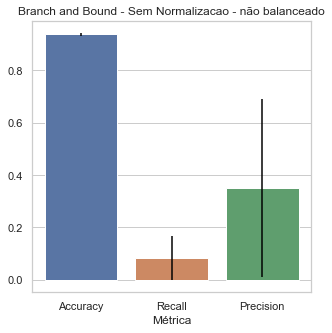

In [24]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Branch and Bound - Sem Normalizacao - não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Branch_and_Bound-Sem_Normalizacao-nao_balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

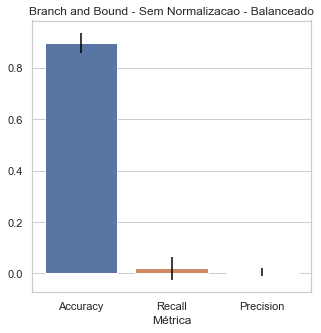

In [25]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Branch and Bound - Sem Normalizacao - Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Branch_and_Bound-Sem_Normalizacao-balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [26]:
path_to_save = '../../model_results/'

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    '7',
    'MLPClassifier',
    'Branch and Bound - Sem Normalização - Desbalanceado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    '7',
    'MLPClassifier',
    'Branch and Bound - Sem Normalização - Balanceado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value']
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao', 
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

Atividade    Algoritmo                                           Condicao           Melhores_Params    Metrica       Valor
0          7          SVC   Dataset Completo Desbalanceado - Nao Normalizado    ('linear', 1, 'scale')   Accuracy    0.960383
1          7          SVC   Dataset Completo Desbalanceado - Nao Normalizado    ('linear', 1, 'scale')     Recall        0.86
2          7          SVC   Dataset Completo Desbalanceado - Nao Normalizado    ('linear', 1, 'scale')  Precision    0.677579
3          7          SVC      Dataset Completo Balanceado - Nao Normalizado    ('rbf', 100, '0.0001')   Accuracy    0.962709
4          7          SVC      Dataset Completo Balanceado - Nao Normalizado    ('rbf', 100, '0.0001')     Recall    0.876667
5          7          SVC      Dataset Completo Balanceado - Nao Normalizado    ('rbf', 100, '0.0001')  Precision    0.690079
6          7          SVC       Dataset Completo Desbalanceado - Normalizado    ('rbf', 100, '0.0001')   Accuracy    0.962709
7          7          SVC       Dataset Completo Desbalanceado - Normalizado    ('rbf', 100, '0.0001')     Recall    0.876667
8          7          SVC       Dataset Completo Desbalanceado - Normalizado    ('rbf', 100, '0.0001')  Precision    0.690079
9          7          SVC          Dataset Completo Balanceado - Normalizado    ('rbf', 100, '0.0001')   Accuracy    0.959193
10         7          SVC          Dataset Completo Balanceado - Normalizado    ('rbf', 100, '0.0001')     Recall        0.91
11         7          SVC          Dataset Completo Balanceado - Normalizado    ('rbf', 100, '0.0001')  Precision    0.673016
12         7          SVC                                  PCA Desbalanceado    ('rbf', 100, '0.0001')   Accuracy    0.963899
13         7          SVC                                  PCA Desbalanceado    ('rbf', 100, '0.0001')     Recall        0.64
14         7          SVC                                  PCA Desbalanceado    ('rbf', 100, '0.0001')  Precision    0.799524
15         7          SVC                                     PCA Balanceado  ('sigmoid', 1, '0.0001')   Accuracy    0.958057
16         7          SVC                                     PCA Balanceado  ('sigmoid', 1, '0.0001')     Recall    0.716667
17         7          SVC                                     PCA Balanceado  ('sigmoid', 1, '0.0001')  Precision     0.71381
18         6  Naive Bayes                     Branch and Bound Desbalanceado                       0.6   Accuracy    0.931245
19         6  Naive Bayes                     Branch and Bound Desbalanceado                       0.6     Recall           0
20         6  Naive Bayes                     Branch and Bound Desbalanceado                       0.6  Precision           0
21         6  Naive Bayes                        Branch and Bound Balanceado                       0.3   Accuracy    0.690109
22         6  Naive Bayes                        Branch and Bound Balanceado                       0.3     Recall    0.216667
23         6  Naive Bayes                        Branch and Bound Balanceado                       0.3  Precision   0.0492712
24         6  Naive Bayes                     Dataset Completo Desbalanceado                       0.6   Accuracy    0.955677
25         6  Naive Bayes                     Dataset Completo Desbalanceado                       0.6     Recall    0.716667
26         6  Naive Bayes                     Dataset Completo Desbalanceado                       0.6  Precision    0.675397
27         6  Naive Bayes                        Dataset Completo Balanceado                       0.8   Accuracy     0.93933
28         6  Naive Bayes                        Dataset Completo Balanceado                       0.8     Recall    0.876667
29         6  Naive Bayes                        Dataset Completo Balanceado                       0.8  Precision    0.547143
30         6  Naive Bayes                                  PCA Desbalanceado                     

Resultados salvos com sucesso
